# Self-Driving Car Engineer Nanodegree


## Project: **Finding Lane Lines on the Road** 
***
In this project, you will use the tools you learned about in the lesson to identify lane lines on the road.  You can develop your pipeline on a series of individual images, and later apply the result to a video stream (really just a series of images). Check out the video clip "raw-lines-example.mp4" (also contained in this repository) to see what the output should look like after using the helper functions below. 

Once you have a result that looks roughly like "raw-lines-example.mp4", you'll need to get creative and try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines.  You can see an example of the result you're going for in the video "P1_example.mp4".  Ultimately, you would like to draw just one line for the left side of the lane, and one for the right.

In addition to implementing code, there is a brief writeup to complete. The writeup should be completed in a separate file, which can be either a markdown file or a pdf document. There is a [write up template](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) that can be used to guide the writing process. Completing both the code in the Ipython notebook and the writeup template will cover all of the [rubric points](https://review.udacity.com/#!/rubrics/322/view) for this project.

---
Let's have a look at our first image called 'test_images/solidWhiteRight.jpg'.  Run the 2 cells below (hit Shift-Enter or the "play" button above) to display the image.

**Note: If, at any point, you encounter frozen display windows or other confounding issues, you can always start again with a clean slate by going to the "Kernel" menu above and selecting "Restart & Clear Output".**

---

**The tools you have are color selection, region of interest selection, grayscaling, Gaussian smoothing, Canny Edge Detection and Hough Tranform line detection.  You  are also free to explore and try other techniques that were not presented in the lesson.  Your goal is piece together a pipeline to detect the line segments in the image, then average/extrapolate them and draw them onto the image for display (as below).  Once you have a working pipeline, try it out on the video stream below.**

---

<figure>
 <img src="line-segments-example.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above) after detecting line segments using the helper functions below </p> 
 </figcaption>
</figure>
 <p></p> 
<figure>
 <img src="laneLines_thirdPass.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your goal is to connect/average/extrapolate line segments to get output like this</p> 
 </figcaption>
</figure>

**Run the cell below to import some packages.  If you get an `import error` for a package you've already installed, try changing your kernel (select the Kernel menu above --> Change Kernel).  Still have problems?  Try relaunching Jupyter Notebook from the terminal prompt.  Also, see [this forum post](https://carnd-forums.udacity.com/cq/viewquestion.action?spaceKey=CAR&id=29496372&questionTitle=finding-lanes---import-cv2-fails-even-though-python-in-the-terminal-window-has-no-problem-with-import-cv2) for more troubleshooting tips.**  

## Import Packages

In [2]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

## Read in an Image

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


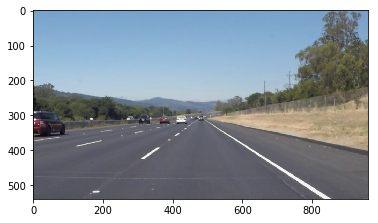

In [3]:
#reading in an image
image = mpimg.imread('test_images/solidWhiteRight.jpg')

#printing out some stats and plotting
print('This image is:', type(image), 'with dimensions:', image.shape)
plt.imshow(image)  # if you wanted to show a single color channel image called 'gray', for example, call as plt.imshow(gray, cmap='gray')

## Ideas for Lane Detection Pipeline

**Some OpenCV functions (beyond those introduced in the lesson) that might be useful for this project are:**

`cv2.inRange()` for color selection  
`cv2.fillPoly()` for regions selection  
`cv2.line()` to draw lines on an image given endpoints  
`cv2.addWeighted()` to coadd / overlay two images
`cv2.cvtColor()` to grayscale or change color
`cv2.imwrite()` to output images to file  
`cv2.bitwise_and()` to apply a mask to an image

**Check out the OpenCV documentation to learn about these and discover even more awesome functionality!**

## Helper Functions

Below are some helper functions to help get you started. They should look familiar from the lesson!

In [122]:
import math
import numpy as np

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

def draw_lines(img, lines, color=[255, 0, 0], thickness=2):
    lm = []
    rm = []
    lc = []
    rc = []

    r_x1 = r_x2 = l_x1 = l_x2 = 0
    for line in lines:
        for x1,y1,x2,y2 in line:
            slope = (y2 - y1)/(x2 - x1)
            center = [(x1 + x2)/2, (y1 + y2)/2]
            
            # Skip lines that have 0 or inf slope
            if math.isnan(slope) or math.isinf(slope):
                continue
            
            # Slope for Right line 
            elif slope < 0:
                rm.append(slope)
                rc.append(center)
                
            # Slope for left line
            elif slope > 0:
                lm.append(slope)
                lc.append(center)

    # additional check to prevent blow-up incase there are no lines at all
    if len(rm):
        r_avg_slope = np.sum(rm)/len(rm)
        r_avg_center = np.divide(np.sum(rc, axis=0), len(rc))

        # calculate intercept y = mx + c
        r_c = r_avg_center[1] - (r_avg_slope * r_avg_center[0])

        # y = mx + c or (y - c)/m = x
        r_x1 =  int((540 - r_c)/r_avg_slope)
        r_x2 =  int((300 - r_c)/r_avg_slope)
    
    # additional check to prevent blow-up incase there are no lines at all
    if len(lm):
        l_avg_slope = np.sum(lm)/len(lm)
        l_avg_center = np.divide(np.sum(lc, axis=0), len(lc))
        
        l_c = l_avg_center[1] - (l_avg_slope * l_avg_center[0])
        
        l_x1 =  int((540 - l_c)/l_avg_slope)
        l_x2 =  int((300 - l_c)/l_avg_slope)        
        
    print( "len rm:", len(rm), "len lm:", len(lm), "r_avg_slope: ", r_avg_slope, "r_avg_center: ", r_avg_center, "l_avg_slope: ", l_avg_slope, "l_avg_center: ", l_avg_center)
        
    # Draw left and right lines
    cv2.line(img, (r_x1, 540), (r_x2, 300), color, thickness)
    cv2.line(img, (l_x1, 540), (l_x2, 300), color, thickness)    

        
def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)

## Test Images

Build your pipeline to work on the images in the directory "test_images"  
**You should make sure your pipeline works well on these images before you try the videos.**

In [123]:
import os
os.listdir("test_images/")

['.DS_Store',
 'solidWhiteCurve.jpg',
 'solidWhiteRight.jpg',
 'solidYellowCurve.jpg',
 'solidYellowCurve2.jpg',
 'solidYellowLeft.jpg',
 'whiteCarLaneSwitch.jpg']

## Build a Lane Finding Pipeline



Build the pipeline and run your solution on all test_images. Make copies into the test_images directory, and you can use the images in your writeup report.

Try tuning the various parameters, especially the low and high Canny thresholds as well as the Hough lines parameters.

(540, 960, 3)
len rm: 4 len lm: 5 r_avg_slope:  -0.811858379716 r_avg_center:  [ 340.125  417.75 ] l_avg_slope:  0.564693754056 l_avg_center:  [ 708.4  437.4]
(540, 960, 3)
len rm: 4 len lm: 4 r_avg_slope:  -0.725772159283 r_avg_center:  [ 356.375  396.125] l_avg_slope:  0.636962733478 l_avg_center:  [ 657.75   420.125]
(540, 960, 3)
len rm: 6 len lm: 3 r_avg_slope:  -0.726096334912 r_avg_center:  [ 337.91666667  413.08333333] l_avg_slope:  0.580514446794 l_avg_center:  [ 605.          389.33333333]
(540, 960, 3)
len rm: 8 len lm: 6 r_avg_slope:  -0.752965283265 r_avg_center:  [ 333.1875  417.625 ] l_avg_slope:  0.581444056219 l_avg_center:  [ 751.25  471.  ]
(540, 960, 3)
len rm: 6 len lm: 6 r_avg_slope:  -0.69690705824 r_avg_center:  [ 323.5         415.58333333] l_avg_slope:  0.61917739383 l_avg_center:  [ 717.58333333  455.08333333]
(540, 960, 3)
len rm: 7 len lm: 6 r_avg_slope:  -0.762482837264 r_avg_center:  [ 355.14285714  408.78571429] l_avg_slope:  0.575087370783 l_avg_center:

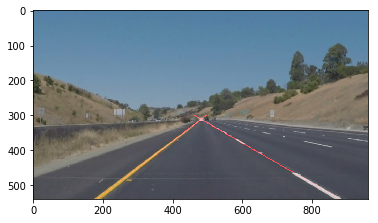

In [159]:
kernel_size = 3
low_threshold = 50
high_threshold = 150 
rho = 1
theta = np.pi/180
threshold = 35
min_line_len = 5
max_line_gap = 2 

files = os.listdir("test_images/")
for file in files:
    if file.lower().endswith(('.jpg')):
        myInitImage = mpimg.imread("test_images/" + file)
        gray = grayscale(myInitImage)
        blurred = gaussian_blur(gray, kernel_size)
        edges = canny(blurred, low_threshold, high_threshold)
        
        imshape = myInitImage.shape
        
        vertices = np.array([[ (.51*imshape[1], .60* imshape[0]), 
                              (.49*imshape[1], .60*imshape[0]),  
                              (100, 500), 
                              (850, 500)
                             ]], dtype=np.int32)


        target = region_of_interest(edges, vertices)
        
        lines = hough_lines(target, rho, theta, threshold, min_line_len, max_line_gap)

        overlapImg = weighted_img(lines, myInitImage)

        result = overlapImg
        plt.imshow(result, cmap='gray')
        
        r,g,b = cv2.split(result)
        result = cv2.merge((b,g,r))
        cv2.imwrite("output_test_images/output_"+file, result)



## Test on Videos

You know what's cooler than drawing lanes over images? Drawing lanes over video!

We can test our solution on two provided videos:

`solidWhiteRight.mp4`

`solidYellowLeft.mp4`

**Note: if you get an `import error` when you run the next cell, try changing your kernel (select the Kernel menu above --> Change Kernel).  Still have problems?  Try relaunching Jupyter Notebook from the terminal prompt. Also, check out [this forum post](https://carnd-forums.udacity.com/questions/22677062/answers/22677109) for more troubleshooting tips.**

**If you get an error that looks like this:**
```
NeedDownloadError: Need ffmpeg exe. 
You can download it by calling: 
imageio.plugins.ffmpeg.download()
```
**Follow the instructions in the error message and check out [this forum post](https://carnd-forums.udacity.com/display/CAR/questions/26218840/import-videofileclip-error) for more troubleshooting tips across operating systems.**

In [8]:
import imageio

In [9]:
imageio.plugins.ffmpeg.download()

In [40]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [148]:
def process_image(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image where lines are drawn on lanes)
    imshape = image.shape
    print("shape of ", imshape , "is ", )
    
    gray = grayscale(image)
    blurred = gaussian_blur(gray, kernel_size)
    edges = canny(blurred, low_threshold, high_threshold)
    # 540, 960
    imshape = image.shape
    # slightly different poly for region_of_interest as the camera looks shifted
    vertices = np.array([[ (.51*imshape[1], .60* imshape[0]),
                          (.49*imshape[1], .60*imshape[0]), 
                          (100, 500), 
                          (900, 500)]], dtype=np.int32)

    # filter img out
    target = region_of_interest(edges, vertices)

    # find lines
    lines = hough_lines(target, rho, theta, threshold, min_line_len, max_line_gap)
    # combine
    overlapImg = weighted_img(lines, image)

    result = overlapImg
    # r,g,b = cv2.split(result)
    # result = cv2.merge((b,g,r))    
    return result

Let's try the one with the solid white lane on the right first ...

In [149]:
white_output = 'white.mp4'
clip1 = VideoFileClip("solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

shape of  (540, 960, 3) is 
len rm: 2 len lm: 5 r_avg_slope:  -0.737152777778 r_avg_center:  [ 259.    465.75] l_avg_slope:  0.625252319109 l_avg_center:  [ 692.3  436.3]
[MoviePy] >>>> Building video white.mp4
[MoviePy] Writing video white.mp4







  0%|          | 0/222 [00:00<?, ?it/s]




  3%|▎         | 6/222 [00:00<00:03, 59.24it/s]

shape of  (540, 960, 3) is 
len rm: 2 len lm: 5 r_avg_slope:  -0.737152777778 r_avg_center:  [ 259.    465.75] l_avg_slope:  0.625252319109 l_avg_center:  [ 692.3  436.3]
shape of  (540, 960, 3) is 
len rm: 4 len lm: 7 r_avg_slope:  -0.709482263954 r_avg_center:  [ 244.375  473.625] l_avg_slope:  0.607808378641 l_avg_center:  [ 678.5         426.57142857]
shape of  (540, 960, 3) is 
len rm: 5 len lm: 7 r_avg_slope:  -0.762976019676 r_avg_center:  [ 267.4  459.6] l_avg_slope:  0.615248881788 l_avg_center:  [ 675.42857143  426.71428571]
shape of  (540, 960, 3) is 
len rm: 1 len lm: 6 r_avg_slope:  -0.736842105263 r_avg_center:  [ 384.5  376. ] l_avg_slope:  0.614432980017 l_avg_center:  [ 688.91666667  434.08333333]
shape of  (540, 960, 3) is 
len rm: 2 len lm: 3 r_avg_slope:  -0.715719063545 r_avg_center:  [ 375.25  379.75] l_avg_slope:  0.612953218354 l_avg_center:  [ 695.5         439.33333333]
shape of  (540, 960, 3) is 
len rm: 3 len lm: 5 r_avg_slope:  -0.724534456419 r_avg_center:

len rm: 8 len lm: 5 r_avg_slope:  -0.738792640344 r_avg_center:  [ 301.9375  432.3125] l_avg_slope:  0.658799558431 l_avg_center:  [ 672.8  432.1]






  7%|▋         | 15/222 [00:00<00:03, 64.90it/s]




 10%|▉         | 22/222 [00:00<00:03, 64.92it/s]


shape of  (540, 960, 3) is 
len rm: 3 len lm: 5 r_avg_slope:  -0.698657835486 r_avg_center:  [ 219.66666667  487.16666667] l_avg_slope:  0.650002501086 l_avg_center:  [ 678.7  432.5]
shape of  (540, 960, 3) is 
len rm: 2 len lm: 6 r_avg_slope:  -0.725 r_avg_center:  [ 296.5   433.25] l_avg_slope:  0.653110578145 l_avg_center:  [ 655.41666667  414.66666667]
shape of  (540, 960, 3) is 
len rm: 1 len lm: 5 r_avg_slope:  -0.739130434783 r_avg_center:  [ 377.5  376.5] l_avg_slope:  0.65128428451 l_avg_center:  [ 701.2  444.8]
shape of  (540, 960, 3) is 
len rm: 2 len lm: 6 r_avg_slope:  -0.679487179487 r_avg_center:  [ 368.  382.] l_avg_slope:  0.641603145752 l_avg_center:  [ 667.08333333  422.33333333]
shape of  (540, 960, 3) is 
len rm: 2 len lm: 5 r_avg_slope:  -0.692708333333 r_avg_center:  [ 358.75  389.75] l_avg_slope:  0.641114829168 l_avg_center:  [ 686.5  437.5]
shape of  (540, 960, 3) is 
len rm: 2 len lm: 5 r_avg_slope:  -0.698611111111 r_avg_center:  [ 349.    398.25] l_avg_slo






 14%|█▍        | 31/222 [00:00<00:02, 68.97it/s]




 18%|█▊        | 39/222 [00:00<00:02, 70.64it/s]

 [ 684.16666667  437.66666667]
shape of  (540, 960, 3) is 
len rm: 2 len lm: 5 r_avg_slope:  -0.707586206897 r_avg_center:  [ 369.5  384.5] l_avg_slope:  0.638561898281 l_avg_center:  [ 667.1  425.7]
shape of  (540, 960, 3) is 
len rm: 3 len lm: 4 r_avg_slope:  -0.695340501792 r_avg_center:  [ 379.83333333  377.        ] l_avg_slope:  0.640383037337 l_avg_center:  [ 665.875  423.75 ]
shape of  (540, 960, 3) is 
len rm: 3 len lm: 4 r_avg_slope:  -0.693772720089 r_avg_center:  [ 307.16666667  426.5       ] l_avg_slope:  0.629284370705 l_avg_center:  [ 677.75  428.5 ]
shape of  (540, 960, 3) is 
len rm: 3 len lm: 5 r_avg_slope:  -0.681495809155 r_avg_center:  [ 363.33333333  388.5       ] l_avg_slope:  0.633674164505 l_avg_center:  [ 674.5  427.4]
shape of  (540, 960, 3) is 
len rm: 3 len lm: 4 r_avg_slope:  -0.726235148147 r_avg_center:  [ 324.16666667  417.5       ] l_avg_slope:  0.636440522516 l_avg_center:  [ 684.5   434.75]
shape of  (540, 960, 3) is 
len rm: 4 len lm: 6 r_avg_slope:






 21%|██        | 47/222 [00:00<00:02, 68.22it/s]




 25%|██▍       | 55/222 [00:00<00:02, 69.67it/s]

len rm: 3 len lm: 5 r_avg_slope:  -0.755718954248 r_avg_center:  [ 329.83333333  411.66666667] l_avg_slope:  0.655258978378 l_avg_center:  [ 680.9  432.5]
shape of  (540, 960, 3) is 
len rm: 3 len lm: 5 r_avg_slope:  -0.73008665717 r_avg_center:  [ 309.          426.66666667] l_avg_slope:  0.644896114617 l_avg_center:  [ 688.5  437.5]
shape of  (540, 960, 3) is 
len rm: 3 len lm: 7 r_avg_slope:  -0.732789568155 r_avg_center:  [ 284.16666667  444.33333333] l_avg_slope:  0.6569089227 l_avg_center:  [ 686.21428571  436.42857143]
shape of  (540, 960, 3) is 
len rm: 5 len lm: 4 r_avg_slope:  -0.729615638708 r_avg_center:  [ 257.6  463.2] l_avg_slope:  0.650668111546 l_avg_center:  [ 668.125  425.625]
shape of  (540, 960, 3) is 
len rm: 5 len lm: 5 r_avg_slope:  -0.704369980453 r_avg_center:  [ 270.6  449. ] l_avg_slope:  0.652812238401 l_avg_center:  [ 675.8  428.2]
shape of  (540, 960, 3) is 
len rm: 4 len lm: 4 r_avg_slope:  -0.730835830836 r_avg_center:  [ 230.75   480.125] l_avg_slope: 






 28%|██▊       | 62/222 [00:00<00:02, 63.55it/s]

len rm: 6 len lm: 7 r_avg_slope:  -0.685417197182 r_avg_center:  [ 344.33333333  399.25      ] l_avg_slope:  0.651184552208 l_avg_center:  [ 646.35714286  414.57142857]
shape of  (540, 960, 3) is 
len rm: 3 len lm: 5 r_avg_slope:  -0.694682891078 r_avg_center:  [ 296.5         430.33333333] l_avg_slope:  0.643254589392 l_avg_center:  [ 670.8  429.3]
shape of  (540, 960, 3) is 
len rm: 5 len lm: 6 r_avg_slope:  -0.689151403001 r_avg_center:  [ 309.   422.8] l_avg_slope:  0.653563117361 l_avg_center:  [ 653.75        418.33333333]
shape of  (540, 960, 3) is 
len rm: 6 len lm: 5 r_avg_slope:  -0.685972158228 r_avg_center:  [ 252.08333333  460.5       ] l_avg_slope:  0.654901670102 l_avg_center:  [ 660.7  423.6]
shape of  (540, 960, 3) is 
len rm: 5 len lm: 7 r_avg_slope:  -0.673923247168 r_avg_center:  [ 267.3  451.7] l_avg_slope:  0.659736879952 l_avg_center:  [ 638.21428571  410.        ]
shape of  (540, 960, 3) is 
len rm: 4 len lm: 7 r_avg_slope:  -0.673884109894 r_avg_center:  [ 263.






 31%|███       | 69/222 [00:01<00:02, 64.25it/s]

0.659289808647 l_avg_center:  [ 657.625  422.75 ]
shape of 






 34%|███▍      | 76/222 [00:01<00:02, 64.19it/s]

 (540, 960, 3) is 
len rm: 4 len lm: 5 r_avg_slope:  -0.658281914164 r_avg_center:  [ 340.875  399.75 ] l_avg_slope:  0.659872973497 l_avg_center:  [ 666.9  429. ]
shape of  (540, 960, 3) is 
len rm: 5 len lm: 7 r_avg_slope:  -0.660510683431 r_avg_center:  [ 325.1  409.1] l_avg_slope:  0.662877966245 l_avg_center:  [ 659.          424.57142857]
shape of  (540, 960, 3) is 
len rm: 4 len lm: 5 r_avg_slope:  -0.665602779573 r_avg_center:  [ 282.5  437. ] l_avg_slope:  0.652324671493 l_avg_center:  [ 654.1  418.4]
shape of  (540, 960, 3) is 
len rm: 5 len lm: 6 r_avg_slope:  -0.668601989818 r_avg_center:  [ 269.5  445.5] l_avg_slope:  0.644203708419 l_avg_center:  [ 647.41666667  415.41666667]
shape of  (540, 960, 3) is 
len rm: 5 len lm: 3 r_avg_slope:  -0.645706034705 r_avg_center:  [ 298.1  426.2] l_avg_slope:  0.656023291862 l_avg_center:  [ 660.          424.16666667]
shape of  (540, 960, 3) is 
len rm: 4 len lm: 6 r_avg_slope:  -0.661219597911 r_avg_center:  [ 257.625  453.375] l_avg

 5 r_avg_slope:  -0.651360544218 r_avg_center:  [ 330.25  402.75] l_avg_slope:  0.669359452276 l_avg_center:  [ 656.1  424.5]
shape of  (540, 960, 3) is 
len rm: 2 len lm: 5 r_avg_slope:  -0.657407407407 r_avg_center:  [ 314.    413.25] l_avg_slope:  0.667105243048 l_avg_center:  [ 661.9  428.3]
shape of  (540, 960, 3) is 







 37%|███▋      | 83/222 [00:01<00:02, 62.19it/s]




 41%|████      | 90/222 [00:01<00:02, 62.27it/s]

len rm: 3 len lm: 6 r_avg_slope:  -0.661866830065 r_avg_center:  [ 296.66666667  426.16666667] l_avg_slope:  0.668648845661 l_avg_center:  [ 663.41666667  429.08333333]
shape of  (540, 960, 3) is 
len rm: 3 len lm: 6 r_avg_slope:  -0.656772485703 r_avg_center:  [ 277.  439.] l_avg_slope:  0.67657387228 l_avg_center:  [ 661.75        429.58333333]
shape of  (540, 960, 3) is 
len rm: 5 len lm: 4 r_avg_slope:  -0.638631752917 r_avg_center:  [ 304.8  420.5] l_avg_slope:  0.676155000503 l_avg_center:  [ 643.375  417.25 ]
shape of  (540, 960, 3) is 
len rm: 6 len lm: 5 r_avg_slope:  -0.647927896712 r_avg_center:  [ 306.16666667  419.5       ] l_avg_slope:  0.677329105468 l_avg_center:  [ 657.7  427.8]
shape of  (540, 960, 3) is 
len rm: 5 len lm: 6 r_avg_slope:  -0.65026297086 r_avg_center:  [ 284.   435.2] l_avg_slope:  0.677663576742 l_avg_center:  [ 649.75        421.41666667]
shape of  (540, 960, 3) is 
len rm: 3 len lm: 8 r_avg_slope:  -0.643333333333 r_avg_center:  [ 319.          413.






 44%|████▎     | 97/222 [00:01<00:02, 60.09it/s]




 47%|████▋     | 104/222 [00:01<00:01, 62.43it/s]

 -0.681301106301 r_avg_center:  [ 298.83333333  427.16666667] l_avg_slope:  0.699838833897 l_avg_center:  [ 662.          429.33333333]
shape of  (540, 960, 3) is 
len rm: 4 len lm: 5 r_avg_slope:  -0.659083529239 r_avg_center:  [ 271.25   443.875] l_avg_slope:  0.704137688526 l_avg_center:  [ 657.5  426.5]
shape of  (540, 960, 3) is 
len rm: 4 len lm: 4 r_avg_slope:  -0.660876059787 r_avg_center:  [ 247.5   459.75] l_avg_slope:  0.700569895583 l_avg_center:  [ 654.25  422.5 ]
shape of  (540, 960, 3) is 
len rm: 3 len lm: 6 r_avg_slope:  -0.666604735471 r_avg_center:  [ 224.5         476.16666667] l_avg_slope:  0.699924374648 l_avg_center:  [ 672.75        435.41666667]
shape of  (540, 960, 3) is 
len rm: 3 len lm: 4 r_avg_slope:  -0.631177446103 r_avg_center:  [ 276.5         440.66666667] l_avg_slope:  0.702809783062 l_avg_center:  [ 647.75   416.375]
shape of  (540, 960, 3) is 
len rm: 5 len lm: 6 r_avg_slope:  -0.661560303496 r_avg_center:  [ 270.2  442.4] l_avg_slope:  0.688982214






 50%|█████     | 111/222 [00:01<00:01, 62.53it/s]




 54%|█████▎    | 119/222 [00:01<00:01, 64.20it/s]

len rm: 5 len lm: 5 r_avg_slope:  -0.683990718956 r_avg_center:  [ 280.1  443. ] l_avg_slope:  0.691015907245 l_avg_center:  [ 651.6  418. ]
shape of  (540, 960, 3) is 
len rm: 6 len lm: 4 r_avg_slope:  -0.685475551902 r_avg_center:  [ 264.66666667  455.25      ] l_avg_slope:  0.686933221317 l_avg_center:  [ 684.75  440.75]
shape of  (540, 960, 3) is 
len rm: 4 len lm: 5 r_avg_slope:  -0.658333333333 r_avg_center:  [ 273.     447.875] l_avg_slope:  0.683038550271 l_avg_center:  [ 684.2  439.8]
shape of  (540, 960, 3) is 
len rm: 5 len lm: 4 r_avg_slope:  -0.705887858604 r_avg_center:  [ 323.8  414. ] l_avg_slope:  0.678882136058 l_avg_center:  [ 665.75   425.375]
shape of  (540, 960, 3) is 
len rm: 1 len lm: 4 r_avg_slope:  -0.666666666667 r_avg_center:  [ 378.  378.] l_avg_slope:  0.686756267452 l_avg_center:  [ 672.5   431.75]
shape of  (540, 960, 3) is 
len rm: 2 len lm: 4 r_avg_slope:  -0.686153846154 r_avg_center:  [ 368.25  382.25] l_avg_slope:  0.683450492882 l_avg_center:  [ 64






 57%|█████▋    | 126/222 [00:01<00:01, 61.09it/s]

len rm: 4 len lm: 6 r_avg_slope:  -0.687924659873 r_avg_center:  [ 239.5   471.25] l_avg_slope:  0.653612757729 l_avg_center:  [ 672.33333333  427.83333333]
shape of  (540, 960, 3) is 
len rm: 6 len lm: 5 r_avg_slope:  -0.680658577534 r_avg_center:  [ 251.08333333  462.58333333] l_avg_slope:  0.658254544061 l_avg_center:  [ 653.2  416.8]
shape of  (540, 960, 3) is 
len rm: 6 len lm: 7 r_avg_slope:  -0.70275545085 r_avg_center:  [ 308.5  426. ] l_avg_slope:  0.641915261631 l_avg_center:  [ 645.92857143  410.78571429]
shape of  (540, 960, 3) is 
len rm: 2 len lm: 5 r_avg_slope:  -0.676086956522 r_avg_center:  [ 380.25  376.75] l_avg_slope:  0.651019007243 l_avg_center:  [ 667.1  424.3]
shape of  (540, 960, 3) is 
len rm: 2 len lm: 4 r_avg_slope:  -0.693333333333 r_avg_center:  [ 373.  382.] l_avg_slope:  0.638292391248 l_avg_center:  [ 671.25   426.375]
shape of  (540, 960, 3) is 
len rm: 4 len lm: 4 r_avg_slope:  -0.69391025641 r_avg_center:  [ 379.25  377.75] l_avg_slope:  0.6365820157






 60%|█████▉    | 133/222 [00:02<00:01, 62.38it/s]

 l_avg_center:  [ 713.6  452.4]
shape of  (540, 960, 3) is 
len rm: 6 len lm: 5 r_avg_slope:  -0.695803769554 r_avg_center:  [ 286.58333333  445.08333333] l_avg_slope:  0.639390384432 l_avg_center:  [ 665.9  423.3]
shape of  (540, 960, 3) is 







 63%|██████▎   | 140/222 [00:02<00:01, 57.91it/s]

len rm: 4 len lm: 7 r_avg_slope:  -0.700124472175 r_avg_center:  [ 240.375  478.125] l_avg_slope:  0.623782747948 l_avg_center:  [ 685.78571429  433.21428571]
shape of  (540, 960, 3) is 
len rm: 6 len lm: 3 r_avg_slope:  -0.691191117666 r_avg_center:  [ 265.5         458.16666667] l_avg_slope:  0.641083582895 l_avg_center:  [ 671.16666667  425.16666667]
shape of  (540, 960, 3) is 
len rm: 6 len lm: 4 r_avg_slope:  -0.72164479827 r_avg_center:  [ 282.5   448.25] l_avg_slope:  0.62945769799 l_avg_center:  [ 691.625  433.75 ]
shape of  (540, 960, 3) is 
len rm: 2 len lm: 4 r_avg_slope:  -0.704968944099 r_avg_center:  [ 382.5   374.75] l_avg_slope:  0.635448409931 l_avg_center:  [ 698.625  439.875]
shape of  (540, 960, 3) is 
len rm: 2 len lm: 5 r_avg_slope:  -0.666666666667 r_avg_center:  [ 401.   363.5] l_avg_slope:  0.634975620258 l_avg_center:  [ 675.8  425.8]
shape of  (540, 960, 3) is 
len rm: 2 len lm: 5 r_avg_slope:  -0.701851851852 r_avg_center:  [ 367.75  386.5 ] l_avg_slope:  0.

len rm: 7 len lm: 5 r_avg_slope:  -0.68460217943 r_avg_center:  [ 368.57142857  389.71428571] l_avg_slope:  0.638881776981 l_avg_center:  [ 679.1  431.8]
shape of  (540, 960, 3) is 
len rm: 5 len lm: 4 r_avg_slope:  -0.727531795947 r_avg_center:  [ 324.5  421.3] l_avg_slope:  0.639072797218






 66%|██████▌   | 146/222 [00:02<00:01, 55.91it/s]




 68%|██████▊   | 152/222 [00:02<00:01, 55.59it/s]

 l_avg_center:  [ 668.25   424.125]
shape of  (540, 960, 3) is 
len rm: 5 len lm: 4 r_avg_slope:  -0.725501045955 r_avg_center:  [ 300.3  438.3] l_avg_slope:  0.636001693108 l_avg_center:  [ 677.     428.375]
shape of  (540, 960, 3) is 
len rm: 4 len lm: 4 r_avg_slope:  -0.702636054422 r_avg_center:  [ 289.5    445.375] l_avg_slope:  0.635490210056 l_avg_center:  [ 682.125  430.375]
shape of  (540, 960, 3) is 
len rm: 3 len lm: 5 r_avg_slope:  -0.721315623023 r_avg_center:  [ 296.83333333  440.66666667] l_avg_slope:  0.638876487612 l_avg_center:  [ 678.3  426.9]
shape of  (540, 960, 3) is 
len rm: 4 len lm: 6 r_avg_slope:  -0.710955710956 r_avg_center:  [ 319.875  423.   ] l_avg_slope:  0.631151219383 l_avg_center:  [ 663.33333333  416.41666667]
shape of  (540, 960, 3) is 
len rm: 2 len lm: 7 r_avg_slope:  -0.703636363636 r_avg_center:  [ 385.25  376.25] l_avg_slope:  0.614397733809 l_avg_center:  [ 681.14285714  426.21428571]
shape of  (540, 960, 3) is 
len rm: 2 len lm: 6 r_avg_slope






 71%|███████   | 158/222 [00:02<00:01, 54.33it/s]




 74%|███████▍  | 164/222 [00:02<00:01, 55.01it/s]

 r_avg_slope:  -0.73794858203 r_avg_center:  [ 351.57142857  401.28571429] l_avg_slope:  0.634533248692 l_avg_center:  [ 693.42857143  433.78571429]
shape of  (540, 960, 3) is 
len rm: 5 len lm: 4 r_avg_slope:  -0.71772005772 r_avg_center:  [ 276.6  454.8] l_avg_slope:  0.625879996486 l_avg_center:  [ 691.5    431.625]
shape of  (540, 960, 3) is 
len rm: 6 len lm: 5 r_avg_slope:  -0.73911171202 r_avg_center:  [ 253.08333333  471.91666667] l_avg_slope:  0.61743920896 l_avg_center:  [ 706.7  439.9]
shape of  (540, 960, 3) is 
len rm: 4 len lm: 3 r_avg_slope:  -0.744982196859 r_avg_center:  [ 250.125  476.25 ] l_avg_slope:  0.629561792052 l_avg_center:  [ 685.66666667  427.83333333]
shape of  (540, 960, 3) is 
len rm: 5 len lm: 5 r_avg_slope:  -0.758283171271 r_avg_center:  [ 307.8  434.3] l_avg_slope:  0.615098461828 l_avg_center:  [ 696.5  433.4]
shape of  (540, 960, 3) is 
len rm: 3 len lm: 3 r_avg_slope:  -0.717893217893 r_avg_center:  [ 369.83333333  389.33333333] l_avg_slope:  0.605






 77%|███████▋  | 170/222 [00:02<00:00, 54.34it/s]

 (540, 960, 3) is 
len rm: 6 len lm: 5 r_avg_slope:  -0.779038281979 r_avg_center:  [ 322.58333333  430.83333333] l_avg_slope:  0.58420720137 l_avg_center:  [ 711.6  440.8]
shape of  (540, 960, 3) is 
len rm: 4 len lm: 4 r_avg_slope:  -0.755995550831 r_avg_center:  [ 283.75  458.  ] l_avg_slope:  0.58785384771 l_avg_center:  [ 704.5  438.5]
shape of  (540, 960, 3) is 
len rm: 8 len lm: 3 r_avg_slope:  -0.749020524376 r_avg_center:  [ 295.3125  451.125 ] l_avg_slope:  0.583251224279 l_avg_center:  [ 696.16666667  432.16666667]
shape of  (540, 960, 3) is 
len rm: 7 len lm: 3 r_avg_slope:  -0.764626305067 r_avg_center:  [ 299.71428571  448.07142857] l_avg_slope:  0.591525647805 l_avg_center:  [ 704.33333333  439.83333333]
shape of  (540, 960, 3) is 
len rm: 6 len lm: 5 r_avg_slope:  -0.768165362902 r_avg_center:  [ 299.91666667  449.08333333] l_avg_slope:  0.58579228266 l_avg_center:  [ 678.8  423. ]
shape of  (540, 960, 3) is 
len rm: 2 len lm: 3 r_avg_slope:  -0.821428571429 r_avg_cente






 79%|███████▉  | 176/222 [00:02<00:00, 53.15it/s]

len rm: 3 len lm: 3 r_avg_slope:  -0.782637362637 r_avg_center:  [ 370.5         393.33333333] l_avg_slope:  0.59495688039 l_avg_center:  [ 684.16666667  427.66666667]
shape of  (540, 960, 3) is 
len rm: 3 len lm: 4 r_avg_slope:  -0.829099821747 r_avg_center:  [ 382.83333333  385.83333333] l_avg_slope:  0.587200007975 l_avg_center:  [ 706.    438.75]
shape of  (540, 960, 3) is 
len rm: 4 len lm: 5 r_avg_slope:  






 82%|████████▏ | 182/222 [00:02<00:00, 54.04it/s]

-0.77066395664 r_avg_center:  [ 367.75   396.625] l_avg_slope:  0.587804895495 l_avg_center:  [ 694.3  431.9]
shape of  (540, 960, 3) is 
len rm: 3 len lm: 6 r_avg_slope:  -0.777257675838 r_avg_center:  [ 339.66666667  418.16666667] l_avg_slope:  0.590209620846 l_avg_center:  [ 666.91666667  415.        ]
shape of  (540, 960, 3) is 
len rm: 5 len lm: 5 r_avg_slope:  -0.813220641836 r_avg_center:  [ 339.4  418.8] l_avg_slope:  0.591559927175 l_avg_center:  [ 700.1  434. ]
shape of  (540, 960, 3) is 
len rm: 5 len lm: 5 r_avg_slope:  -0.811388410786 r_avg_center:  [ 324.4  433.7] l_avg_slope:  0.59336214112 l_avg_center:  [ 687.2  426.4]
shape of  (540, 960, 3) is 
len rm: 4 len lm: 5 r_avg_slope:  -0.807642186254 r_avg_center:  [ 281.     466.375] l_avg_slope:  0.587311198836 l_avg_center:  [ 676.6  419.9]
shape of  (540, 960, 3) is 
len rm: 6 len lm: 7 r_avg_slope:  -0.810541898259 r_avg_center:  [ 291.5         456.66666667] l_avg_slope:  0.605655139203 l_avg_center:  [ 716.85714286  

 len lm: 5 r_avg_slope:  -0.782196969697 r_avg_center:  [ 380.5  385. ] l_avg_slope:  0.593643750451 l_avg_center:  [ 681.1  422.6]
shape of  (540, 960, 3) is 







 85%|████████▍ | 188/222 [00:03<00:00, 54.61it/s]

len rm: 3 len lm: 6 r_avg_slope:  -0.781874039939 r_avg_center:  [ 388.5  376.5] l_avg_slope:  0.578296499587 l_avg_center:  [ 721.41666667  443.25      ]
shape of  (540, 960, 3) is 
len rm: 2 len lm: 5 r_avg_slope:  -0.785947712418 r_avg_center:  [ 361.5   397.75] l_avg_slope:  0.584645690829 l_avg_center:  [ 708.1  433.5]
shape of  (540, 960, 3) is 







 87%|████████▋ | 194/222 [00:03<00:00, 54.51it/s]

len rm: 2 len lm: 7 r_avg_slope:  -0.811296534018 r_avg_center:  [ 349.75  404.5 ] l_avg_slope:  0.583227037136 l_avg_center:  [ 735.85714286  446.5       ]
shape of  (540, 960, 3) is 
len rm: 2 len lm: 4 r_avg_slope:  -0.794025157233 r_avg_center:  [ 336.25  417.  ] l_avg_slope:  0.570521465276 l_avg_center:  [ 718.625  437.   ]
shape of  (540, 960, 3) is 
len rm: 5 len lm: 6 r_avg_slope:  -0.791008117308 r_avg_center:  [ 340.8  415.6] l_avg_slope:  0.570567349192 l_avg_center:  [ 696.          426.58333333]
shape of  (540, 960, 3) is 
len rm: 7 len lm: 5 r_avg_slope:  -0.807210351832 r_avg_center:  [ 311.85714286  442.64285714] l_avg_slope:  0.584008186361 l_avg_center:  [ 708.2  436.1]
shape of  (540, 960, 3) is 
len rm: 4 len lm: 4 r_avg_slope:  -0.794793550332 r_avg_center:  [ 315.375  439.125] l_avg_slope:  0.589091636748 l_avg_center:  [ 689.  428.]
shape of  (540, 960, 3) is 
len rm: 6 len lm: 4 r_avg_slope:  -0.802099774581 r_avg_center:  [ 314.33333333  439.5       ] l_avg_sl






 90%|█████████ | 200/222 [00:03<00:00, 54.40it/s]

len rm: 3 len lm: 4 r_avg_slope:  -0.781111111111 r_avg_center:  [ 351.83333333  406.16666667] l_avg_slope:  0.580280733193 l_avg_center:  [ 686.25   424.375]
shape of  (540, 960, 3) is 
len rm: 4 len lm: 6 r_avg_slope:  -0.808211848635 r_avg_center:  [ 386.75   381.625] l_avg_slope:  0.585435124968 l_avg_center:  [ 693.91666667  429.83333333]
shape of  (540, 960, 3) is 







 93%|█████████▎| 206/222 [00:03<00:00, 53.81it/s]

len rm: 3 len lm: 6 r_avg_slope:  -0.773383354029 r_avg_center:  [ 359.5         400.66666667] l_avg_slope:  0.576946056214 l_avg_center:  [ 719.41666667  443.41666667]
shape of  (540, 960, 3) is 
len rm: 3 len lm: 5 r_avg_slope:  -0.791812865497 r_avg_center:  [ 349.5  408. ] l_avg_slope:  0.571230617238 l_avg_center:  [ 704.3  433.3]
shape of  (540, 960, 3) is 
len rm: 5 len lm: 5 r_avg_slope:  -0.779651668795 r_avg_center:  [ 351.9  407.2] l_avg_slope:  0.573467456165 l_avg_center:  [ 714.8  437.7]
shape of  (540, 960, 3) is 
len rm: 5 len lm: 5 r_avg_slope:  -0.808357991754 r_avg_center:  [ 316.3  437.3] l_avg_slope:  0.571208426011 l_avg_center:  [ 690.8  424.4]
shape of  (540, 960, 3) is 
len rm: 5 len lm: 6 r_avg_slope:  -0.783760968615 r_avg_center:  [ 304.3  443.8] l_avg_slope:  0.575285217213 l_avg_center:  [ 695.33333333  426.66666667]
shape of  (540, 960, 3) is 
len rm: 4 len lm: 8 r_avg_slope:  -0.789948254557 r_avg_center:  [ 302.75   448.125] l_avg_slope:  0.578999339194

len lm: 4 r_avg_slope:  -0.775815217391 r_avg_center:  [ 388.25  376.5 ] l_avg_slope:  0.558169216557 l_avg_center:  [ 710.25   431.875]
shape of  (540, 960, 3) is 
len rm: 2 len lm: 4 r_avg_slope:  -0.755148741419 r_avg_center:  [ 382.   382.5] l_avg_slope:  0.557322060332 l_avg_center:  [ 706.375  430.375]
shape of  (540, 960, 3) is 
len rm:






 95%|█████████▌| 212/222 [00:03<00:00, 54.11it/s]




 98%|█████████▊| 218/222 [00:03<00:00, 55.27it/s]




100%|█████████▉| 221/222 [00:03<00:00, 60.02it/s]

 3 len lm: 4 r_avg_slope:  -0.797701149425 r_avg_center:  [ 370.5         393.16666667] l_avg_slope:  0.570000926188 l_avg_center:  [ 695.25  428.5 ]
shape of  (540, 960, 3) is 
len rm: 3 len lm: 5 r_avg_slope:  -0.809764309764 r_avg_center:  [ 362.33333333  400.33333333] l_avg_slope:  0.559969935128 l_avg_center:  [ 695.   428.1]
shape of  (540, 960, 3) is 
len rm: 3 len lm: 3 r_avg_slope:  -0.806561085973 r_avg_center:  [ 355.          406.66666667] l_avg_slope:  0.562259913388 l_avg_center:  [ 729.5  446.5]
shape of  (540, 960, 3) is 
len rm: 3 len lm: 4 r_avg_slope:  -0.790598290598 r_avg_center:  [ 363.33333333  400.16666667] l_avg_slope:  0.563523137263 l_avg_center:  [ 695.5  428.5]
shape of  (540, 960, 3) is 
len rm: 5 len lm: 4 r_avg_slope:  -0.788107333843 r_avg_center:  [ 337.7  420.4] l_avg_slope:  0.570833099961 l_avg_center:  [ 661.75  412.  ]
shape of  (540, 960, 3) is 
len rm: 6 len lm: 4 r_avg_slope:  -0.796512092244 r_avg_center:  [ 328.41666667  429.16666667] l_avg_s

[MoviePy] Done.
[MoviePy] >>>> Video ready: white.mp4 

CPU times: user 3.06 s, sys: 2.04 s, total: 5.1 s
Wall time: 4.11 s


Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [150]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

## Improve the draw_lines() function

**At this point, if you were successful with making the pipeline and tuning parameters, you probably have the Hough line segments drawn onto the road, but what about identifying the full extent of the lane and marking it clearly as in the example video (P1_example.mp4)?  Think about defining a line to run the full length of the visible lane based on the line segments you identified with the Hough Transform. As mentioned previously, try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines. You can see an example of the result you're going for in the video "P1_example.mp4".**

**Go back and modify your draw_lines function accordingly and try re-running your pipeline. The new output should draw a single, solid line over the left lane line and a single, solid line over the right lane line. The lines should start from the bottom of the image and extend out to the top of the region of interest.**

Now for the one with the solid yellow lane on the left. This one's more tricky!

In [151]:
yellow_output = 'yellow.mp4'
clip2 = VideoFileClip('solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

shape of  (540, 960, 3) is 
len rm: 5 len lm: 3 r_avg_slope:  -0.617109248096 r_avg_center:  [ 301.8  422.6] l_avg_slope:  0.677014652015 l_avg_center:  [ 717.5         461.66666667]
[MoviePy] >>>> Building video yellow.mp4
[MoviePy] Writing video yellow.mp4







  0%|          | 0/682 [00:00<?, ?it/s]




  1%|          | 7/682 [00:00<00:10, 65.15it/s]

shape of  (540, 960, 3) is 
len rm: 5 len lm: 3 r_avg_slope:  -0.617109248096 r_avg_center:  [ 301.8  422.6] l_avg_slope:  0.677014652015 l_avg_center:  [ 717.5         461.66666667]
shape of  (540, 960, 3) is 
len rm: 6 len lm: 8 r_avg_slope:  -0.614326997215 r_avg_center:  [ 311.5   418.25] l_avg_slope:  0.688780086018 l_avg_center:  [ 700.0625  453.8125]
shape of  (540, 960, 3) is 
len rm: 5 len lm: 3 r_avg_slope:  -0.629543120702 r_avg_center:  [ 321.3  411.7] l_avg_slope:  0.668261562998 l_avg_center:  [ 738.83333333  476.33333333]
shape of  (540, 960, 3) is 
len rm: 7 len lm: 3 r_avg_slope:  -0.640366224773 r_avg_center:  [ 326.28571429  409.21428571] l_avg_slope:  0.691086691087 l_avg_center:  [ 759.33333333  492.66666667]
shape of  (540, 960, 3) is 
len rm: 5 len lm: 2 r_avg_slope:  -0.642240345004 r_avg_center:  [ 321.8  413.3] l_avg_slope:  0.653409090909 l_avg_center:  [ 594.5  378.5]
shape of  (540, 960, 3) is 
len rm: 3 len lm: 2 r_avg_slope:  -0.642899841268 r_avg_center:

 r_avg_center:  [ 298.66666667  431.83333333] l_avg_slope:  0.636544983163 l_avg_center:  [ 706.07142857  448.5       ]
shape of  (540, 960, 3) is 
len rm:






  2%|▏         | 16/682 [00:00<00:09, 69.71it/s]




  3%|▎         | 22/682 [00:00<00:09, 66.41it/s]

 9 len lm: 6 r_avg_slope:  -0.67587215688 r_avg_center:  [ 320.72222222  418.5       ] l_avg_slope:  0.667864104706 l_avg_center:  [ 717.83333333  456.75      ]
shape of  (540, 960, 3) is 
len rm: 8 len lm: 5 r_avg_slope:  -0.684945643297 r_avg_center:  [ 314.125  423.   ] l_avg_slope:  0.645743477468 l_avg_center:  [ 732.9  464.4]
shape of  (540, 960, 3) is 
len rm: 6 len lm: 2 r_avg_slope:  -0.684903312309 r_avg_center:  [ 326.  414.] l_avg_slope:  0.591666666667 l_avg_center:  [ 693.  437.]
shape of  (540, 960, 3) is 
len rm: 5 len lm: 2 r_avg_slope:  -0.697338002324 r_avg_center:  [ 336.4  408.7] l_avg_slope:  0.632478632479 l_avg_center:  [ 600.5  379.5]
shape of  (540, 960, 3) is 
len rm: 4 len lm: 2 r_avg_slope:  -0.688858879459 r_avg_center:  [ 312.    424.75] l_avg_slope:  0.627450980392 l_avg_center:  [ 610.75  386.  ]
shape of  (540, 960, 3) is 
len rm: 5 len lm: 2 r_avg_slope:  -0.683371083194 r_avg_center:  [ 296.5  434.2] l_avg_slope:  0.616741741742 l_avg_center:  [ 621.






  4%|▍         | 27/682 [00:00<00:11, 56.53it/s]




  5%|▍         | 33/682 [00:00<00:11, 56.07it/s]

(540, 960, 3) is 
len rm: 9 len lm: 6 r_avg_slope:  -0.696471860363 r_avg_center:  [ 330.44444444  414.33333333] l_avg_slope:  0.606602619109 l_avg_center:  [ 721.83333333  452.66666667]
shape of  (540, 960, 3) is 
len rm: 8 len lm: 7 r_avg_slope:  -0.696843083913 r_avg_center:  [ 295.25  437.5 ] l_avg_slope:  0.615907825118 l_avg_center:  [ 696.21428571  437.14285714]
shape of  (540, 960, 3) is 
len rm: 8 len lm: 4 r_avg_slope:  -0.707048471889 r_avg_center:  [ 299.4375  436.0625] l_avg_slope:  0.607060993411 l_avg_center:  [ 763.125  477.625]
shape of  (540, 960, 3) is 
len rm: 5 len lm: 3 r_avg_slope:  -0.718903395257 r_avg_center:  [ 321.9  418.7] l_avg_slope:  0.606805555556 l_avg_center:  [ 722.33333333  451.5       ]
shape of  (540, 960, 3) is 
len rm: 9 len lm: 1 r_avg_slope:  -0.713127011866 r_avg_center:  [ 326.38888889  415.22222222] l_avg_slope:  0.615384615385 l_avg_center:  [ 599.  377.]
shape of  (540, 960, 3) is 
len rm: 5 len lm: 2 r_avg_slope:  -0.708961562593 r_avg_c






  6%|▌         | 42/682 [00:00<00:10, 62.03it/s]




  7%|▋         | 49/682 [00:00<00:10, 61.23it/s]

len lm: 4 r_avg_slope:  -0.729831113025 r_avg_center:  [ 307.8125  428.0625] l_avg_slope:  0.613624633618 l_avg_center:  [ 747.25   463.125]
shape of  (540, 960, 3) is 
len rm: 4 len lm: 6 r_avg_slope:  -0.731124322394 r_avg_center:  [ 306.875  426.875] l_avg_slope:  0.595485392225 l_avg_center:  [ 773.5         476.83333333]
shape of  (540, 960, 3) is 
len rm: 7 len lm: 3 r_avg_slope:  -0.717193133024 r_avg_center:  [ 296.57142857  432.85714286] l_avg_slope:  0.590640394089 l_avg_center:  [ 780.16666667  480.83333333]
shape of  (540, 960, 3) is 
len rm: 5 len lm: 2 r_avg_slope:  -0.727545977403 r_avg_center:  [ 321.1  415.9] l_avg_slope:  0.627450980392 l_avg_center:  [ 695.25  435.  ]
shape of  (540, 960, 3) is 
len rm: 7 len lm: 1 r_avg_slope:  -0.735835036505 r_avg_center:  [ 320.64285714  417.35714286] l_avg_slope:  0.586206896552 l_avg_center:  [ 601.5  376.5]
shape of  (540, 960, 3) is 
len rm: 6 len lm: 2 r_avg_slope:  -0.73316410377 r_avg_center:  [ 305.58333333  428.41666667]






  8%|▊         | 55/682 [00:00<00:10, 58.90it/s]




  9%|▉         | 62/682 [00:00<00:10, 59.04it/s]

len rm: 4 len lm: 6 r_avg_slope:  -0.728297695089 r_avg_center:  [ 312.125  423.25 ] l_avg_slope:  0.606966215432 l_avg_center:  [ 721.66666667  449.75      ]
shape of  (540, 960, 3) is 
len rm: 5 len lm: 5 r_avg_slope:  -0.737724369734 r_avg_center:  [ 325.8  413.7] l_avg_slope:  0.596319683633 l_avg_center:  [ 728.1  455.2]
shape of  (540, 960, 3) is 
len rm: 6 len lm: 3 r_avg_slope:  -0.73483950678 r_avg_center:  [ 328.41666667  413.        ] l_avg_slope:  0.617391304348 l_avg_center:  [ 722.5         450.83333333]
shape of  (540, 960, 3) is 
len rm: 7 len lm: 1 r_avg_slope:  -0.73031678235 r_avg_center:  [ 316.14285714  419.92857143] l_avg_slope:  0.571428571429 l_avg_center:  [ 595.  377.]
shape of  (540, 960, 3) is 
len rm: 4 len lm: 2 r_avg_slope:  -0.726052864281 r_avg_center:  [ 323.875  414.625] l_avg_slope:  0.593103448276 l_avg_center:  [ 604.25  380.75]
shape of  (540, 960, 3) is 
len rm: 6 len lm: 2 r_avg_slope:  -0.730059521629 r_avg_center:  [ 296.33333333  435.75      






 10%|▉         | 68/682 [00:01<00:10, 57.77it/s]

len rm: 6 len lm: 8 r_avg_slope:  -0.704273152285 r_avg_center:  [ 287.16666667  439.08333333] l_avg_slope:  0.614758212285 l_avg_center:  [ 723.25  454.  ]
shape of  (540, 960, 3) is 
len rm: 4 len lm: 6 r_avg_slope:  -0.711362942613 r_avg_center:  [ 312.  421.] l_avg_slope:  0.601766671581 l_avg_center:  [ 698.16666667  437.91666667]
shape of  (540, 960, 3) is 
len rm: 3 len lm: 3 r_avg_slope:  -0.703496081977 r_avg_center:  [ 290.          435.66666667] l_avg_slope:  0.59716034716 l_avg_center:  [ 770.          482.16666667]
shape of  (540, 960, 3) is 
len rm: 5 len lm: 3 r_avg_slope:  -0.712579060137 r_avg_center:  [ 322.   416.5] l_avg_slope:  0.599572649573 l_avg_center:  [ 653.   414.5]
shape of  (540, 960, 3) is 
len rm: 4 len lm: 2 r_avg_slope:  -0.703614612309 r_avg_center:  [ 300.5    428.875] l_avg_slope:  0.572158365262 l_avg_center:  [ 596.  378.]
shape of  (540, 960, 3) is 
len rm: 7 len lm: 3 r_avg_slope:  -0.703804154937 r_avg_center:  [ 296.85714286  431.78571429] l_a






 11%|█         | 74/682 [00:01<00:11, 54.61it/s]

len rm: 7 len lm: 5 r_avg_slope:  -0.709060958073 r_avg_center:  [ 319.64285714  417.64285714] l_avg_slope:  0.616428571429 l_avg_center:  [ 641.1  406. ]







 12%|█▏        | 80/682 [00:01<00:11, 51.14it/s]

shape of  (540, 960, 3) is 
len rm: 10 len lm: 5 r_avg_slope:  -0.721504424304 r_avg_center:  [ 308.35  428.95] l_avg_slope:  0.615140974156 l_avg_center:  [ 705.7  447.1]
shape of  (540, 960, 3) is 
len rm: 5 len lm: 5 r_avg_slope:  -0.696129023582 r_avg_center:  [ 307.3  426.9] l_avg_slope:  0.639380436385 l_avg_center:  [ 704.6  448.4]
shape of  (540, 960, 3) is 
len rm: 6 len lm: 5 r_avg_slope:  -0.709109809956 r_avg_center:  [ 319.08333333  418.25      ] l_avg_slope:  0.616479468599 l_avg_center:  [ 757.1  479.9]
shape of  (540, 960, 3) is 
len rm: 8 len lm: 4 r_avg_slope:  -0.699227369722 r_avg_center:  [ 299.1875  433.1875] l_avg_slope:  0.623612653112 l_avg_center:  [ 758.5  481.5]
shape of  (540, 960, 3) is 
len rm: 7 len lm: 4 r_avg_slope:  -0.709563916046 r_avg_center:  [ 294.78571429  434.57142857] l_avg_slope:  0.634415584416 l_avg_center:  [ 676.125  429.625]
shape of  (540, 960, 3) is 
len rm: 6 len lm: 2 r_avg_slope:  -0.706277691831 r_avg_center:  [ 307.83333333  424. 

 0.633076593924 l_avg_center:  [ 615.16666667  390.33333333]
shape of  (540, 960, 3) is 
len rm: 6 len lm: 3 r_avg_slope:  -0.699620063303 r_avg_center:  [ 287.08333333  438.75      ] l_avg_slope:  0.639935587762 l_avg_center:  [ 622.5         396.83333333]
shape of  (540, 960, 3) is 
len rm: 4 len lm: 3






 13%|█▎        | 86/682 [00:01<00:11, 51.63it/s]




 13%|█▎        | 92/682 [00:01<00:11, 50.80it/s]

 r_avg_slope:  -0.700589199063 r_avg_center:  [ 306.5    424.875] l_avg_slope:  0.64806027306 l_avg_center:  [ 630.33333333  401.83333333]
shape of  (540, 960, 3) is 
len rm: 9 len lm: 3 r_avg_slope:  -0.708973880143 r_avg_center:  [ 289.38888889  437.33333333] l_avg_slope:  0.63825637782 l_avg_center:  [ 620.33333333  395.16666667]
shape of  (540, 960, 3) is 
len rm: 5 len lm: 3 r_avg_slope:  -0.701722917999 r_avg_center:  [ 297.3  430.7] l_avg_slope:  0.654325389751 l_avg_center:  [ 634.33333333  403.83333333]
shape of  (540, 960, 3) is 
len rm: 6 len lm: 2 r_avg_slope:  -0.707388920027 r_avg_center:  [ 311.08333333  423.25      ] l_avg_slope:  0.632363253857 l_avg_center:  [ 697.75  443.75]
shape of  (540, 960, 3) is 
len rm: 4 len lm: 6 r_avg_slope:  -0.688151014973 r_avg_center:  [ 294.125  432.125] l_avg_slope:  0.641050038464 l_avg_center:  [ 702.91666667  447.66666667]
shape of  (540, 960, 3) is 
len rm: 4 len lm: 8 r_avg_slope:  -0.686075863018 r_avg_center:  [ 295.5  431.5] l






 15%|█▍        | 99/682 [00:01<00:10, 53.80it/s]




 15%|█▌        | 105/682 [00:01<00:10, 53.46it/s]

0.636437908497 l_avg_center:  [ 611.          393.83333333]
shape of  (540, 960, 3) is 
len rm: 6 len lm: 3 r_avg_slope:  -0.695939788662 r_avg_center:  [ 314.25        422.91666667] l_avg_slope:  0.663967611336 l_avg_center:  [ 619.66666667  396.83333333]
shape of  (540, 960, 3) is 
len rm: 5 len lm: 2 r_avg_slope:  -0.69269701159 r_avg_center:  [ 327.6  413.7] l_avg_slope:  0.639282103134 l_avg_center:  [ 636.75  408.25]
shape of  (540, 960, 3) is 
len rm: 6 len lm: 5 r_avg_slope:  -0.694315490109 r_avg_center:  [ 310.91666667  425.58333333] l_avg_slope:  0.615587745588 l_avg_center:  [ 615.3  392.9]
shape of  (540, 960, 3) is 
len rm: 4 len lm: 3 r_avg_slope:  -0.713848423141 r_avg_center:  [ 345.75  401.75] l_avg_slope:  0.662292609351 l_avg_center:  [ 633.33333333  405.16666667]
shape of  (540, 960, 3) is 
len rm: 5 len lm: 5 r_avg_slope:  -0.712327748151 r_avg_center:  [ 324.   417.7] l_avg_slope:  0.619252991528 l_avg_center:  [ 646.1  412.1]
shape of  (540, 960, 3) is 
len rm: 






 16%|█▋        | 111/682 [00:01<00:10, 54.28it/s]

 2 r_avg_slope:  -0.689274478344 r_avg_center:  [ 307.25        426.66666667] l_avg_slope:  0.61045943304 l_avg_center:  [ 607.5   387.75]
shape of  (540, 960, 3) is 
len rm: 5 len lm: 2 r_avg_slope:  -0.686618559938 r_avg_center:  [ 323.3  416.2] l_avg_slope:  0.644360902256 l_avg_center:  [ 617.25  394.75]
shape of  (540, 960, 3) is 
len rm: 7 len lm: 5 r_avg_slope:  -0.690017905252 r_avg_center:  [ 278.42857143  449.35714286] l_avg_slope:  0.625872298433 l_avg_center:  [ 641.7  411.2]
shape of  (540, 960, 3) is 
len rm: 5 len lm: 3 r_avg_slope:  -0.69103764098 r_avg_center:  [ 316.1  422.5] l_avg_slope:  0.608585858586 l_avg_center:  [ 643.5         410.66666667]
shape of  (540, 960, 3) is 
len rm: 6 len lm: 5 r_avg_slope:  -0.692345945393 r_avg_center:  [ 311.16666667  425.08333333] l_avg_slope:  0.633036075036 l_avg_center:  [ 633.7  405.7]
shape of  (540, 960, 3) is 
len rm: 7 len lm: 4 r_avg_slope:  -0.696828760993 r_avg_center:  [ 320.07142857  420.42857143] l_avg_slope:  0.626






 17%|█▋        | 118/682 [00:02<00:10, 56.28it/s]

len rm: 7 len lm: 3 r_avg_slope:  -0.694662279411 r_avg_center:  [ 319.          419.71428571] l_avg_slope:  0.632935691759 l_avg_center:  [ 650.5         416.16666667]
shape of  (540, 960, 3) is 
len rm: 7 len lm: 2 r_avg_slope:  -0.702551777485 r_avg_center:  [ 320.          419.92857143] l_avg_slope:  0.62962962963 l_avg_center:  [ 599.  381.]
shape of  (540, 960, 3) is 
len rm: 8 len lm: 3 r_avg_slope:  -0.697629456157 r_avg_center:  






 18%|█▊        | 124/682 [00:02<00:09, 56.58it/s]

[ 301.5     433.5625] l_avg_slope:  0.625252525253 l_avg_center:  [ 587.5         374.33333333]
shape of  (540, 960, 3) is 
len rm: 6 len lm: 3 r_avg_slope:  -0.692620954415 r_avg_center:  [ 304.16666667  430.66666667] l_avg_slope:  0.636982570806 l_avg_center:  [ 594.33333333  379.        ]
shape of  (540, 960, 3) is 
len rm: 8 len lm: 3 r_avg_slope:  -0.713287012585 r_avg_center:  [ 308.8125  428.625 ] l_avg_slope:  0.600840336134 l_avg_center:  [ 628.16666667  398.5       ]
shape of  (540, 960, 3) is 
len rm: 4 len lm: 3 r_avg_slope:  -0.693071444443 r_avg_center:  [ 318.125  419.5  ] l_avg_slope:  0.605928350609 l_avg_center:  [ 612.16666667  390.33333333]
shape of  (540, 960, 3) is 
len rm: 6 len lm: 7 r_avg_slope:  -0.703795007902 r_avg_center:  [ 287.16666667  442.5       ] l_avg_slope:  0.605733696988 l_avg_center:  [ 633.5         401.78571429]
shape of  (540, 960, 3) is 
len rm: 5 len lm: 5 r_avg_slope:  -0.704413718301 r_avg_center:  [ 322.9  416.5] l_avg_slope:  0.624623570

 3 len lm: 4 r_avg_slope:  -0.692707597363 r_avg_center:  [ 310.          426.83333333] l_avg_slope:  0.629414809402 l_avg_center:  [ 681.125  433.25 ]
shape of  (540, 960, 3) is 







 19%|█▉        | 131/682 [00:02<00:09, 58.29it/s]

len rm: 6 len lm: 2 r_avg_slope:  -0.699243760614 r_avg_center:  [ 318.83333333  422.66666667] l_avg_slope:  0.630434782609 l_avg_center:  [ 596.5   380.25]
shape of  (540, 960, 3) is 
len rm: 5 len lm: 4 r_avg_slope:  -0.695667382894 r_avg_center:  [ 310.6  427.1] l_avg_slope:  0.600198412698 l_avg_center:  [ 607.625  388.25 ]
shape of  (540, 960, 3) is 







 20%|██        | 137/682 [00:02<00:09, 57.34it/s]

len rm: 5 len lm: 3 r_avg_slope:  -0.693334943639 r_avg_center:  [ 357.6  394.3] l_avg_slope:  0.60303030303 l_avg_center:  [ 640.66666667  409.5       ]
shape of  (540, 960, 3) is 
len rm: 4 len lm: 2 r_avg_slope:  -0.700252175143 r_avg_center:  [ 329.625  414.625] l_avg_slope:  0.601495726496 l_avg_center:  [ 621.75  396.25]
shape of  (540, 960, 3) is 
len rm: 3 len lm: 2 r_avg_slope:  -0.707781876706 r_avg_center:  [ 336.16666667  411.16666667] l_avg_slope:  0.621428571429 l_avg_center:  [ 633.75  403.5 ]
shape of  (540, 960, 3) is 
len rm: 5 len lm: 3 r_avg_slope:  -0.704540930967 r_avg_center:  [ 301.   436.6] l_avg_slope:  0.629430618401 l_avg_center:  [ 645.83333333  412.83333333]
shape of  (540, 960, 3) is 
len rm: 3 len lm: 2 r_avg_slope:  -0.694997279932 r_avg_center:  [ 344.16666667  404.5       ] l_avg_slope:  0.622033898305 l_avg_center:  [ 664.5   423.75]
shape of  (540, 960, 3) is 
len rm: 4 len lm: 5 r_avg_slope:  -0.700827703591 r_avg_center:  [ 323.375  419.875] l_avg






 21%|██        | 143/682 [00:02<00:09, 56.11it/s]

[ 709.875  453.   ]
shape of  (540, 960, 3) is 
len rm: 7 len lm: 2 r_avg_slope:  -0.704618763498 r_avg_center:  [ 321.28571429  419.5       ] l_avg_slope:  0.598181818182 l_avg_center:  [ 591.25  377.  ]
shape of  (540, 960, 3) is 
len rm: 5 len lm: 4 r_avg_slope:  -0.704300116971 r_avg_center:  [ 302.2  431.3] l_avg_slope:  0.600198412698 l_avg_center:  [ 572.375  365.5  ]






 22%|██▏       | 149/682 [00:02<00:09, 56.84it/s]


shape of  (540, 960, 3) is 
len rm: 7 len lm: 2 r_avg_slope:  -0.686765278524 r_avg_center:  [ 334.42857143  410.92857143] l_avg_slope:  0.613300492611 l_avg_center:  [ 607.25  387.25]
shape of  (540, 960, 3) is 
len rm: 5 len lm: 4 r_avg_slope:  -0.705010718908 r_avg_center:  [ 291.7  440.1] l_avg_slope:  0.623687423687 l_avg_center:  [ 642.875  410.   ]
shape of  (540, 960, 3) is 
len rm: 7 len lm: 4 r_avg_slope:  -0.698595531117 r_avg_center:  [ 336.42857143  409.28571429] l_avg_slope:  0.618916297118 l_avg_center:  [ 607.125  386.375]
shape of  (540, 960, 3) is 
len rm: 7 len lm: 4 r_avg_slope:  -0.709338601282 r_avg_center:  [ 315.92857143  424.42857143] l_avg_slope:  0.603308823529 l_avg_center:  [ 597.     380.375]
shape of  (540, 960, 3) is 
len rm: 9 len lm: 3 r_avg_slope:  -0.705327925474 r_avg_center:  [ 318.          423.44444444] l_avg_slope:  0.614062825047 l_avg_center:  [ 659.  418.]
shape of  (540, 960, 3) is 
len rm: 8 len lm: 5 r_avg_slope:  -0.687481623622 r_avg_ce

 6 len lm: 4 r_avg_slope:  -0.69405939149 r_avg_center:  [ 334.91666667  415.83333333] l_avg_slope:  0.617147435897 l_avg_center:  [ 603.25   384.875]
shape of  (540, 960, 3) is 
len rm: 6 len lm: 3 r_avg_slope:  -0.706208293622 r_avg_center:  [ 338.41666667  413.41666667] l_avg_slope:  0.607509157509 l_avg_center:  [ 581.5  372. ]







 23%|██▎       | 157/682 [00:02<00:08, 59.87it/s]




 24%|██▍       | 164/682 [00:02<00:08, 60.21it/s]

shape of  (540, 960, 3) is 
len rm: 7 len lm: 3 r_avg_slope:  -0.691527547495 r_avg_center:  [ 364.21428571  395.71428571] l_avg_slope:  0.580269607843 l_avg_center:  [ 616.33333333  393.66666667]
shape of  (540, 960, 3) is 
len rm: 7 len lm: 2 r_avg_slope:  -0.687739916672 r_avg_center:  [ 307.          435.57142857] l_avg_slope:  0.590789473684 l_avg_center:  [ 627.5  399.5]
shape of  (540, 960, 3) is 
len rm: 8 len lm: 3 r_avg_slope:  -0.694815603838 r_avg_center:  [ 337.5625  415.5625] l_avg_slope:  0.577852998066 l_avg_center:  [ 635.          403.66666667]
shape of  (540, 960, 3) is 
len rm: 5 len lm: 3 r_avg_slope:  -0.704293394777 r_avg_center:  [ 354.   404.6] l_avg_slope:  0.598154209856 l_avg_center:  [ 623.5         397.83333333]
shape of  (540, 960, 3) is 
len rm: 7 len lm: 6 r_avg_slope:  -0.707343167152 r_avg_center:  [ 348.64285714  408.5       ] l_avg_slope:  0.595459512307 l_avg_center:  [ 675.08333333  425.33333333]
shape of  (540, 960, 3) is 
len rm: 6 len lm: 8 r_a

 [ 348.25        410.16666667] l_avg_slope:  0.573192239859 l_avg_center:  [ 590.   373.5]
shape of  (540, 960, 3) is 
len rm: 






 25%|██▌       | 171/682 [00:02<00:08, 60.44it/s]




 26%|██▌       | 178/682 [00:03<00:08, 62.44it/s]

6 len lm: 2 r_avg_slope:  -0.722325390558 r_avg_center:  [ 315.5         433.41666667] l_avg_slope:  0.592165898618 l_avg_center:  [ 616.75  388.75]
shape of  (540, 960, 3) is 
len rm: 8 len lm: 4 r_avg_slope:  -0.72784364602 r_avg_center:  [ 354.75  405.5 ] l_avg_slope:  0.619892473118 l_avg_center:  [ 591.375  374.125]
shape of  (540, 960, 3) is 
len rm: 7 len lm: 5 r_avg_slope:  -0.728398013014 r_avg_center:  [ 351.85714286  408.        ] l_avg_slope:  0.594077649078 l_avg_center:  [ 669.7  419.6]
shape of  (540, 960, 3) is 
len rm: 7 len lm: 4 r_avg_slope:  -0.741794013806 r_avg_center:  [ 367.92857143  396.07142857] l_avg_slope:  0.56301843318 l_avg_center:  [ 629.5  395. ]
shape of  (540, 960, 3) is 
len rm: 8 len lm: 5 r_avg_slope:  -0.722863036707 r_avg_center:  [ 370.75   392.875] l_avg_slope:  0.565885752633 l_avg_center:  [ 656.   408.8]
shape of  (540, 960, 3) is 
len rm: 8 len lm: 5 r_avg_slope:  -0.743960793643 r_avg_center:  [ 355.    403.75] l_avg_slope:  0.578265954742






 27%|██▋       | 185/682 [00:03<00:08, 62.07it/s]




 28%|██▊       | 192/682 [00:03<00:07, 63.36it/s]

 7 len lm: 3 r_avg_slope:  -0.740954468281 r_avg_center:  [ 358.64285714  403.85714286] l_avg_slope:  0.556055900621 l_avg_center:  [ 612.83333333  384.5       ]
shape of  (540, 960, 3) is 
len rm: 5 len lm: 6 r_avg_slope:  -0.764708541645 r_avg_center:  [ 328.5  426.4] l_avg_slope:  0.551045141336 l_avg_center:  [ 672.33333333  419.25      ]
shape of  (540, 960, 3) is 
len rm: 9 len lm: 5 r_avg_slope:  -0.750835793415 r_avg_center:  [ 349.66666667  411.33333333] l_avg_slope:  0.549933487565 l_avg_center:  [ 650.6  406.5]
shape of  (540, 960, 3) is 
len rm: 6 len lm: 4 r_avg_slope:  -0.768528676906 r_avg_center:  [ 366.5         398.33333333] l_avg_slope:  0.550142698589 l_avg_center:  [ 678.75   423.125]
shape of  (540, 960, 3) is 
len rm: 11 len lm: 6 r_avg_slope:  -0.771403726486 r_avg_center:  [ 340.27272727  418.27272727] l_avg_slope:  0.55403291051 l_avg_center:  [ 686.5         426.58333333]
shape of  (540, 960, 3) is 
len rm: 9 len lm: 8 r_avg_slope:  -0.79362064885 r_avg_cente






 29%|██▉       | 199/682 [00:03<00:07, 62.02it/s]

 10 len lm: 5 r_avg_slope:  -0.795074745279 r_avg_center:  [ 347.25  411.55] l_avg_slope:  0.534154589372 l_avg_center:  [ 653.1  409.6]
shape of  (540, 960, 3) is 
len rm: 12 len lm: 8 r_avg_slope:  -0.751720611001 r_avg_center:  [ 348.41666667  409.45833333] l_avg_slope:  0.552377706904 l_avg_center:  [ 601.25   381.375]
shape of  (540, 960, 3) is 
len rm: 6 len lm: 9 r_avg_slope:  -0.763605346286 r_avg_center:  [ 357.66666667  402.33333333] l_avg_slope:  0.557814407814 l_avg_center:  [ 662.05555556  414.11111111]
shape of  (540, 960, 3) is 
len rm: 8 len lm: 8 r_avg_slope:  -0.772362462529 r_avg_center:  [ 334.      420.6875] l_avg_slope:  0.555026734961 l_avg_center:  [ 676.5625  422.75  ]
shape of  (540, 960, 3) is 
len rm: 9 len lm: 8 r_avg_slope:  -0.787587068877 r_avg_center:  [ 330.38888889  423.16666667] l_avg_slope:  0.561684810986 l_avg_center:  [ 656.75    412.6875]
shape of  (540, 960, 3) is 
len rm: 8 len lm: 7 r_avg_slope:  -0.784741058218 r_avg_center:  [ 336.6875  417






 30%|███       | 206/682 [00:03<00:07, 61.91it/s]

l_avg_slope:  0.565079365079 l_avg_center:  [ 555.83333333  359.5       ]
shape of  (540, 960, 3) is 
len rm: 7 len lm: 7 r_avg_slope:  -0.771231786738 r_avg_center:  [ 363.28571429  398.        ] l_avg_slope:  0.564781746032 l_avg_center:  [ 572.   368.5]
shape of  (540, 960, 3) is 
len rm: 6 len lm: 9 r_avg_slope:  -0.746674745285 r_avg_center:  [ 326.33333333  424.33333333] l_avg_slope:  0.55114638448 l_avg_center:  [ 565.05555556  364.38888889]
shape of  (540, 960, 3) is 
len rm: 5 len lm: 6 r_avg_slope:  -0.740691618208 r_avg_center:  [ 316.3  431.5] l_avg_slope:  0.558313281356 l_avg_center:  [ 613.16666667  390.83333333]
shape of  (540, 960, 3)






 31%|███       | 213/682 [00:03<00:07, 59.19it/s]

 is 
len rm: 5 len lm: 9 r_avg_slope:  -0.738489615923 r_avg_center:  [ 323.9  425. ] l_avg_slope:  0.550074509495 l_avg_center:  [ 606.61111111  386.88888889]
shape of  (540, 960, 3) is 
len rm: 6 len lm: 7 r_avg_slope:  -0.741675544199 r_avg_center:  [ 337.25  415.75] l_avg_slope:  0.554845154845 l_avg_center:  [ 632.35714286  401.        ]
shape of  (540, 960, 3) is 
len rm: 8 len lm: 7 r_avg_slope:  -0.744363495704 r_avg_center:  [ 348.875   405.5625] l_avg_slope:  0.564346129148 l_avg_center:  [ 621.35714286  397.        ]
shape of  (540, 960, 3) is 
len rm: 5 len lm: 8 r_avg_slope:  -0.739500023237 r_avg_center:  [ 346.9  405.9] l_avg_slope:  0.545286593889 l_avg_center:  [ 617.0625  394.25  ]
shape of  (540, 960, 3) is 
len rm: 5 len lm: 10 r_avg_slope:  -0.724695835826 r_avg_center:  [ 337.7  413. ] l_avg_slope:  0.581636827815 l_avg_center:  [ 668.25  424.3 ]
shape of  (540, 960, 3) is 
len rm: 9 len lm: 10 r_avg_slope:  -0.745720361027 r_avg_center:  [ 326.94444444  422.77777






 32%|███▏      | 221/682 [00:03<00:07, 62.34it/s]

 -0.712513478867 r_avg_center:  [ 319.71428571  423.92857143] l_avg_slope:  0.595924289674 l_avg_center:  [ 577.875  372.75 ]
shape of  (540, 960, 3) is 
len rm: 8 len lm: 6 r_avg_slope:  -0.733331691672 r_avg_center:  [ 336.4375  413.5   ]






 33%|███▎      | 228/682 [00:03<00:07, 59.98it/s]

 l_avg_slope:  0.602485380117 l_avg_center:  [ 658.   418.5]
shape of  (540, 960, 3) is 
len rm: 6 len lm: 3 r_avg_slope:  -0.72774839184 r_avg_center:  [ 323.33333333  422.75      ] l_avg_slope:  0.620423098914 l_avg_center:  [ 642.33333333  410.83333333]
shape of  (540, 960, 3) is 
len rm: 6 len lm: 5 r_avg_slope:  -0.722702621037 r_avg_center:  [ 289.25  445.25] l_avg_slope:  0.566724135905 l_avg_center:  [ 637.2  406.9]
shape of  (540, 960, 3) is 
len rm: 4 len lm: 6 r_avg_slope:  -0.728084017146 r_avg_center:  [ 322.5  422.5] l_avg_slope:  0.610509469434 l_avg_center:  [ 684.91666667  435.16666667]
shape of  (540, 960, 3) is 
len rm: 4 len lm: 7 r_avg_slope:  -0.713422138669 r_avg_center:  [ 324.125  420.375] l_avg_slope:  0.592040257448 l_avg_center:  [ 677.71428571  430.14285714]
shape of  (540, 960, 3) is 
len rm: 7 len lm: 5 r_avg_slope:  -0.710734290493 r_avg_center:  [ 358.42857143  394.78571429] l_avg_slope:  0.59666885574 l_avg_center:  [ 744.7  469.1]
shape of  (540, 960,

len rm: 5 len lm: 2 r_avg_slope:  -0.71366273869 r_avg_center:  [ 327.6  416.5] l_avg_slope:  0.575684380032 l_avg_center:  [ 597.5   380.25]
shape of  (540, 960, 3) is 
len rm: 5 len lm: 3 r_avg_slope:  -0.710126245254 r_avg_center:  [ 318.4  422.4] l_avg_slope:  0.600967741935 l_avg_center:  [ 610.          389.33333333]
shape of  (540, 960, 3) is 
len rm: 5 len lm: 3 r_avg_slope:  -0.709571541835 r_avg_center:  [ 321.1  421.5] l_avg_slope:  0.614023114023 l_avg_center:  [ 617.66666667  394.5       ]
shape of  (540, 960, 3) is 
len rm: 7 len lm: 5 r_avg_slope:  -0.706507426653 r_avg_center:  [ 321.57142857  421.71428571] l_avg_slope:  0.569551282051 l_avg_center:  [ 614.8  390.9]
shape of  (540, 960, 3) is 
len rm: 5 len lm: 






 34%|███▍      | 235/682 [00:03<00:07, 59.47it/s]




 35%|███▌      | 242/682 [00:04<00:07, 60.39it/s]

5 r_avg_slope:  -0.710438729137 r_avg_center:  [ 342.   406.6] l_avg_slope:  0.579854732946 l_avg_center:  [ 598.5  382.2]
shape of  (540, 960, 3) is 
len rm: 6 len lm: 7 r_avg_slope:  -0.709737344115 r_avg_center:  [ 316.   424.5] l_avg_slope:  0.610701203558 l_avg_center:  [ 626.5         397.28571429]
shape of  (540, 960, 3) is 
len rm: 7 len lm: 7 r_avg_slope:  -0.705724162913 r_avg_center:  [ 314.07142857  423.92857143] l_avg_slope:  0.602926635647 l_avg_center:  [ 654.5         413.85714286]
shape of  (540, 960, 3) is 
len rm: 5 len lm: 8 r_avg_slope:  -0.708001713988 r_avg_center:  [ 318.   421.1] l_avg_slope:  0.591648209671 l_avg_center:  [ 653.25  412.5 ]
shape of  (540, 960, 3) is 
len rm: 6 len lm: 9 r_avg_slope:  -0.720998386145 r_avg_center:  [ 314.75        424.41666667] l_avg_slope:  0.608037124166 l_avg_center:  [ 697.61111111  440.16666667]
shape of  (540, 960, 3) is 
len rm: 6 len lm: 9 r_avg_slope:  -0.710850030838 r_avg_center:  [ 328.25        415.83333333] l_avg_

len rm: 5 len lm: 3 r_avg_slope:  -0.695938264304 r_avg_center:  [ 313.9  426.1] l_avg_slope:  0.572588522589 l_avg_center:  [ 618.83333333  394.66666667]
shape of  (540, 960, 3) is 
len rm: 12 len lm: 5 r_avg_slope:  -0.717101245958 r_avg_center:  [ 341.125       408.45833333] l_avg_slope:  0.562152599174 l_avg_center:  [ 600.1  385.3]
shape of  (540, 960, 3) is 







 37%|███▋      | 249/682 [00:04<00:06, 62.52it/s]




 38%|███▊      | 256/682 [00:04<00:06, 63.06it/s]

len rm: 6 len lm: 3 r_avg_slope:  -0.700509225545 r_avg_center:  [ 316.41666667  425.25      ] l_avg_slope:  0.59188034188 l_avg_center:  [ 615.33333333  392.5       ]
shape of  (540, 960, 3) is 
len rm: 8 len lm: 4 r_avg_slope:  -0.713279820698 r_avg_center:  [ 351.    400.25] l_avg_slope:  0.530170045472 l_avg_center:  [ 627.875  400.875]
shape of  (540, 960, 3) is 
len rm: 7 len lm: 5 r_avg_slope:  -0.721854165964 r_avg_center:  [ 334.21428571  411.71428571] l_avg_slope:  0.602794787739 l_avg_center:  [ 685.   436.2]
shape of  (540, 960, 3) is 
len rm: 7 len lm: 8 r_avg_slope:  -0.694617246327 r_avg_center:  [ 323.42857143  419.78571429] l_avg_slope:  0.59380597003 l_avg_center:  [ 652.5625  415.3125]
shape of  (540, 960, 3) is 
len rm: 6 len lm: 9 r_avg_slope:  -0.726193559065 r_avg_center:  [ 287.33333333  448.        ] l_avg_slope:  0.574622858474 l_avg_center:  [ 660.5         421.11111111]
shape of  (540, 960, 3) is 
len rm: 8 len lm: 9 r_avg_slope:  -0.723893897897 r_avg_cente






 39%|███▊      | 263/682 [00:04<00:06, 61.35it/s]

[ 312.5  429.6] l_avg_slope:  0.602132298596 l_avg_center:  [ 595.5  381.5]
shape of  (540, 960, 3) is 
len rm: 6 len lm: 6 r_avg_slope:  -0.724742523306 r_avg_center:  [ 325.25        420.08333333] l_avg_slope:  0.595157988814 l_avg_center:  [ 606.41666667  389.41666667]
shape of  (540, 960, 3) is 
len rm: 5 len lm: 7 r_avg_slope:  -0.731300700246 r_avg_center:  [ 312.7  430. ] l_avg_slope:  0.566961731758 l_avg_center:  [ 618.64285714  395.42857143]
shape of  (540, 960, 3) is 
len rm: 6 len lm: 6 r_avg_slope:  -0.714634574346 r_avg_center:  [ 319.08333333  425.        ] l_avg_slope:  0.584962615078 l_avg_center:  [ 640.5   407.75]
shape of  (540, 960, 3) is 
len rm: 7 len lm: 6 r_avg_slope:  -0.720950846429 r_avg_center:  [ 342.35714286  407.28571429] l_avg_slope:  0.602254261647 l_avg_center:  [ 662.41666667  420.        ]
shape of  (540, 960, 3) is 
len rm: 4 len lm: 9 r_avg_slope:  -0.712770170392 r_avg_center:  [ 336.5   410.75] l_avg_slope:  0.583511386468 l_avg_center:  [ 679.5






 40%|███▉      | 270/682 [00:04<00:06, 62.19it/s]

 7 len lm: 3 r_avg_slope:  -0.707896851473 r_avg_center:  [ 333.85714286  414.07142857] l_avg_slope:  0.55467372134 l_avg_center:  [ 573.83333333  367.        ]
shape of  (540, 960, 3) is 
len rm: 8 len lm: 4 r_avg_slope:  -0.703159094083 r_avg_center:  [ 319.125   425.5625] l_avg_slope:  0.552009054895 l_avg_center:  [ 591.25   375.875]
shape of  (540, 960, 3) is 
len rm: 3 len lm: 4 r_avg_slope:  -0.716155141155 r_avg_center:  [ 340.  412.] l_avg_slope:  0.570354864434 l_avg_center:  [ 579.     369.375]
shape of  (540, 960, 3) is 
len rm: 7 len lm: 4 r_avg_slope:  -0.706498733601 r_avg_center:  [ 324.14285714  423.35714286] l_avg_slope:  0.528249738767 l_avg_center:  [ 611.875  388.   ]
shape of 






 41%|████      | 277/682 [00:04<00:06, 59.64it/s]

 (540, 960, 3) is 
len rm: 5 len lm: 5 r_avg_slope:  -0.713495727751 r_avg_center:  [ 341.  411.] l_avg_slope:  0.5675884445 l_avg_center:  [ 627.5  397.2]
shape of  (540, 960, 3) is 
len rm: 8 len lm: 7 r_avg_slope:  -0.720827965083 r_avg_center:  [ 360.875   398.1875] l_avg_slope:  0.545249662618 l_avg_center:  [ 586.5  375. ]
shape of  (540, 960, 3) is 
len rm: 6 len lm: 7 r_avg_slope:  -0.710334962442 r_avg_center:  [ 336.16666667  413.66666667] l_avg_slope:  0.581260716043 l_avg_center:  [ 652.07142857  411.78571429]
shape of  (540, 960, 3) is 
len rm: 7 len lm: 5 r_avg_slope:  -0.72095228533 r_avg_center:  [ 361.28571429  396.28571429] l_avg_slope:  0.573412395333 l_avg_center:  [ 666.1  421. ]
shape of  (540, 960, 3) is 
len rm: 6 len lm: 7 r_avg_slope:  -0.712124403181 r_avg_center:  [ 309.75        431.66666667] l_avg_slope:  0.583218748906 l_avg_center:  [ 732.71428571  456.5       ]
shape of  (540, 960, 3) is 
len rm: 9 len lm: 9 r_avg_slope:  -0.73210477983 r_avg_center:  [






 42%|████▏     | 284/682 [00:04<00:06, 61.76it/s]

8 len lm: 5 r_avg_slope:  -0.762021082569 r_avg_center:  [ 324.5625  426.25  ] l_avg_slope:  0.555037185037 l_avg_center:  [ 568.5  366.8]
shape of  (540, 960, 3) is 
len rm: 14 len lm: 6 r_avg_slope:  -0.664466969367 r_avg_center:  [ 341.57142857  409.5       ] l_avg_slope:  0.567003824477 l_avg_center:  [ 569.41666667  368.66666667]
shape of  (540, 960, 3) is 
len rm: 8 len lm: 6 r_avg_slope:  -0.723530790124 r_avg_center:  [ 355.1875  401.9375] l_avg_slope:  0.553209643467 l_avg_center:  [ 565.          366.41666667]
shape of  (540, 960, 3) is 
len rm: 10 len lm: 7 r_avg_slope:  -0.64207451606 r_avg_center:  [ 337.15  411.55] l_avg_slope:  0.543583254673 l_avg_center:  [ 591.28571429  380.57142857]
shape of  (540, 960, 3) is 
len rm: 10 len lm: 9 






 43%|████▎     | 291/682 [00:04<00:06, 57.65it/s]

r_avg_slope:  -0.650822043852 r_avg_center:  [ 329.6   414.95] l_avg_slope:  0.543400708256 l_avg_center:  [ 592.61111111  380.11111111]
shape of  (540, 960, 3) is 
len rm: 10 len lm: 9 r_avg_slope:  -0.713880446253 r_avg_center:  [ 344.75  407.1 ] l_avg_slope:  0.554414922169 l_avg_center:  [ 601.88888889  386.5       ]
shape of  (540, 960, 3) is 
len rm: 9 len lm: 7 r_avg_slope:  -0.72145774956 r_avg_center:  [ 344.77777778  409.27777778] l_avg_slope:  0.593543421597 l_avg_center:  [ 613.57142857  395.07142857]
shape of  (540, 960, 3) is 
len rm: 11 len lm: 15 r_avg_slope:  -0.71331062278 r_avg_center:  [ 315.95454545  430.90909091] l_avg_slope:  0.527331570356 l_avg_center:  [ 593.86666667  399.76666667]
shape of  (540, 960, 3) is 
len rm: 10 len lm: 16 r_avg_slope:  -0.651863250318 r_avg_center:  [ 316.9  426.5] l_avg_slope:  0.57462313039 l_avg_center:  [ 642.6875   413.78125]
shape of  (540, 960, 3) is 
len rm: 10 len lm: 11 r_avg_slope:  -0.641238537687 r_avg_center:  [ 320.25  

 -0.715214927682 r_avg_center:  [ 326.125  421.625] l_avg_slope:  0.582130982828 l_avg_center:  [ 659.9   421.55]
shape of  (540, 960, 3) is 
len rm: 8 len lm: 5 r_avg_slope:  -0.725351984799 r_avg_center:  [ 333.3125  417.125 ] l_avg_slope:  0.585786749482 l_avg_center:  [ 578.2  374.5]
shape of  (540, 960, 3) is 
len rm: 7 len lm: 5 r_avg_slope:  -0.742120301936 r_avg_center:  [ 321.92857143  427.        ] l_avg_slope:  0.562683672361 l_avg_center:  [ 543.8  354.2]
shape of  (540, 960, 3) is 
len rm: 5






 44%|████▎     | 297/682 [00:05<00:07, 53.94it/s]

 len lm: 6 r_avg_slope:  -0.746348421681 r_avg_center:  [ 356.2  400.6] l_avg_slope:  0.58472629521 l_avg_center:  [ 583.          375.66666667]
shape of  (540, 960, 3) is 
len rm: 7 len lm: 4 r_avg_slope:  -0.722792179255 r_avg_center:  [ 332.78571429  416.        ] l_avg_slope:  0.617592592593 l_avg_center:  [ 595.875  383.   ]
shape of  (540, 960, 3) is 
len rm: 5 len lm: 6 r_avg_slope:  -0.726565224482 r_avg_center:  [ 311.8  430.7] l_avg_slope:  0.5822606535 l_avg_center:  [ 603.83333333  387.75      ]
shape of  (540, 960, 3) is 
len rm: 7 len lm: 8 r_avg_slope:  -0.737820884818 r_avg_center:  [ 337.42857143  414.35714286] l_avg_slope:  0.57852727732 l_avg_center:  [ 601.4375  386.25  ]
shape of  (540, 960, 3) is 
len rm: 8 len lm: 6 r_avg_slope:  -0.757178938869 r_avg_center:  [ 348.  408.] l_avg_slope:  0.572005352529 l_avg_center:  [ 593.          383.66666667]
shape of  (540, 960, 3) is 
len rm: 6 len lm: 12 r_avg_slope:  -0.730785421915 r_avg_center:  [ 327.  422.] l_avg_slop






 44%|████▍     | 303/682 [00:05<00:07, 52.49it/s]

 l_avg_center:  [ 688.72727273  438.45454545]
shape of  (540, 960, 3) is 
len rm: 5 len lm: 6 r_avg_slope:  -0.735424049693 r_avg_center:  [ 307.5  434.7] l_avg_slope:  0.589391703975 l_avg_center:  [ 685.83333333  436.66666667]
shape of  (540, 960, 3) is 
len rm: 7 len lm: 5 r_avg_slope:  -0.73791303606 r_avg_center:  [ 322.35714286  422.42857143] l_avg_slope:  0.606467980809 l_avg_center:  [ 696.3  443.5]
shape of  (540, 960, 3) is 
len rm: 3 len lm: 3 r_avg_slope:  -0.737111255464 r_avg_center: 






 45%|████▌     | 309/682 [00:05<00:07, 50.43it/s]

 [ 318.16666667  426.33333333] l_avg_slope:  0.591490351081 l_avg_center:  [ 591.   378.5]
shape of  (540, 960, 3) is 
len rm: 4 len lm: 2 r_avg_slope:  -0.728740192899 r_avg_center:  [ 344.625  405.375] l_avg_slope:  0.586618876941 l_avg_center:  [ 601.  384.]
shape of  (540, 960, 3) is 
len rm: 7 len lm: 4 r_avg_slope:  -0.727833126613 r_avg_center:  [ 333.          414.07142857] l_avg_slope:  0.620202020202 l_avg_center:  [ 595.625  379.875]
shape of  (540, 960, 3) is 
len rm: 5 len lm: 4 r_avg_slope:  -0.738980012363 r_avg_center:  [ 337.3  410.4] l_avg_slope:  0.598633392751 l_avg_center:  [ 599.375  382.875]
shape of  (540, 960, 3) is 
len rm: 7 len lm: 5 r_avg_slope:  -0.746324601831 r_avg_center:  [ 331.78571429  414.14285714] l_avg_slope:  0.618989561163 l_avg_center:  [ 601.3  384.5]
shape of  (540, 960, 3) is 
len rm: 6 len lm: 6 r_avg_slope:  -0.726146879951 r_avg_center:  [ 307.08333333  431.75      ] l_avg_slope:  0.594178650213 l_avg_center:  [ 618.25  392.5 ]
shape of  






 46%|████▌     | 315/682 [00:05<00:07, 52.35it/s]

-0.711693035765 r_avg_center:  [ 309.4  427.8] l_avg_slope:  0.589600369082 l_avg_center:  [ 635.2  403.4]
shape of  (540, 960, 3) is 
len rm: 6 len lm: 8 r_avg_slope:  -0.720071988542 r_avg_center:  [ 323.66666667  418.16666667] l_avg_slope:  0.603190285311 l_avg_center:  [ 681.5625  430.75  ]
shape of  (540, 960, 3) is 
len rm: 6 len lm: 8 r_avg_slope:  -0.716070642776 r_avg_center:  [ 334.5         409.58333333] l_avg_slope:  0.604678762055 l_avg_center:  [ 720.4375  454.5625]
shape of  (540, 960, 3) is 
len rm: 8 len lm: 7 r_avg_slope:  -0.724733030623 r_avg_center:  [ 326.75   418.375] l_avg_slope:  0.596397714471 l_avg_center:  [ 700.28571429  443.78571429]
shape of  (540, 960, 3) is 
len rm: 7 len lm: 8 r_avg_slope:  -0.717846112159 r_avg_center:  [ 341.14285714  407.07142857] l_avg_slope:  0.57456629979 l_avg_center:  [ 656.875   417.3125]
shape of  (540, 960, 3) is 
len rm:






 47%|████▋     | 321/682 [00:05<00:06, 53.97it/s]

 8 len lm: 5 r_avg_slope:  -0.718126195033 r_avg_center:  [ 330.3125  415.75  ] l_avg_slope:  0.580376623377 l_avg_center:  [ 622.9  396.4]
shape of  (540, 960, 3) is 
len rm: 8 len lm: 2 r_avg_slope:  -0.735846457196 r_avg_center:  [ 307.125   433.1875] l_avg_slope:  0.562962962963 l_avg_center:  [ 598.75  383.  ]
shape of  (540, 960, 3) is 
len rm: 6 len lm: 3 r_avg_slope:  -0.733152836583 r_avg_center:  [ 303.          436.08333333] l_avg_slope:  0.581048387097 l_avg_center:  [ 607.16666667  388.33333333]
shape of  (540, 960, 3) is 
len rm: 5 len lm: 5 r_avg_slope:  -0.727357910725 r_avg_center:  [ 326.2  417.6] l_avg_slope:  0.597318295739 l_avg_center:  [ 604.9  386.1]
shape of  (540, 960, 3) is 
len rm: 6 len lm: 3 r_avg_slope:  -0.721336264385 r_avg_center:  [ 320.58333333  422.58333333] l_avg_slope:  0.585472370766 l_avg_center:  [ 602.   384.5]
shape of  (540, 960, 3) is 
len rm: 5 len lm: 5 r_avg_slope:  -0.730389238295 r_avg_center:  [ 288.2  445. ] l_avg_slope:  0.589795247

[ 624.16666667  397.5       ]
shape of  (540, 960, 3) is 
len rm: 8 len lm: 6 r_avg_slope:  -0.727343799688 r_avg_center:  [ 308.875  430.375] l_avg_slope:  0.596560139207 l_avg_center:  [ 651.75        415.66666667]
shape of  (540, 960, 3) is 
len rm: 5 len lm: 9 r_avg_slope:  -0.719284287059 r_avg_center:  [ 340.5  408.9] l_avg_slope:  0.591170634921 l_avg_center:  [ 650.38888889  416.5       ]
shape of  (540, 960, 3) is 
len rm: 5 len lm: 11 r_avg_slope:  -0.726351524874 r_avg_center:  [ 339.8  408.3] l_avg_slope:  0.576174471128 l_avg_center:  






 48%|████▊     | 327/682 [00:05<00:06, 51.46it/s]

[ 633.5         406.86363636]
shape of  (540, 960, 3) is 
len rm:






 49%|████▉     | 333/682 [00:05<00:06, 52.43it/s]

 6 len lm: 9 r_avg_slope:  -0.726226305543 r_avg_center:  [ 300.83333333  436.75      ] l_avg_slope:  0.56542964343 l_avg_center:  [ 639.16666667  410.22222222]
shape of  (540, 960, 3) is 
len rm: 8 len lm: 11 r_avg_slope:  -0.71710696718 r_avg_center:  [ 326.5625  417.75  ] l_avg_slope:  0.583610074421 l_avg_center:  [ 643.90909091  413.40909091]
shape of  (540, 960, 3) is 
len rm: 5 len lm: 5 r_avg_slope:  -0.715033466346 r_avg_center:  [ 321.9  419.7] l_avg_slope:  0.587305250305 l_avg_center:  [ 628.2  400.9]
shape of  (540, 960, 3) is 
len rm: 5 len lm: 2 r_avg_slope:  -0.708173429785 r_avg_center:  [ 309.3  424.8] l_avg_slope:  0.582010582011 l_avg_center:  [ 595.25  381.  ]
shape of  (540, 960, 3) is 
len rm: 4 len lm: 4 r_avg_slope:  -0.700792071586 r_avg_center:  [ 325.5    413.875] l_avg_slope:  0.584466459466 l_avg_center:  [ 590.375  377.5  ]
shape of  (540, 960, 3) is 
len rm: 5 len lm: 2 r_avg_slope:  -0.693559916583 r_avg_center:  [ 317.6  419.1] l_avg_slope:  0.60375939

len rm: 6 len lm: 10 r_avg_slope:  -0.692363148575 r_avg_center:  [ 309.41666667  427.75      ] l_avg_slope:  0.587524536284 l_avg_center:  [ 623.25  400.5 ]
shape of  (540, 960, 3) is 
len rm: 5 len lm: 11 r_avg_slope:  -0.690227902579 r_avg_center:  [ 294.6  437. ] l_avg_slope:  0.585634728167 l_avg_center:  [ 626.31818182  402.86363636]
shape of  (540, 960, 3) is 
len rm: 10 len lm: 11 r_avg_slope: 






 50%|████▉     | 339/682 [00:05<00:06, 54.29it/s]

 -0.684121912833 r_avg_center:  [ 329.2  412.9] l_avg_slope:  0.604780113086 l_avg_center:  [ 658.68181818  424.22727273]
shape of  (540, 960, 3) is 







 51%|█████     | 345/682 [00:05<00:06, 51.62it/s]

len rm: 5 len lm: 9 r_avg_slope:  -0.684485369431 r_avg_center:  [ 323.4  416.3] l_avg_slope:  0.607230285284 l_avg_center:  [ 656.88888889  421.44444444]
shape of  (540, 960, 3) is 
len rm: 5 len lm: 7 r_avg_slope:  -0.683860099663 r_avg_center:  [ 322.   417.5] l_avg_slope:  0.567398480274 l_avg_center:  [ 627.71428571  404.85714286]
shape of  (540, 960, 3) is 
len rm: 5 len lm: 6 r_avg_slope:  -0.686821026092 r_avg_center:  [ 320.1  420.5] l_avg_slope:  0.565376984127 l_avg_center:  [ 606.25        388.91666667]
shape of  (540, 960, 3) is 
len rm: 3 len lm: 6 r_avg_slope:  -0.679106653753 r_avg_center:  [ 302.5         429.83333333] l_avg_slope:  0.52582972583 l_avg_center:  [ 558.66666667  360.91666667]
shape of  (540, 960, 3) is 
len rm: 8 len lm: 3 r_avg_slope:  -0.682523736915 r_avg_center:  [ 313.875  423.75 ] l_avg_slope:  0.564449917898 l_avg_center:  [ 570.5         368.33333333]
shape of  (540, 960, 3) is 
len rm: 7 len lm: 6 r_avg_slope:  -0.686924118488 r_avg_center:  [ 3

len rm: 5 len lm: 7 r_avg_slope:  -0.697179855789 r_avg_center:  [ 319.3  421.1] l_avg_slope:  0.595024330508 l_avg_center:  [ 612.5         392.57142857]
shape of  (540, 960, 3) is 
len rm: 5 len lm: 5 r_avg_slope:  -0.683012740768 r_avg_center:  [ 310.4  426.5] l_avg_slope:  0.563406593407 l_avg_center:  [ 605.2  389.9]
shape of  (540, 960, 3) is 
len rm: 7 len lm: 7 r_avg_slope:  -0.682459437245 r_avg_center:  [ 322.92857143  417.42857143] l_avg_slope:  0.543801534215 l_avg_center:  [ 608.71428571  391.35714286]
shape of  (540, 960, 3) is 
len rm: 4 len lm: 7 r_avg_slope:  -0.688167099997 r_avg_center:  [ 304.625  432.25 ] l_avg_slope:  0.582209316408 l_avg_center:  [ 631.42857143  406.07142857]
shape of  (540, 960, 3) is 







 51%|█████▏    | 351/682 [00:06<00:06, 53.08it/s]




 52%|█████▏    | 358/682 [00:06<00:05, 56.25it/s]

len rm: 6 len lm: 7 r_avg_slope:  -0.688480012873 r_avg_center:  [ 341.33333333  407.58333333] l_avg_slope:  0.593182932899 l_avg_center:  [ 652.28571429  418.78571429]
shape of  (540, 960, 3) is 
len rm: 6 len lm: 7 r_avg_slope:  -0.691521051785 r_avg_center:  [ 340.58333333  407.16666667] l_avg_slope:  0.606671653459 l_avg_center:  [ 674.85714286  433.14285714]
shape of  (540, 960, 3) is 
len rm: 3 len lm: 7 r_avg_slope:  -0.694143392147 r_avg_center:  [ 314.5  425.5] l_avg_slope:  0.60540808398 l_avg_center:  [ 665.64285714  426.21428571]
shape of  (540, 960, 3) is 
len rm: 6 len lm: 7 r_avg_slope:  -0.689939014689 r_avg_center:  [ 316.41666667  422.75      ] l_avg_slope:  0.58622590607 l_avg_center:  [ 643.35714286  413.57142857]
shape of  (540, 960, 3) is 
len rm: 5 len lm: 5 r_avg_slope:  -0.69180926653 r_avg_center:  [ 317.7  422.9] l_avg_slope:  0.541090909091 l_avg_center:  [ 563.6  363.6]
shape of  (540, 960, 3) is 
len rm: 8 len lm: 4 r_avg_slope:  -0.688366267592 r_avg_cent






 53%|█████▎    | 364/682 [00:06<00:05, 55.40it/s]




 54%|█████▍    | 371/682 [00:06<00:05, 57.39it/s]

len rm: 5 len lm: 10 r_avg_slope:  -0.721571617724 r_avg_center:  [ 343.4  403.6] l_avg_slope:  0.583560013617 l_avg_center:  [ 655.35  419.3 ]
shape of  (540, 960, 3) is 
len rm: 7 len lm: 9 r_avg_slope:  -0.720002963591 r_avg_center:  [ 311.07142857  426.85714286] l_avg_slope:  0.568464448606 l_avg_center:  [ 650.72222222  417.94444444]
shape of  (540, 960, 3) is 
len rm: 8 len lm: 9 r_avg_slope:  -0.700278048454 r_avg_center:  [ 300.9375  434.5625] l_avg_slope:  0.596400956801 l_avg_center:  [ 654.88888889  419.55555556]
shape of  (540, 960, 3) is 
len rm: 6 len lm: 9 r_avg_slope:  -0.72055399381 r_avg_center:  [ 340.5  407. ] l_avg_slope:  0.587506206534 l_avg_center:  [ 615.66666667  397.61111111]
shape of  (540, 960, 3) is 
len rm: 8 len lm: 7 r_avg_slope:  -0.714459391851 r_avg_center:  [ 315.75    424.3125] l_avg_slope:  0.534126984127 l_avg_center:  [ 547.          355.35714286]
shape of  (540, 960, 3) is 
len rm: 8 len lm: 7 r_avg_slope:  -0.711193001788 r_avg_center:  [ 342.






 55%|█████▌    | 377/682 [00:06<00:05, 56.27it/s]

 l_avg_slope:  0.589128411149 l_avg_center:  [ 611.5   394.25]
shape of  (540, 960, 3) is 
len rm: 7 len lm: 11 r_avg_slope:  -0.728021978022 r_avg_center:  [ 316.14285714  422.71428571] l_avg_slope:  0.578128353128 l_avg_center:  [ 639.68181818  410.27272727]
shape of  (540, 960, 3) is 
len rm: 4 len lm: 13 r_avg_slope:  -0.721632100708 r_avg_center:  [ 326.75   415.875] l_avg_slope:  0.588723443963 l_avg_center:  [ 661.42307692  424.46153846]
shape of  (540, 960, 3) is 
len rm: 5 len lm: 10 r_avg_slope:  -0.715354605498 r_avg_center:  [ 310.4  425.1] l_avg_slope:  0.583110449122 l_avg_center:  [ 639.15  411.7 ]
shape of  (540, 960, 3) is 
len rm: 7 len lm: 7 r_avg_slope:  -0.711838201227 r_avg_center:  [ 322.07142857  415.85714286] l_avg_slope:  0.566127335508 l_avg_center:  [ 675.64285714  431.78571429]
shape of  (540, 960, 3) is 
len rm: 5 len lm: 4 r_avg_slope:  -0.712251791418 r_avg_center:  [ 324.6  414.7] l_avg_slope:  0.578377504848 l_avg_center:  [ 573.5   371.25]
shape of  (






 56%|█████▌    | 383/682 [00:06<00:05, 55.28it/s]

shape of  (540, 960, 3) is 
len rm: 3 len lm: 10 r_avg_slope:  -0.708822632766 r_avg_center:  [ 280.5         447.33333333] l_avg_slope:  0.595087135087 l_avg_center:  [ 586.35  380.6 ]
shape of  (540, 960, 3) is 
len rm: 4 len lm: 8 r_avg_slope:  -0.699746581573 r_avg_center:  [ 305.125  428.5  ] l_avg_slope:  0.592200044456 l_avg_center:  [ 572.75   372.125]
shape of  (540, 960, 3) is 
len rm: 5 len lm: 6 r_avg_slope:  -0.701920257907 r_avg_center:  [ 310.   424.9] l_avg_slope:  0.591234203373 l_avg_center:  [ 611.75        394.41666667]
shape of  (540, 960, 3) is 
len rm: 5






 57%|█████▋    | 389/682 [00:06<00:05, 53.80it/s]

 len lm: 9 r_avg_slope:  -0.702874723563 r_avg_center:  [ 303.   429.8] l_avg_slope:  0.582274937275 l_avg_center:  [ 620.33333333  400.        ]
shape of  (540, 960, 3) is 
len rm: 4 len lm: 5 r_avg_slope:  -0.698792430451 r_avg_center:  [ 302.625  429.   ] l_avg_slope:  0.564502612639 l_avg_center:  [ 600.4  387.2]
shape of  (540, 960, 3) is 
len rm: 6 len lm: 8 r_avg_slope:  -0.691610426002 r_avg_center:  [ 325.91666667  413.16666667] l_avg_slope:  0.586416465977 l_avg_center:  [ 642.125  411.375]
shape of  (540, 960, 3) is 
len rm: 5 len lm: 9 r_avg_slope:  -0.699548678533 r_avg_center:  [ 281.8  443.6] l_avg_slope:  0.607614342163 l_avg_center:  [ 684.66666667  439.16666667]
shape of  (540, 960, 3) is 
len rm: 6 len lm: 8 r_avg_slope:  -0.69409055974 r_avg_center:  [ 297.83333333  432.5       ] l_avg_slope:  0.607638961965 l_avg_center:  [ 682.3125  438.1875]
shape of  (540, 960, 3) is 
len rm: 10 len lm: 5 r_avg_slope:  -0.703732251732 r_avg_center:  [ 289.3   440.05] l_avg_slope






 58%|█████▊    | 396/682 [00:06<00:05, 56.50it/s]

len rm: 5 len lm: 5 r_avg_slope:  -0.714720167113 r_avg_center:  [ 302.8  431. ] l_avg_slope:  0.616022727273 l_avg_center:  [ 577.7  374.1]
shape of  (540, 960, 3) is 
len rm: 6 len lm: 7 r_avg_slope:  -0.695477913175 r_avg_center:  [ 310.33333333  424.58333333] l_avg_slope:  0.603774131654 l_avg_center:  [ 572.21428571  371.5       ]
shape of  (540, 960, 3) is 
len rm: 5 len lm: 6 r_avg_slope:  -0.695111894857 r_avg_center:  [ 338.4  404.6] l_avg_slope:  0.645577404666 l_avg_center:  [ 582.83333333  378.41666667]
shape of  (540, 960, 3) is 
len rm: 7 len lm: 5 r_avg_slope:  -0.678881426098 r_avg_center:  [ 323.07142857  415.42857143] l_avg_slope:  0.597481684982 l_avg_center:  [ 624.4  403.3]
shape of  (540, 960, 3) is 
len rm: 6 len lm: 7 r_avg_slope:  -0.68583255077 r_avg_center:  






 59%|█████▉    | 402/682 [00:06<00:04, 56.73it/s]

[ 313.83333333  420.41666667] l_avg_slope:  0.608673119597 l_avg_center:  [ 608.07142857  392.64285714]
shape of  (540, 960, 3) is 
len rm: 4 len lm: 10 r_avg_slope:  -0.677898368727 r_avg_center:  [ 301.875  426.625] l_avg_slope:  0.605718393465 l_avg_center:  [ 633.75  410.6 ]
shape of  (540, 960, 3) is 
len rm: 4 len lm: 9 r_avg_slope:  -0.673988060355 r_avg_center:  [ 316.125  418.625] l_avg_slope:  0.613806195879 l_avg_center:  [ 657.88888889  425.5       ]
shape of  (540, 960, 3) is 
len rm: 4 len lm: 9 r_avg_slope:  -0.681164330793 r_avg_center:  [ 306.25  427.  ] l_avg_slope:  0.626829805996 l_avg_center:  [ 650.72222222  420.88888889]
shape of  (540, 960, 3) is 
len rm: 7 len lm: 7 r_avg_slope:  -0.679913466741 r_avg_center:  [ 307.5         424.28571429] l_avg_slope:  0.636826617439 l_avg_center:  [ 661.35714286  429.71428571]
shape of  (540, 960, 3) is 
len rm: 6 len lm: 5 r_avg_slope:  -0.682113737108 r_avg_center:  [ 340.16666667  404.08333333] l_avg_slope:  0.613492063492






 60%|█████▉    | 409/682 [00:07<00:04, 59.04it/s]

 len lm: 3 r_avg_slope:  -0.680636690464 r_avg_center:  [ 296.8  433.8] l_avg_slope:  0.61875 l_avg_center:  [ 573.83333333  373.5       ]
shape of  (540, 960, 3) is 
len rm: 5 len lm: 7 r_avg_slope:  -0.68921611897 r_avg_center:  [ 296.8  434.1] l_avg_slope:  0.614795918367 l_avg_center:  [ 605.57142857  392.64285714]
shape of  (540, 960, 3) is 
len rm: 6 len lm: 3 r_avg_slope:  -0.668513834917 r_avg_center:  [ 300.58333333  429.33333333] l_avg_slope:  0.622923176115 l_avg_center:  [ 603.33333333  391.83333333]
shape of  (540, 960, 3) is 
len rm: 5 len lm: 4 r_avg_slope:  -0.681624607808 r_avg_center:  [ 306.4  426.3] l_avg_slope:  0.614939458689 l_avg_center:  [ 625.25   405.125]
shape of  (540, 960, 3) is 
len rm: 6 len lm: 7 r_avg_slope:  -0.682916503076 r_avg_center:  [ 306.          428.66666667] l_avg_slope:  0.645684121978 l_avg_center:  [ 647.5         419.64285714]
shape of  (540, 960, 3) is 
len rm: 4 len lm: 8 r_avg_slope:  -0.662211851301 r_avg_center:  [ 328.5  410. ] l_a






 61%|██████    | 415/682 [00:07<00:04, 58.75it/s]

 6 len lm: 6 r_avg_slope:  -0.679580919735 r_avg_center:  [ 306.83333333  424.83333333] l_avg_slope:  0.63887943836 l_avg_center:  [ 722.91666667  464.91666667]
shape of  (540, 960, 3) is 
len rm: 5 len lm: 6 r_avg_slope:  -0.674238678247 r_avg_center:  [ 305.3  426.3] l_avg_slope:  0.624927809325 l_avg_center:  [ 680.83333333  437.25      ]
shape of  (540, 960, 3) is 
len rm: 10 len lm: 6 r_avg_slope:  -0.676252481416 r_avg_center:  [ 299.75  431.55] l_avg_slope:  0.619721142739 l_avg_center:  [ 658.08333333  422.16666667]
shape of  (540, 960, 3) is 
len rm: 4 len lm: 5 r_avg_slope:  -0.674557129821 r_avg_center:  [ 282.125  440.625] l_avg_slope:  0.601011857708 l_avg_center:  [ 695.7  445.3]
shape of  (540, 960, 3) is 
len rm: 3 len lm: 3 r_avg_slope:  -0.678894949237 r_avg_center:  [ 311.16666667  422.66666667] l_avg_slope:  0.607142857143 l_avg_center:  [ 574.66666667  368.66666667]
shape of  (540, 960, 3) is 
len rm: 4 len lm: 2 r_avg_slope:  -0.684928374593 r_avg_center:  [ 309.6






 62%|██████▏   | 421/682 [00:07<00:04, 57.81it/s]

3 r_avg_slope:  -0.683331587567 r_avg_center:  [ 303.1  429.8] l_avg_slope:  0.605723905724 l_avg_center:  [ 586.5         378.33333333]
shape of  (540, 960, 3) is 
len rm: 5 len lm: 3 r_avg_slope:  -0.680411932173 r_avg_center:  [ 315.8  421.5] l_avg_slope:  0.619468248737 l_avg_center:  [ 620.16666667  398.33333333]
shape of  (540, 960, 3) is 
len rm: 6 len lm: 4 r_avg_slope:  -0.688174675592 r_avg_center:  [ 329.5         412.08333333] l_avg_slope:  0.618161203875 l_avg_center:  [ 610.875  393.375]
shape of  (540, 960, 3) is 
len rm: 3 len lm: 5 r_avg_slope:  -0.681278832467 r_avg_center:  [ 308.83333333  426.        ] l_avg_slope:  0.628936564285 l_avg_center:  [ 619.1  399.3]
shape of  (540, 960, 3) is 
len rm: 7 len lm: 7 r_avg_slope:  -0.689549322286 r_avg_center:  [ 324.14285714  416.35714286] l_avg_slope:  0.612435503374 l_avg_center:  [ 659.85714286  425.07142857]
shape of  (540, 960, 3) is 
len rm: 8 len lm: 5 r_avg_slope:  -0.672440606379 r_avg_center:  [ 308.375  425.25 ] 






 63%|██████▎   | 427/682 [00:07<00:04, 57.43it/s]

 4 len lm: 8 r_avg_slope:  -0.685649452677 r_avg_center:  [ 331.25   410.375] l_avg_slope:  0.632691377189 l_avg_center:  [ 674.1875  433.9375]
shape of  (540, 960, 3) is 
len rm: 6 len lm: 6 r_avg_slope:  -0.679544157225 r_avg_center:  [ 308.58333333  425.58333333] l_avg_slope:  0.636615112908 l_avg_center:  [ 676.66666667  436.08333333]
shape of  (540, 960, 3) is 
len rm: 6 len lm: 9 r_avg_slope:  -0.681254218076 r_avg_center:  [ 327.    413.75] l_avg_slope:  0.621533540511 l_avg_center:  [ 660.33333333  424.11111111]
shape of  (540, 960, 3) is 
len rm: 4 len lm: 6 r_avg_slope:  -0.688081920203 r_avg_center:  [ 324.125  416.5  ] l_avg_slope:  0.651769064269 l_avg_center:  [ 626.33333333  402.91666667]
shape of  (540, 960, 3) is 
len rm: 6 len lm: 3 r_avg_slope:  -0.683422620057 r_avg_center:  [ 312.91666667  423.        ] l_avg_slope:  0.641424162257 l_avg_center:  [ 586.16666667  378.16666667]
shape of  (540, 960, 3) is 
len rm: 4 len lm: 4 r_avg_slope:  -0.687800332892 r_avg_center






 64%|██████▎   | 434/682 [00:07<00:04, 59.00it/s]

 len lm: 3 r_avg_slope:  -0.686390539011 r_avg_center:  [ 294.75  436.  ] l_avg_slope:  0.656987295826 l_avg_center:  [ 604.33333333  389.66666667]
shape of  (540, 960, 3) is 
len rm: 6 len lm: 4 r_avg_slope:  -0.691096937127 r_avg_center:  [ 338.08333333  405.33333333] l_avg_slope:  0.635533610534 l_avg_center:  [ 598.25  386.  ]
shape of  (540, 960, 3) is 
len rm: 4 len lm: 6 r_avg_slope:  -0.68744377847 r_avg_center:  [ 296.5   434.75] l_avg_slope:  0.646386247629 l_avg_center:  [ 615.75        395.66666667]
shape of  (540, 960, 3) is 
len rm: 4 len lm: 4 r_avg_slope:  -0.691520931142 r_avg_center:  [ 289.5   438.75] l_avg_slope:  0.650194077056 l_avg_center:  [ 619.    398.25]
shape of  (540, 960, 3) is 
len rm: 6 len lm: 7 r_avg_slope:  -0.688313038734 r_avg_center:  [ 320.41666667  417.41666667] l_avg_slope:  0.639297920125 l_avg_center:  [ 600.21428571  385.92857143]
shape of  (540, 960, 3) is 
len rm: 6 len lm: 5 r_avg_slope:  -0.685670467084 r_avg_center:  [ 304.33333333  428.






 65%|██████▍   | 440/682 [00:07<00:04, 58.16it/s]

len rm: 5 len lm: 7 r_avg_slope:  -0.67968014199 r_avg_center:  [ 286.6  439.7] l_avg_slope:  0.607743315225 l_avg_center:  [ 688.85714286  441.5       ]
shape of  (540, 960, 3) is 
len rm: 5 len lm: 7 r_avg_slope:  -0.684241499323 r_avg_center:  [ 308.3  424.5] l_avg_slope:  0.649589835934 l_avg_center:  [ 724.92857143  464.5       ]
shape of  (540, 960, 3) is 
len rm: 5 len lm: 9 r_avg_slope:  -0.665825121849 r_avg_center:  [ 301.4  427.3] l_avg_slope:  0.643588137009 l_avg_center:  [ 714.83333333  458.05555556]
shape of  (540, 960, 3) is 
len rm: 7 len lm: 3 r_avg_slope:  -0.679141768137 r_avg_center:  [ 320.35714286  416.57142857] l_avg_slope:  0.605103668262 l_avg_center:  [ 637.          410.66666667]
shape of  (540, 960, 3) is 
len rm: 4 len lm: 2 r_avg_slope:  -0.665917873458 r_avg_center:  [ 312.5    418.625] l_avg_slope:  0.596014492754 l_avg_center:  [ 588.75  377.  ]
shape of  (540, 960, 3) is 
len rm: 3 len lm: 3 r_avg_slope:  -0.667697517704 r_avg_center:  [ 295.66666667 

 is 
len rm: 6 len lm: 3 r_avg_slope:  -0.679004373255 r_avg_center:  [ 332.41666667  405.16666667] l_avg_slope:  0.617361111111 l_avg_center:  [ 584.66666667  375.16666667]
shape of  (540, 960, 3) is 
len rm: 7 len lm: 3 r_avg_slope:  -0.674531429326 r_avg_center:  [ 315.07142857  418.71428571] l_avg_slope:  0.60131040131 l_avg_center:  [ 615.          393.33333333]
shape of  (540, 960, 3) is 
len rm: 6 len lm: 6 r_avg_slope:  -0.684416050621 r_avg_center:  [ 282.58333333  440.91666667] l_avg_slope:  0.609318751424 l_avg_center:  [ 594.08333333  382.25      ]
shape of  (540, 960, 3) is 
len rm: 8 len lm: 4 r_avg_slope:  -0.679136036186 r_avg_center:  [ 316.125   419.4375] l_avg_slope:  0.597115384615 l_avg_center:  [ 617.625  397.375]
shape of  (540, 960, 3) is 
len rm: 9 len lm: 4






 66%|██████▌   | 447/682 [00:07<00:03, 58.96it/s]

 r_avg_slope:  -0.671940746811 r_avg_center:  [ 321.61111111  415.55555556] l_avg_slope:  0.619843045268 l_avg_center:  [ 651.     419.375]
shape of  (540, 960, 3) is 
len rm: 7 len lm: 5 r_avg_slope:  -0.683505617642 r_avg_center:  [ 334.78571429  405.        ] l_avg_slope:  0.633454438045 l_avg_center:  [ 649.2  416. ]
shape of  (540, 960, 3) is 







 66%|██████▋   | 453/682 [00:07<00:03, 58.73it/s]

len rm: 5 len lm: 9 r_avg_slope:  -0.689173789174 r_avg_center:  [ 294.2  432.6] l_avg_slope:  0.639056619211 l_avg_center:  [ 650.16666667  417.77777778]
shape of  (540, 960, 3) is 
len rm: 6 len lm: 11 r_avg_slope:  -0.691177112083 r_avg_center:  [ 302.25        427.83333333] l_avg_slope:  0.62624677956 l_avg_center:  [ 698.81818182  447.90909091]
shape of  (540, 960, 3) is 
len rm: 5 len lm: 8 r_avg_slope:  -0.675330261137 r_avg_center:  [ 306.5  420.6] l_avg_slope:  0.614010873166 l_avg_center:  [ 667.9375  427.5625]
shape of  (540, 960, 3) is 
len rm: 6 len lm: 6 r_avg_slope:  -0.689439138111 r_avg_center:  [ 309.91666667  420.91666667] l_avg_slope:  0.626759138766 l_avg_center:  [ 701.25        447.58333333]
shape of  (540, 960, 3) is 
len rm: 5 len lm: 3 r_avg_slope:  -0.6954900822 r_avg_center:  [ 317.   416.9] l_avg_slope:  0.60946420729 l_avg_center:  [ 651.83333333  414.33333333]
shape of  (540, 960, 3) is 
len rm: 3 len lm: 2 r_avg_slope:  -0.676321409174 r_avg_center:  [ 3

len rm: 5 len lm: 2 r_avg_slope:  -0.681414568672 r_avg_center:  [ 286.5  435.5] l_avg_slope:  0.604545454545 l_avg_center:  [ 601.75  383.5 ]
shape of  (540, 960, 3) is 
len rm: 6 len lm: 3 r_avg_slope:  -0.665178017605 r_avg_center:  [ 292.83333333  430.83333333] l_avg_slope:  0.643755169562 l_avg_center:  [ 611.33333333  390.5       ]
shape of  (540, 960, 3) is 
len rm: 4 len lm: 5 r_avg_slope:  -0.663472222222 r_avg_center:  [ 310.75   419.375] l_avg_slope:  0.63861163227 l_avg_center:  [ 668.3  429.9]
shape of  (540, 960, 3) is 
len rm: 7 len lm: 4 r_avg_slope:  -0.667183736494 r_avg_center:  [ 316.42857143  416.64285714] l_avg_slope:  0.632033096927 l_avg_center:  [ 607.375  391.125]
shape of  (540, 960, 3) is 
len rm: 8 len lm: 3 r_avg_slope:  -0.662043873068 r_avg_center:  [ 316.9375  418.1875] l_avg_slope:  0.621050136304 l_avg_center:  [ 619.16666667  397.16666667]
shape of  (540, 960, 3) is 
len rm: 7 len lm: 2 r_avg_slope:  -0.675481264516 r_avg_center:  [ 310.35714286  420






 67%|██████▋   | 460/682 [00:07<00:03, 60.59it/s]

shape of  (540, 960, 3) is 
len rm: 6 len lm: 3 r_avg_slope:  -0.67317295398 r_avg_center:  [ 304.08333333  425.25      ] l_avg_slope:  0.628464052288 l_avg_center:  [ 695.          442.66666667]
shape of  (540, 960, 3) is 







 68%|██████▊   | 467/682 [00:08<00:03, 60.12it/s]

len rm: 5 len lm: 6 r_avg_slope:  -0.670584283754 r_avg_center:  [ 301.7  426.2] l_avg_slope:  0.618435879536 l_avg_center:  [ 701.41666667  447.66666667]
shape of  (540, 960, 3) is 
len rm: 6 len lm: 4 r_avg_slope:  -0.672940682404 r_avg_center:  [ 324.83333333  411.66666667] l_avg_slope:  0.609905058036 l_avg_center:  [ 705.5    450.375]
shape of  (540, 960, 3) is 
len rm: 7 len lm: 8 r_avg_slope:  -0.6747926308 r_avg_center:  [ 315.64285714  419.5       ] l_avg_slope:  0.606004381406 l_avg_center:  [ 680.8125  436.75  ]
shape of  (540, 960, 3) is 
len rm: 7 len lm: 6 r_avg_slope:  -0.671742170774 r_avg_center:  [ 326.28571429  411.64285714] l_avg_slope:  0.614309666941 l_avg_center:  [ 669.33333333  429.66666667]
shape of  (540, 960, 3) is 
len rm: 5 len lm: 2 r_avg_slope:  -0.678438743742 r_avg_center:  [ 345.4  399.8] l_avg_slope:  0.588461538462 l_avg_center:  [ 592.25  379.5 ]
shape of  (540, 960, 3) is 
len rm: 5 len lm: 2 r_avg_slope:  -0.676155894332 r_avg_center:  [ 320.8  4

shape of  (540, 960, 3) is 
len rm: 5 len lm: 2 r_avg_slope:  -0.671662218466 r_avg_center:  [ 339.3  403.7] l_avg_slope:  0.628125 l_avg_center:  [ 609.25  389.5 ]
shape of  (540, 960, 3) is 
len rm: 4 len lm: 6 r_avg_slope:  -0.684230603911 r_avg_center:  [ 313.25   422.875] l_avg_slope:  0.622575757576 l_avg_center:  [ 583.16666667  374.33333333]
shape of  (540, 960, 3) is 
len rm: 7 len lm: 4 r_avg_slope:  -0.678380145216 r_avg_center:  [ 304.28571429  428.5       ] l_avg_slope:  0.594662665939 l_avg_center:  [ 585.375  375.75 ]
shape of  (540, 960, 3) is 
len rm: 5 len lm: 5 r_avg_slope:  -0.67878628178 r_avg_center:  [ 304.   429.2] l_avg_slope:  0.624263221844 l_avg_center:  [ 625.6  401.9]
shape of  (540, 960, 3) is 
len rm: 4 len lm: 6 r_avg_slope:  -0.702824208392 r_avg_center:  [ 297.5   436.25] l_avg_slope:  0.583295625943 l_avg_center:  [ 600.83333333  388.33333333]
shape of  (540, 960, 3) is 
len rm: 7 len lm: 8 r_avg_slope:  -0.693559452943 r_avg_center:  [ 354.07142857 






 70%|██████▉   | 474/682 [00:08<00:03, 61.52it/s]


shape of  (540, 960, 3) is 
len rm: 7 len lm: 6 r_avg_slope:  -0.673793056359 r_avg_center:  [ 329.28571429  412.85714286] l_avg_slope:  0.610878379151 l_avg_center:  [ 679.08333333  436.16666667]
shape of  (540, 960, 3) is 
len rm: 6 len lm: 8 r_avg_slope:  -0.682918335715 r_avg_center:  [ 344.41666667  403.66666667] l_avg_slope:  0.614688503631 l_avg_center:  [ 676.75    434.4375]
shape of  (540, 960, 3) is 
len rm: 5 len lm: 6 r_avg_slope:  -0.683032691452 r_avg_center:  [ 313.5  425.2] l_avg_slope:  0.623673019933 l_avg_center:  [ 664.66666667  428.08333333]
shape of  (540, 960, 3) is 
len rm: 5 len lm: 3 r_avg_slope:  -0.681155784285 r_avg_center:  [ 290.4  440.4] l_avg_slope:  0.612762237762 l_avg_center:  [ 589.33333333  381.66666667]
shape of  (540, 960, 3) is 
len rm: 7 len lm: 2 r_avg_slope:  -0.688693926187 r_avg_center:  [ 322.57142857  420.92857143] l_avg_slope:  0.610256410256 l_avg_center:  [ 597.5  385.5]
shape of  (540, 960, 3) is 
len rm:






 71%|███████   | 481/682 [00:08<00:03, 60.03it/s]

 6 len lm: 6 r_avg_slope:  -0.690305143756 r_avg_center:  [ 331.08333333  413.83333333] l_avg_slope:  0.59803619114 l_avg_center:  [ 597.25        385.58333333]
shape of  (540, 960, 3) is 
len rm: 5 len lm: 3 r_avg_slope:  -0.698145479111 r_avg_center:  [ 318.9  421.9] l_avg_slope:  0.602506265664 l_avg_center:  [ 614.16666667  394.66666667]
shape of  (540, 960, 3) is 
len rm: 11 len lm: 4 r_avg_slope:  -0.667514388848 r_avg_center:  [ 358.18181818  395.72727273] l_avg_slope:  0.626774868822 l_avg_center:  [ 627.25   403.875]
shape of  (540, 960, 3) is 
len rm: 6 len lm: 3 r_avg_slope:  -0.689064280151 r_avg_center:  [ 318.41666667  422.58333333] l_avg_slope:  0.655424452659 l_avg_center:  [ 638.          412.33333333]
shape of  (540, 960, 3) is 
len rm: 7 len lm: 4 r_avg_slope:  -0.691916307261 r_avg_center:  [ 322.07142857  420.        ] l_avg_slope:  0.607021295598 l_avg_center:  [ 634.5    407.875]
shape of  (540, 960, 3) is 
len rm:

 7 len lm: 3 r_avg_slope:  -0.692892550781 r_avg_center:  [ 334.28571429  412.        ] l_avg_slope:  0.63402579156 l_avg_center:  [ 640.16666667  413.        ]
shape of  (540, 960, 3) is 
len rm: 6 len lm: 6 r_avg_slope:  -0.69367350107 r_avg_center: 






 72%|███████▏  | 488/682 [00:08<00:03, 58.84it/s]

 [ 322.41666667  416.75      ] l_avg_slope:  0.63917884546 l_avg_center:  [ 715.58333333  456.58333333]
shape of  (540, 960, 3) is 
len rm: 7 len lm: 5 r_avg_slope:  -0.688592259051 r_avg_center:  [ 337.   407.5] l_avg_slope:  0.628677248677 l_avg_center:  [ 673.3  429.9]
shape of  (540, 960, 3) is 
len rm: 7 len lm: 5 r_avg_slope:  -0.691774301231 r_avg_center:  [ 304.64285714  428.92857143] l_avg_slope:  0.638122586873 l_avg_center:  [ 706.1  452.7]
shape of  (540, 960, 3) is 
len rm: 7 len lm: 5 r_avg_slope:  -0.688696040664 r_avg_center:  [ 313.92857143  421.35714286] l_avg_slope:  0.641542413115 l_avg_center:  [ 724.7  464.7]
shape of  (540, 960, 3) is 
len rm: 7 len lm: 2 r_avg_slope:  -0.683488085095 r_avg_center:  [ 352.28571429  396.78571429] l_avg_slope:  0.618181818182 l_avg_center:  [ 588.75  378.75]
shape of  (540, 960, 3) is 
len rm: 6 len lm: 2 r_avg_slope:  -0.688382729246 r_avg_center:  [ 294.16666667  436.33333333] l_avg_slope:  0.630494505495 l_avg_center:  [ 596.   






 72%|███████▏  | 494/682 [00:08<00:03, 58.43it/s]

 6 len lm: 4 r_avg_slope:  -0.688917965509 r_avg_center:  [ 336.58333333  407.25      ] l_avg_slope:  0.632543103448 l_avg_center:  [ 576.125  370.25 ]
shape of  (540, 960, 3) is 
len rm: 8 len lm: 2 r_avg_slope:  -0.701149324553 r_avg_center:  [ 293.75   436.125] l_avg_slope:  0.634126984127 l_avg_center:  [ 614.25  393.75]
shape of  (540, 960, 3) is 
len rm: 5 len lm: 3 r_avg_slope:  -0.691580539807 r_avg_center:  [ 327.1  413.7] l_avg_slope:  0.608368569415 l_avg_center:  [ 601.33333333  385.5       ]
shape of  (540, 960, 3) is 
len rm: 6 len lm: 3 r_avg_slope:  -0.703790978828 r_avg_center:  [ 336.66666667  408.08333333] l_avg_slope:  0.63768707483 l_avg_center:  [ 643.          410.16666667]
shape of  (540, 960, 3) is 
len rm: 7 len lm: 4 r_avg_slope:  -0.684340380546 r_avg_center:  [ 309.21428571  426.64285714] l_avg_slope:  0.654613095238 l_avg_center:  [ 628.125  402.875]
shape of  (540, 960, 3) is 
len rm: 7 len lm: 6 r_avg_slope:  -0.69521717542 r_avg_center:  [ 327.21428571 






 73%|███████▎  | 501/682 [00:08<00:03, 60.00it/s]

len rm: 4 len lm: 5 r_avg_slope:  -0.699487645967 r_avg_center:  [ 328.5    413.375] l_avg_slope:  0.6428701022 l_avg_center:  [ 702.5  449.8]
shape of  (540, 960, 3) is 
len rm: 5 len lm: 3 r_avg_slope:  -0.700507358466 r_avg_center:  [ 352.8  397.1] l_avg_slope:  0.648042206967 l_avg_center:  [ 738.33333333  471.        ]
shape of  (540, 960, 3) is 
len rm: 8 len lm: 5 r_avg_slope:  -0.704657883601 r_avg_center:  [ 323.5     417.9375] l_avg_slope:  0.625631578947 l_avg_center:  [ 654.5  416.9]
shape of  (540, 960, 3) is 
len rm: 6 len lm: 4 r_avg_slope:  -0.704324825544 r_avg_center:  [ 331.58333333  412.33333333] l_avg_slope:  0.59208987943 l_avg_center:  [ 638.75   405.625]
shape of  (540, 960, 3) is 
len rm: 5 len lm: 2 r_avg_slope:  -0.692732922721 r_avg_center:  [ 319.   420.5] l_avg_slope:  0.617753623188 l_avg_center:  [ 597.75  381.25]
shape of  (540, 960, 3) is 
len rm: 5 len lm: 3 r_avg_slope:  -0.689495330303 r_avg_center:  [ 302.5  432.1] l_avg_slope:  0.577976190476 l_av






 74%|███████▍  | 508/682 [00:08<00:02, 59.49it/s]

 5 len lm: 3 r_avg_slope:  -0.69082465835 r_avg_center:  [ 304.9  430.2] l_avg_slope:  0.588082735142 l_avg_center:  [ 612.66666667  392.16666667]
shape of  (540, 960, 3) is 
len rm: 5 len lm: 2 r_avg_slope:  -0.690656111429 r_avg_center:  [ 298.6  435. ] l_avg_slope:  0.615789473684 l_avg_center:  [ 624.5  398.5]
shape of  (540, 960, 3) is 
len rm: 7 len lm: 4 r_avg_slope:  -0.684299836715 r_avg_center:  [ 322.5         417.78571429] l_avg_slope:  0.617708333333 l_avg_center:  [ 636.375  405.875]
shape of  (540, 960, 3) is 
len rm: 7 len lm: 4 r_avg_slope:  -0.674836299386 r_avg_center:  [ 315.42857143  419.78571429] l_avg_slope:  0.589300745551 l_avg_center:  [ 620.25   396.375]
shape of  (540, 960, 3) is 
len rm: 6 len lm: 7 r_avg_slope:  -0.680834891382 r_avg_center:  [ 321.5  417.5] l_avg_slope:  0.608128152447 l_avg_center:  [ 610.5  391.5]
shape of  (540, 960, 3) is 
len rm: 10 len lm: 6 r_avg_slope:  -0.677732781119 r_avg_center:  [ 342.7  405.1] l_avg_slope:  0.609297798877 l_






 75%|███████▌  | 514/682 [00:08<00:02, 58.63it/s]

len rm: 7 len lm: 7 r_avg_slope:  -0.658980689367 r_avg_center:  [ 335.71428571  408.35714286] l_avg_slope:  0.598179241394 l_avg_center:  [ 644.57142857  415.5       ]
shape of  (540, 960, 3) is 
len rm: 7 len lm: 10 r_avg_slope:  -0.672077281974 r_avg_center:  [ 336.78571429  409.57142857] l_avg_slope:  0.583878691095 l_avg_center:  [ 673.    432.45]
shape of  (540, 960, 3) is 
len rm: 8 len lm: 7 r_avg_slope:  -0.69549373554 r_avg_center:  [ 327.375  415.125] l_avg_slope:  0.597904603021 l_avg_center:  [ 634.85714286  410.57142857]
shape of  (540, 960, 3) is 
len rm: 6 len lm: 6 r_avg_slope:  -0.679599865351 r_avg_center:  [ 329.66666667  413.41666667] l_avg_slope:  0.588377379937 l_avg_center:  [ 632.08333333  407.66666667]
shape of  (540, 960, 3) is 
len rm: 6 len lm: 3 r_avg_slope:  -0.6828235472 r_avg_center:  [ 289.41666667  437.75      ] l_avg_slope:  0.596117216117 l_avg_center:  [ 574.   371.5]
shape of  (540, 960, 3) is 
len rm: 7 len lm: 4 r_avg_slope:  -0.681342245475 r_a






 76%|███████▋  | 521/682 [00:08<00:02, 60.21it/s]

len rm: 8 len lm: 4 r_avg_slope:  -0.685833223154 r_avg_center:  [ 286.4375  440.3125] l_avg_slope:  0.593071368332 l_avg_center:  [ 585.75   376.875]
shape of  (540, 960, 3) is 
len rm: 6 len lm: 3 r_avg_slope:  -0.677826744868 r_avg_center:  [ 333.66666667  408.        ] l_avg_slope:  0.592538126362 l_avg_center:  [ 594.16666667  383.33333333]
shape of  (540, 960, 3) is 
len rm: 9 len lm: 5 r_avg_slope:  -0.679549039939 r_avg_center:  [ 320.83333333  417.05555556] l_avg_slope:  0.618714285714 l_avg_center:  [ 625.3  402.8]
shape of  (540, 960, 3) is 
len rm: 6 len lm: 4 r_avg_slope:  -0.669171515809 r_avg_center:  [ 316.5         420.66666667] l_avg_slope:  0.623880459163 l_avg_center:  [ 622.75   400.375]
shape of  (540, 960, 3) is 
len rm: 10 len lm: 6 r_avg_slope:  -0.682203937372 r_avg_center:  [ 314.05  422.55] l_avg_slope:  0.642347764215 l_avg_center:  [ 631.33333333  405.58333333]
shape of  (540, 960, 3) is 
len rm: 6 len lm: 6 r_avg_slope:  -0.684530168905 r_avg_center:  [ 3






 77%|███████▋  | 528/682 [00:09<00:02, 60.20it/s]

 l_avg_slope:  0.600141585761 l_avg_center:  [ 675.125  431.25 ]
shape of  (540, 960, 3) is 
len rm: 6 len lm: 9 r_avg_slope:  -0.671609167166 r_avg_center:  [ 305.75        429.91666667] l_avg_slope:  0.633999808335 l_avg_center:  [ 697.33333333  447.16666667]
shape of  (540, 960, 3) is 
len rm: 7 len lm: 8 r_avg_slope:  -0.666073574005 r_avg_center:  [ 350.5         398.78571429] l_avg_slope:  0.636851218592 l_avg_center:  [ 688.0625  442.875 ]
shape of  (540, 960, 3) is 
len rm: 6 len lm: 9 r_avg_slope:  -0.67536301751 r_avg_center:  [ 361.91666667  392.58333333] l_avg_slope:  0.613097191516 l_avg_center:  [ 673.55555556  430.77777778]
shape of  (540, 960, 3) is 
len rm: 7 len lm: 6 r_avg_slope:  -0.682028382553 r_avg_center:  [ 307.28571429  429.92857143] l_avg_slope:  0.612163561077 l_avg_center:  [ 559.5         360.08333333]
shape of  (540, 960, 3) is 
len rm: 7 len lm: 3 r_avg_slope:  -0.678074150045 r_avg_center:  [ 356.64285714  396.28571429] l_avg_slope:  0.588994708995 l_av

len rm: 7 len lm: 5 r_avg_slope:  -0.679457875824 r_avg_center:  [ 346.14285714  403.07142857] l_avg_slope:  0.614779372674 l_avg_center:  [ 590.4  378.3]
shape of  (540, 960, 3) is 
len rm: 7 len lm: 4 r_avg_slope:  -0.683377587264 r_avg_center:  [ 345.21428571  403.85714286] l_avg_slope:  0.627518315018 l_avg_center:  [ 623.625  399.125]
shape of  (540, 960, 3) is 
len rm: 6 len lm: 3 r_avg_slope:  -0.690331276808 r_avg_center:  [ 332.33333333  413.91666667] l_avg_slope:  0.643321513002 l_avg_center:  [ 641.33333333  409.33333333]
shape of  (540, 960, 3) is 
len rm: 7 len lm: 3 r_avg_slope:  -0.70575097944 r_avg_center:  [ 321.          422.21428571] l_avg_slope:  0.638232074439 l_avg_center:  [ 655.66666667  420.16666667]
shape of  (540, 960, 3) is 
len rm: 7 len lm: 6 r_avg_slope:  -0.680843656864 r_avg_center:  [ 339.71428571  408.        ] l_avg_slope:  0.614825061178 l_avg_center:  [ 655.33333333  417.66666667]
shape of  (540, 960, 3) is 
len rm:






 78%|███████▊  | 535/682 [00:09<00:02, 59.44it/s]

 7 len lm: 9 r_avg_slope:  -0.711179757781 r_avg_center:  [ 347.5         405.78571429] l_avg_slope:  0.611006422771 l_avg_center:  [ 680.16666667  431.        ]
shape of  (540, 960, 3) is 







 79%|███████▉  | 541/682 [00:09<00:02, 59.47it/s]

len rm: 7 len lm: 8 r_avg_slope:  -0.709470167568 r_avg_center:  [ 342.35714286  409.        ] l_avg_slope:  0.629773756996 l_avg_center:  [ 709.6875  451.8125]
shape of  (540, 960, 3) is 
len rm: 8 len lm: 7 r_avg_slope:  -0.692598428961 r_avg_center:  [ 327.3125  420.5   ] l_avg_slope:  0.613839763548 l_avg_center:  [ 727.92857143  462.57142857]
shape of  (540, 960, 3) is 
len rm: 7 len lm: 5 r_avg_slope:  -0.687531347462 r_avg_center:  [ 353.92857143  399.35714286] l_avg_slope:  0.646364203916 l_avg_center:  [ 675.5  433. ]
shape of  (540, 960, 3) is 
len rm: 6 len lm: 3 r_avg_slope:  -0.691167668606 r_avg_center:  [ 308.  433.] l_avg_slope:  0.635647088736 l_avg_center:  [ 648.66666667  416.66666667]
shape of  (540, 960, 3) is 
len rm: 4 len lm: 2 r_avg_slope:  -0.687304330301 r_avg_center:  [ 352.25  401.  ] l_avg_slope:  0.62962962963 l_avg_center:  [ 597.25  382.  ]
shape of  (540, 960, 3) is 
len rm: 5 len lm: 3 r_avg_slope:  -0.684577988615 r_avg_center:  [ 337.7  410.6] l_avg






 80%|████████  | 548/682 [00:09<00:02, 60.76it/s]

 [ 685.33333333  434.        ]
shape of  (540, 960, 3) is 
len rm: 6 len lm: 8 r_avg_slope:  -0.716724838478 r_avg_center:  [ 357.08333333  397.66666667] l_avg_slope:  0.609428819186 l_avg_center:  [ 717.5625  453.5625]
shape of  (540, 960, 3) is 







 81%|████████▏ | 555/682 [00:09<00:02, 62.93it/s]

len rm: 6 len lm: 7 r_avg_slope:  -0.705750312505 r_avg_center:  [ 337.33333333  410.66666667] l_avg_slope:  0.611245542903 l_avg_center:  [ 698.07142857  441.07142857]
shape of  (540, 960, 3) is 
len rm: 6 len lm: 7 r_avg_slope:  -0.711696796093 r_avg_center:  [ 340.58333333  409.41666667] l_avg_slope:  0.60957459907 l_avg_center:  [ 711.  449.]
shape of  (540, 960, 3) is 
len rm: 7 len lm: 7 r_avg_slope:  -0.693199690964 r_avg_center:  [ 333.57142857  413.21428571] l_avg_slope:  0.602265016916 l_avg_center:  [ 720.92857143  455.21428571]
shape of  (540, 960, 3) is 
len rm: 6 len lm: 2 r_avg_slope:  -0.690308070679 r_avg_center:  [ 347.16666667  402.41666667] l_avg_slope:  0.580128205128 l_avg_center:  [ 597.5   378.75]
shape of  (540, 960, 3) is 
len rm: 6 len lm: 3 r_avg_slope:  -0.707661681249 r_avg_center:  [ 346.5         404.16666667] l_avg_slope:  0.596989600438 l_avg_center:  [ 586.33333333  373.        ]
shape of  (540, 960, 3) is 
len rm: 5 len lm: 3 r_avg_slope:  -0.6956351

 7 len lm: 2 r_avg_slope:  -0.686137883096 r_avg_center:  [ 296.35714286  437.        ] l_avg_slope:  0.609797297297 l_avg_center:  [ 743.25  467.25]
shape of  (540, 960, 3) is 
len rm: 9 len lm: 5 r_avg_slope:  






 82%|████████▏ | 562/682 [00:09<00:01, 61.99it/s]

-0.700395651673 r_avg_center:  [ 329.16666667  418.55555556] l_avg_slope:  0.597926090787 l_avg_center:  [ 754.8  473.4]
shape of  (540, 960, 3) is 
len rm: 8 len lm: 6 r_avg_slope:  -0.707348366967 r_avg_center:  [ 331.3125  418.    ] l_avg_slope:  0.608972663139 l_avg_center:  [ 682.16666667  430.33333333]
shape of  (540, 960, 3) is 
len rm: 6 len lm: 1 r_avg_slope:  -0.719218271796 r_avg_center:  [ 316.41666667  427.08333333] l_avg_slope:  0.6 l_avg_center:  [ 596.5  378.5]
shape of  (540, 960, 3) is 
len rm: 7 len lm: 2 r_avg_slope:  -0.723068233592 r_avg_center:  [ 331.57142857  418.21428571] l_avg_slope:  0.5960591133 l_avg_center:  [ 605.75  381.5 ]
shape of  (540, 960, 3) is 
len rm: 8 len lm: 2 r_avg_slope:  -0.744729865143 r_avg_center:  [ 342.3125  411.0625] l_avg_slope:  0.6125 l_avg_center:  [ 616.  388.]
shape of  (540, 960, 3) is 
len rm: 5 len lm: 3 r_avg_slope:  -0.731511310906 r_avg_center:  [ 321.5  425.7] l_avg_slope:  0.612037037037 l_avg_center:  [ 621.          3






 83%|████████▎ | 569/682 [00:09<00:01, 63.51it/s]

r_avg_center:  [ 322.05  423.6 ] l_avg_slope:  0.589981447124 l_avg_center:  [ 649.16666667  408.33333333]
shape of  (540, 960, 3) is 
len rm: 8 len lm: 5 r_avg_slope:  -0.730119095182 r_avg_center:  [ 329.125   419.3125] l_avg_slope:  0.58118826478 l_avg_center:  [ 664.9  416.2]
shape of  (540, 960, 3) is 
len rm: 7 len lm: 8 r_avg_slope:  -0.731459894187 r_avg_center:  [ 311.78571429  434.78571429] l_avg_slope:  0.606051427319 l_avg_center:  [ 692.125  432.625]
shape of  (540, 960, 3) is 
len rm: 7 len lm: 5 r_avg_slope:  -0.739520444165 r_avg_center:  [ 334.71428571  417.        ] l_avg_slope:  0.594584859585 l_avg_center:  [ 684.1  427.1]
shape of  (540, 960, 3) is 
len rm: 5 len lm: 5 r_avg_slope:  -0.746186170735 r_avg_center:  [ 348.7  409.6] l_avg_slope:  0.588159378201 l_avg_center:  [ 736.6  457.7]
shape of  (540, 960, 3) is 
len rm: 7 len lm: 9 r_avg_slope:  -0.756015341923 r_avg_center:  [ 341.64285714  409.71428571] l_avg_slope:  0.579208965174 l_avg_center:  [ 725.2222222

 is 
len rm: 6 len lm: 4 r_avg_slope:  -0.762061357446 r_avg_center:  [ 339.66666667  416.91666667] l_avg_slope:  






 84%|████████▍ | 576/682 [00:09<00:01, 62.96it/s]

0.57517742674 l_avg_center:  [ 778.25  480.75]
shape of  (540, 960, 3) is 
len rm: 6 len lm: 4 r_avg_slope:  -0.758925879289 r_avg_center:  [ 352.33333333  407.        ] l_avg_slope:  0.573427318296 l_avg_center:  [ 697.     434.125]
shape of  (540, 960, 3) is 
len rm: 4 len lm: 2 r_avg_slope:  -0.749858320777 r_avg_center:  [ 355.75   403.125] l_avg_slope:  0.616071428571 l_avg_center:  [ 603.5  378.5]
shape of  (540, 960, 3) is 
len rm: 10 len lm: 2 r_avg_slope:  -0.762017856717 r_avg_center:  [ 342.1   414.75] l_avg_slope:  0.589978448276 l_avg_center:  [ 612.25  383.5 ]
shape of  (540, 960, 3) is 
len rm: 9 len lm: 2 r_avg_slope:  -0.761026003384 r_avg_center:  [ 335.88888889  419.33333333] l_avg_slope:  0.6 l_avg_center:  [ 621.5  387.5]
shape of  (540, 960, 3) is 
len rm: 7 len lm: 2 r_avg_slope:  -0.758815185356 r_avg_center:  [ 320.07142857  427.07142857] l_avg_slope:  0.59756097561 l_avg_center:  [ 633.5   393.75]
shape of  (540, 960, 3) is 
len rm: 7 len lm: 3 r_avg_slope:  -






 85%|████████▌ | 583/682 [00:09<00:01, 61.77it/s]

 6 len lm: 3 r_avg_slope:  -0.769458536571 r_avg_center:  [ 318.41666667  431.33333333] l_avg_slope:  0.567944250871 l_avg_center:  [ 663.5  411.5]
shape of  (540, 960, 3) is 
len rm: 8 len lm: 3 r_avg_slope:  -0.75077628598 r_avg_center:  [ 358.1875  401.625 ] l_avg_slope:  0.581969428511 l_avg_center:  [ 679.33333333  421.16666667]
shape of  (540, 960, 3) is 
len rm: 6 len lm: 3 r_avg_slope:  -0.764380413344 r_avg_center:  [ 338.08333333  417.08333333] l_avg_slope:  0.589983579639 l_avg_center:  [ 701.          436.16666667]
shape of  (540, 960, 3) is 
len rm: 7 len lm: 4 r_avg_slope:  -0.76685438085 r_avg_center:  [ 331.28571429  422.        ] l_avg_slope:  0.580501178749 l_avg_center:  [ 733.125  453.625]
shape of  (540, 960, 3) is 
len rm: 6 len lm: 6 r_avg_slope:  -0.752329030633 r_avg_center:  [ 341.41666667  416.        ] l_avg_slope:  0.580319960761 l_avg_center:  [ 731.25        452.16666667]
shape of  (540, 960, 3) is 
len rm: 12 len lm: 8 r_avg_slope:  -0.743042464082 r_avg






 87%|████████▋ | 590/682 [00:10<00:01, 60.57it/s]

0.584290263845 l_avg_center:  [ 748.5  463.1]
shape of  (540, 960, 3) is 
len rm: 9 len lm: 2 r_avg_slope:  -0.74679764511 r_avg_center:  [ 365.38888889  397.44444444] l_avg_slope:  0.560897435897 l_avg_center:  [ 602.  378.]
shape of  (540, 960, 3) is 
len rm: 7 len lm: 2 r_avg_slope:  -0.760931619024 r_avg_center:  [ 354.42857143  406.42857143] l_avg_slope:  0.567692307692 l_avg_center:  [ 607.25  382.25]
shape of  (540, 960, 3) is 
len rm: 6 len lm: 2 r_avg_slope:  -0.74445703347 r_avg_center:  [ 353.66666667  407.25      ] l_avg_slope:  0.580208333333 l_avg_center:  [ 617.5  389. ]
shape of  (540, 960, 3) is 
len rm: 10 len lm: 3 r_avg_slope:  -0.75056604622 r_avg_center:  [ 368.6   398.35] l_avg_slope:  0.594736842105 l_avg_center:  [ 628.16666667  397.        ]
shape of  (540, 960, 3) is 
len rm: 5 len lm: 5 r_avg_slope:  -0.742418153446 r_avg_center:  [ 371.4  395. ] l_avg_slope:  0.588791208791 l_avg_center:  [ 608.5  386.8]
shape of  (540, 960, 3) is 
len rm: 10 len lm: 3 r_av






 88%|████████▊ | 597/682 [00:10<00:01, 61.80it/s]

l_avg_center:  [ 653.5  413.5]
shape of  (540, 960, 3) is 
len rm: 7 len lm: 3 r_avg_slope:  -0.748749536785 r_avg_center:  [ 370.57142857  398.28571429] l_avg_slope:  0.589400921659 l_avg_center:  [ 671.5         425.16666667]
shape of  (540, 960, 3) is 
len rm: 13 len lm: 6 r_avg_slope:  -0.740625799148 r_avg_center:  [ 354.19230769  411.61538462] l_avg_slope:  0.571025637216 l_avg_center:  [ 671.5  424. ]
shape of  (540, 960, 3) is 
len rm: 13 len lm: 8 r_avg_slope:  -0.73609898565 r_avg_center:  [ 360.46153846  405.23076923] l_avg_slope:  0.574032382092 l_avg_center:  [ 661.125  415.75 ]
shape of  (540, 960, 3) is 
len rm: 8 len lm: 7 r_avg_slope:  -0.746881624444 r_avg_center:  [ 372.5  396. ] l_avg_slope:  0.56729548163 l_avg_center:  [ 713.42857143  445.21428571]
shape of  (540, 960, 3) is 
len rm: 10 len lm: 8 r_avg_slope:  -0.751698353002 r_avg_center:  [ 370.9   397.05] l_avg_slope:  0.571891757668 l_avg_center:  [ 690.5    432.875]
shape of  (540, 960, 3) is 
len rm:






 89%|████████▊ | 604/682 [00:10<00:01, 60.76it/s]

 8 len lm: 6 r_avg_slope:  -0.771581502132 r_avg_center:  [ 345.9375  416.4375] l_avg_slope:  0.587426900585 l_avg_center:  [ 708.5         443.16666667]
shape of  (540, 960, 3) is 
len rm: 9 len lm: 4 r_avg_slope:  -0.758778195551 r_avg_center:  [ 333.          426.61111111] l_avg_slope:  0.567083333333 l_avg_center:  [ 635.875  401.25 ]
shape of  (540, 960, 3) is 
len rm: 9 len lm: 2 r_avg_slope:  -0.758316080182 r_avg_center:  [ 323.94444444  429.94444444] l_avg_slope:  0.563492063492 l_avg_center:  [ 608.25  382.25]
shape of  (540, 960, 3) is 
len rm: 8 len lm: 2 r_avg_slope:  -0.755593345427 r_avg_center:  [ 341.25   417.125] l_avg_slope:  0.566666666667 l_avg_center:  [ 617.5  386.5]
shape of  (540, 960, 3) is 
len rm: 8 len lm: 3 r_avg_slope:  -0.758487497326 r_avg_center:  [ 332.75    424.1875] l_avg_slope:  0.567222222222 l_avg_center:  [ 628.          391.66666667]
shape of  (540, 960, 3) is 
len rm: 10 len lm: 4 r_avg_slope:  -0.784817706771 r_avg_center:  [ 347.65  415.05] 






 90%|████████▉ | 611/682 [00:10<00:01, 60.72it/s]

 8 len lm: 4 r_avg_slope:  -0.773713836964 r_avg_center:  [ 377.875   392.3125] l_avg_slope:  0.550536610605 l_avg_center:  [ 645.5    403.375]
shape of  (540, 960, 3) is 
len rm: 7 len lm: 7 r_avg_slope:  -0.768694276241 r_avg_center:  [ 370.35714286  398.5       ] l_avg_slope:  0.546528944348 l_avg_center:  [ 653.57142857  408.92857143]
shape of  (540, 960, 3) is 
len rm: 9 len lm: 7 r_avg_slope:  -0.802491190183 r_avg_center:  [ 365.27777778  404.38888889] l_avg_slope:  0.550387818716 l_avg_center:  [ 693.35714286  430.5       ]
shape of  (540, 960, 3) is 
len rm: 9 len lm: 5 r_avg_slope:  -0.788902541746 r_avg_center:  [ 351.66666667  412.55555556] l_avg_slope:  0.570042803328 l_avg_center:  [ 712.6  442.7]
shape of  (540, 960, 3) is 
len rm: 9 len lm: 6 r_avg_slope:  -0.780879555062 r_avg_center:  [ 365.27777778  402.05555556] l_avg_slope:  0.553779904306 l_avg_center:  [ 736.91666667  454.5       ]
shape of  (540, 960, 3) is 
len rm: 8 len lm: 4 r_avg_slope:  -0.801756631795 r_av






 91%|█████████ | 618/682 [00:10<00:01, 61.16it/s]

len rm: 9 len lm: 4 r_avg_slope:  -0.799317190927 r_avg_center:  [ 364.83333333  403.33333333] l_avg_slope:  0.564620870871 l_avg_center:  [ 749.75   462.875]
shape of  (540, 960, 3) is 
len rm: 7 len lm: 2 r_avg_slope:  -0.799684240411 r_avg_center:  [ 352.71428571  413.35714286] l_avg_slope:  0.547082228117 l_avg_center:  [ 606.25  381.5 ]
shape of  (540, 960, 3) is 
len rm: 10 len lm: 3 r_avg_slope:  -0.799099563363 r_avg_center:  [ 338.25  424.4 ] l_avg_slope:  0.566109369558 l_avg_center:  [ 594.33333333  375.33333333]
shape of  (540, 960, 3) is 
len rm: 8 len lm: 3 r_avg_slope:  -0.79519733669 r_avg_center:  [ 337.1875  425.5   ] l_avg_slope:  0.560966810967 l_avg_center:  [ 624.33333333  392.33333333]
shape of  (540, 960, 3) is 
len rm: 9 len lm: 3 r_avg_slope:  -0.794127888814 r_avg_center:  [ 350.61111111  414.16666667] l_avg_slope:  0.57380952381 l_avg_center:  [ 634.83333333  396.66666667]
shape of  (540, 960, 3) is 
len rm: 10 len lm: 3 r_avg_slope:  -0.812015896581 r_avg_c

shape of  (540, 960, 3) is 
len rm: 7 len lm: 4 r_avg_slope:  -0.814941898612 r_avg_center:  [ 368.92857143  399.64285714] l_avg_slope:  0.546355721393 l_avg_center:  [ 680.875  421.75 ]
shape of  (540, 960, 3) is 
len rm: 8 len lm: 4 r_avg_slope:  -0.804944258293 r_avg_center:  [ 350.5     415.0625] l_avg_slope:  0.570710784314 l_avg_center:  [ 714.875  442.75 ]
shape of  (540, 960, 3) is 
len rm: 7 len lm: 5 r_avg_slope:  -0.804549908955 r_avg_center:  [ 337.64285714  424.71428571] l_avg_slope:  0.591387432861 l_avg_center:  [ 704.9  436.7]
shape of  (540, 960, 3) is 
len rm: 8 len lm: 8 r_avg_slope:  -0.81434242767 r_avg_center:  [ 355.25  409.75] l_avg_slope:  0.562515827608 l_avg_center:  [ 765.875  469.5  ]
shape of  (540, 960, 3) is 
len rm: 10 len lm: 6 r_avg_slope:  -0.8217695955 r_avg_center:  [ 366.3   400.75] l_avg_slope:  0.549744734818 l_avg_center:  [ 771.08333333  470.08333333]
shape of  (540, 960, 3) is 
len rm: 5 len lm:






 92%|█████████▏| 625/682 [00:10<00:00, 60.98it/s]

 5 r_avg_slope:  -0.816447034215 r_avg_center:  [ 342.   416.7] l_avg_slope:  0.552574498726 l_avg_center:  [ 756.9  460.5]







 93%|█████████▎| 632/682 [00:10<00:00, 61.29it/s]

shape of  (540, 960, 3) is 
len rm: 6 len lm: 4 r_avg_slope:  -0.811408633072 r_avg_center:  [ 354.25  409.  ] l_avg_slope:  0.542683823529 l_avg_center:  [ 757.     464.875]
shape of  (540, 960, 3) is 
len rm: 7 len lm: 2 r_avg_slope:  -0.84154571561 r_avg_center:  [ 365.5         402.21428571] l_avg_slope:  0.551339285714 l_avg_center:  [ 610.5   381.25]
shape of  (540, 960, 3) is 
len rm: 8 len lm: 2 r_avg_slope:  -0.804247766737 r_avg_center:  [ 345.5  417.5] l_avg_slope:  0.543300653595 l_avg_center:  [ 620.   387.5]
shape of  (540, 960, 3) is 
len rm: 7 len lm: 4 r_avg_slope:  -0.833982747306 r_avg_center:  [ 326.14285714  435.71428571] l_avg_slope:  0.539227413453 l_avg_center:  [ 626.875  392.5  ]
shape of  (540, 960, 3) is 
len rm: 12 len lm: 4 r_avg_slope:  -0.839986687519 r_avg_center:  [ 348.5   415.75] l_avg_slope:  0.531848586196 l_avg_center:  [ 601.125  378.5  ]
shape of  (540, 960, 3) is 
len rm: 7 len lm: 3 r_avg_slope:  -0.810160826994 r_avg_center:  [ 340.21428571  

(540, 960, 3) is 
len rm: 8 len lm: 5 r_avg_slope:  -0.825092720373 r_avg_center:  [ 341.      422.5625] l_avg_slope:  0.561276910369 l_avg_center:  [ 704.1  435.6]
shape of  (540, 960, 3) is 
len rm: 8 len lm: 7 r_avg_slope:  -0.808496710776 r_avg_center:  [ 351.5    411.625] l_avg_slope:  0.541128458905 l_avg_center:  [ 698.64285714  432.5       ]
shape of  (540, 960, 3) is 
len rm: 6 len lm: 8 r_avg_slope:  -0.813720040467 r_avg_center:  [ 338.58333333  422.        ] l_avg_slope:  0.549509350434 l_avg_center:  [ 762.9375  466.9375]
shape of  (540, 960, 3) is 
len rm: 7 len lm: 8 r_avg_slope:  -0.831755305871 r_avg_center:  [ 328.14285714  430.21428571] l_avg_slope:  0.559532203787 l_avg_center:  [ 757.625   464.5625]
shape of  (540, 960, 3) is 
len rm: 6 len lm: 8 r_avg_slope:  -0.810471841733 r_avg_center:  [ 337.    421.75] l_avg_slope:  0.543406554009 l_avg_center:  [ 702.6875  435.3125]
shape of  (540, 960, 3) is 
len rm: 9 len lm: 5 r_avg_slope:  -0.81626921589 r_avg_center:  [






 94%|█████████▎| 639/682 [00:10<00:00, 62.13it/s]

l_avg_center:  [ 718.4  445.7]
shape of  (540, 960, 3) is 
len rm: 7 len lm: 2 r_avg_slope:  -0.800047058188 r_avg_center:  [ 336.64285714  421.5       ] l_avg_slope:  0.53 l_avg_center:  [ 602.25  381.25]
shape of  (540, 960, 3) is 
len rm: 7 len lm: 2 r_avg_slope:  -0.787789442128 r_avg_center:  [ 367.85714286  396.35714286] l_avg_slope:  0.548958333333 l_avg_center:  [ 611.   386.5]
shape of  (540, 960, 3) is 
len rm: 5 len lm: 4 r_avg_slope:  -0.797084113446 r_avg_center:  [ 373.2  391.6] l_avg_slope:  0.57032967033 l_avg_center:  [ 602.25  381.5 ]
shape of  (540, 960, 3) is 
len rm: 6 len lm: 3 r_avg_slope:  -0.796960525672 r_avg_center:  [ 331.08333333  425.        ] l_avg_slope:  0.546419479346 l_avg_center:  [ 632.66666667  400.16666667]
shape of  (540, 960, 3) is 
len rm: 5 len lm: 4 r_avg_slope:  -0.777181414175 r_avg_center:  [ 355.9  402.6] l_avg_slope:  0.560577071738 l_avg_center:  [ 623.75  393.  ]
shape of  (540, 960, 3) is 
len rm: 7 len lm: 4 r_avg_slope:  -0.78709045






 95%|█████████▍| 646/682 [00:10<00:00, 62.39it/s]

 6 len lm: 4 r_avg_slope:  -0.781859025183 r_avg_center:  [ 327.16666667  424.16666667] l_avg_slope:  0.56764370168 l_avg_center:  [ 667.375  417.875]
shape of  (540, 960, 3) is 
len rm: 7 len lm: 7 r_avg_slope:  -0.790288849473 r_avg_center:  [ 352.35714286  407.71428571] l_avg_slope:  0.565294427794 l_avg_center:  [ 706.64285714  443.21428571]
shape of  (540, 960, 3) is 
len rm: 7 len lm: 8 r_avg_slope:  -0.787909937178 r_avg_center:  [ 332.64285714  423.5       ] l_avg_slope:  0.574458852575 l_avg_center:  [ 705.375   442.9375]
shape of  (540, 960, 3) is 
len rm: 6 len lm: 5 r_avg_slope:  -0.791022607545 r_avg_center:  [ 350.25        409.58333333] l_avg_slope:  0.579131398476 l_avg_center:  [ 727.9  456.7]
shape of  (540, 960, 3) is 
len rm: 8 len lm: 5 r_avg_slope:  -0.800117426676 r_avg_center:  [ 348.25    410.8125] l_avg_slope:  0.576492377188 l_avg_center:  [ 658.1  415. ]
shape of  (540, 960, 3) is 
len rm: 6 len lm: 2 r_avg_slope:  -0.788411531261 r_avg_center:  [ 345.666666






 96%|█████████▌| 653/682 [00:11<00:00, 61.71it/s]

 0.573578595318 l_avg_center:  [ 595.25  379.  ]
shape of  (540, 960, 3) is 
len rm: 5 len lm: 2 r_avg_slope:  -0.785477529164 r_avg_center:  [ 336.2  417.8] l_avg_slope:  0.57962962963 l_avg_center:  [ 602.75  383.25]
shape of  (540, 960, 3) is 
len rm: 7 len lm: 3 r_avg_slope:  -0.769837996222 r_avg_center:  [ 366.21428571  392.5       ] l_avg_slope:  0.581405452373 l_avg_center:  [ 611.83333333  386.83333333]
shape of  (540, 960, 3) is 
len rm: 7 len lm: 4 r_avg_slope:  -0.77992213242 r_avg_center:  [ 309.07142857  436.28571429] l_avg_slope:  0.598790322581 l_avg_center:  [ 603.875  383.   ]
shape of  (540, 960, 3) is 
len rm: 6 len lm: 2 r_avg_slope:  -0.754372570248 r_avg_center:  [ 344.91666667  408.16666667] l_avg_slope:  0.590264345583 l_avg_center:  [ 636.5   401.75]
shape of  (540, 960, 3) is 
len rm: 6 len lm: 3 r_avg_slope:  -0.745124696634 r_avg_center:  [ 323.91666667  423.25      ] l_avg_slope:  0.579502579503 l_avg_center:  [ 649.16666667  408.83333333]
shape of  (540, 






 97%|█████████▋| 660/682 [00:11<00:00, 62.28it/s]

0.581414956012 l_avg_center:  [ 649.   409.8]
shape of  (540, 960, 3) is 
len rm: 7 len lm: 8 r_avg_slope:  -0.750638101773 r_avg_center:  [ 355.21428571  399.92857143] l_avg_slope:  0.580370483318 l_avg_center:  [ 726.5625  455.3125]
shape of  (540, 960, 3) is 
len rm: 5 len lm: 7 r_avg_slope:  -0.740650964491 r_avg_center:  [ 335.7  415.4] l_avg_slope:  0.599218892538 l_avg_center:  [ 731.92857143  459.57142857]
shape of  (540, 960, 3) is 
len rm: 8 len lm: 7 r_avg_slope:  -0.732143541203 r_avg_center:  [ 360.5625  396.6875] l_avg_slope:  0.596141238849 l_avg_center:  [ 723.35714286  454.35714286]
shape of  (540, 960, 3) is 
len rm: 4 len lm: 5 r_avg_slope:  -0.729646196693 r_avg_center:  [ 334.5   412.75] l_avg_slope:  0.582265512266 l_avg_center:  [ 649.9  410.8]
shape of  (540, 960, 3) is 
len rm: 6 len lm: 2 r_avg_slope:  -0.727438194153 r_avg_center:  [ 348.75        403.41666667] l_avg_slope:  0.596296296296 l_avg_center:  [ 599.    379.25]
shape of 






 98%|█████████▊| 667/682 [00:11<00:00, 61.08it/s]

 (540, 960, 3) is 
len rm: 7 len lm: 2 r_avg_slope:  -0.72178654017 r_avg_center:  [ 341.5         406.85714286] l_avg_slope:  0.591594827586 l_avg_center:  [ 607.25  383.  ]
shape of  (540, 960, 3) is 
len rm: 5 len lm: 6 r_avg_slope:  -0.731310681351 r_avg_center:  [ 321.7  423. ] l_avg_slope:  0.605920109882 l_avg_center:  [ 646.75        408.91666667]
shape of  (540, 960, 3) is 
len rm: 6 len lm: 4 r_avg_slope:  -0.741906870275 r_avg_center:  [ 328.83333333  418.        ] l_avg_slope:  0.603246682194 l_avg_center:  [ 682.375  431.   ]
shape of  (540, 960, 3) is 
len rm: 5 len lm: 5 r_avg_slope:  -0.712411206342 r_avg_center:  [ 321.5  421.7] l_avg_slope:  0.582617648052 l_avg_center:  [ 626.7  395.2]
shape of  (540, 960, 3) is 
len rm: 10 len lm: 5 r_avg_slope:  -0.707810843626 r_avg_center:  [ 324.8  421.3] l_avg_slope:  0.621385482783 l_avg_center:  [ 672.8  426.1]
shape of  (540, 960, 3) is 
len rm: 9 len lm: 9 r_avg_slope:  -0.692538175509 r_avg_center:  [ 333.05555556  413.333






 99%|█████████▉| 674/682 [00:11<00:00, 61.15it/s]

8 len lm: 8 r_avg_slope:  -0.714342004966 r_avg_center:  [ 334.8125  413.5625] l_avg_slope:  0.590439279388 l_avg_center:  [ 730.6875  456.25  ]
shape of  (540, 960, 3) is 
len rm: 10 len lm: 7 r_avg_slope:  -0.641993896529 r_avg_center:  [ 353.15  431.65] l_avg_slope:  0.593031879152 l_avg_center:  [ 699.5         438.71428571]
shape of  (540, 960, 3) is 
len rm: 9 len lm: 9 r_avg_slope:  -0.56529492857 r_avg_center:  [ 407.33333333  438.38888889] l_avg_slope:  0.589922168545 l_avg_center:  [ 719.11111111  450.44444444]
shape of  (540, 960, 3) is 
len rm: 9 len lm: 6 r_avg_slope:  -0.561906314062 r_avg_center:  [ 445.88888889  424.27777778] l_avg_slope:  0.600120265498 l_avg_center:  [ 672.41666667  424.16666667]
shape of  (540, 960, 3) is 
len rm: 11 len lm: 2 r_avg_slope:  -0.701226195979 r_avg_center:  [ 319.72727273  426.63636364] l_avg_slope:  0.600644122383 l_avg_center:  [ 598.  380.]
shape of  (540, 960, 3) is 
len rm: 7 len lm: 2 r_avg_slope: 






100%|█████████▉| 681/682 [00:11<00:00, 63.51it/s]

 -0.734368241295 r_avg_center:  [ 346.71428571  409.        ] l_avg_slope:  0.610344827586 l_avg_center:  [ 605.75  385.  ]
shape of  (540, 960, 3) is 
len rm: 7 len lm: 4 r_avg_slope:  -0.723188191625 r_avg_center:  [ 335.42857143  414.21428571] l_avg_slope:  0.589915966387 l_avg_center:  [ 583.375  372.   ]
shape of  (540, 960, 3) is 
len rm: 6 len lm: 2 r_avg_slope:  -0.717160741393 r_avg_center:  [ 312.75  431.5 ] l_avg_slope:  0.595192307692 l_avg_center:  [ 625.25  397.25]
shape of  (540, 960, 3) is 
len rm: 4 len lm: 5 r_avg_slope:  -0.715666455261 r_avg_center:  [ 327.625  420.   ] l_avg_slope:  0.588818618682 l_avg_center:  [ 603.7  385.2]
shape of  (540, 960, 3) is 
len rm: 8 len lm: 5 r_avg_slope:  -0.72957970464 r_avg_center:  [ 342.125  411.5  ] l_avg_slope:  0.606514742629 l_avg_center:  [ 631.8  401.4]


[MoviePy] Done.
[MoviePy] >>>> Video ready: yellow.mp4 

CPU times: user 9.57 s, sys: 5.91 s, total: 15.5 s
Wall time: 11.9 s


In [152]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

## Writeup and Submission

If you're satisfied with your video outputs, it's time to make the report writeup in a pdf or markdown file. Once you have this Ipython notebook ready along with the writeup, it's time to submit for review! Here is a [link](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) to the writeup template file.


## Optional Challenge

Try your lane finding pipeline on the video below.  Does it still work?  Can you figure out a way to make it more robust?  If you're up for the challenge, modify your pipeline so it works with this video and submit it along with the rest of your project!

In [153]:
challenge_output = 'extra.mp4'
clip2 = VideoFileClip('challenge.mp4')
challenge_clip = clip2.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

shape of  (720, 1280, 3) is 
[MoviePy] >>>> Building video extra.mp4
[MoviePy] Writing video extra.mp4







  0%|          | 0/251 [00:00<?, ?it/s]




  2%|▏         | 5/251 [00:00<00:05, 48.02it/s]

shape of  (720, 1280, 3) is 
shape of  (720, 1280, 3) is 
len rm: 10 len lm: 1 r_avg_slope:  -0.376891263611 r_avg_center:  [ 515.9   468.65] l_avg_slope:  0.7 l_avg_center:  [ 772.  486.]
shape of  (720, 1280, 3) is 
len rm: 10 len lm: 2 r_avg_slope:  -0.406174269152 r_avg_center:  [ 506.15  474.  ] l_avg_slope:  0.725 l_avg_center:  [ 752.  476.]
shape of  (720, 1280, 3) is 
shape of  (720, 1280, 3) is 
shape of  (720, 1280, 3) is 
shape of  (720, 1280, 3) is 
shape of  (720, 1280, 3) is 
shape of  (720, 1280, 3) is 
shape of  (720, 1280, 3) is 
shape of  (720, 1280, 3) is 







  5%|▍         | 12/251 [00:00<00:04, 50.42it/s]




  6%|▋         | 16/251 [00:00<00:05, 44.64it/s]

shape of  (720, 1280, 3) is 
shape of  (720, 1280, 3) is 
len rm: 9 len lm: 1 r_avg_slope:  -0.407045222516 r_avg_center:  [ 556.27777778  464.        ] l_avg_slope:  0.625 l_avg_center:  [ 769.   484.5]
shape of  (720, 1280, 3) is 
len rm: 9 len lm: 1 r_avg_slope:  -0.450389349479 r_avg_center:  [ 562.44444444  464.16666667] l_avg_slope:  0.583333333333 l_avg_center:  [ 776.  487.]
shape of  (720, 1280, 3) is 
len rm: 10 len lm: 1 r_avg_slope:  -0.455495495962 r_avg_center:  [ 545.15  465.1 ] l_avg_slope:  0.586206896552 l_avg_center:  [ 782.5  491.5]
shape of  (720, 1280, 3) is 
len rm: 10 len lm: 1 r_avg_slope:  -0.443859725805 r_avg_center:  [ 539.6   469.35] l_avg_slope:  0.666666666667 l_avg_center:  [ 786.  494.]
shape of  (720, 1280, 3) is 
shape of  (720, 1280, 3) is 
shape of  (720, 1280, 3) is 
shape of 






  8%|▊         | 21/251 [00:00<00:05, 45.42it/s]




 10%|▉         | 25/251 [00:00<00:05, 41.86it/s]

 (720, 1280, 3) is 
shape of  (720, 1280, 3) is 
shape of  (720, 1280, 3) is 
shape of  (720, 1280, 3) is 
shape of  (720, 1280, 3) is 
shape of  (720, 1280, 3) is 
len rm: 13 len lm: 1 r_avg_slope:  -0.371768154542 r_avg_center:  [ 522.92307692  468.65384615] l_avg_slope:  0.6875 l_avg_center:  [ 768.   484.5]
shape of  (720, 1280, 3) is 
len rm: 14 len lm: 1 r_avg_slope:  -0.464298872533 r_avg_center:  [ 549.96428571  467.60714286] l_avg_slope:  0.64 l_avg_center:  [ 776.5  490. ]
shape of  (720, 1280, 3) is 
len rm: 9 len lm: 1 r_avg_slope:  -0.379164011577 r_avg_center:  [ 537.22222222  465.        ] l_avg_slope:  0.7 l_avg_center:  [ 782.  493.]
shape of  (720, 1280, 3) is 
shape of  (720, 1280, 3) is 






 12%|█▏        | 30/251 [00:00<00:05, 42.26it/s]




 14%|█▎        | 34/251 [00:00<00:05, 41.38it/s]


shape of  (720, 1280, 3) is 
shape of  (720, 1280, 3) is 
shape of  (720, 1280, 3) is 
shape of  (720, 1280, 3) is 
shape of  (720, 1280, 3) is 
shape of  (720, 1280, 3) is 
shape of  (720, 1280, 3) is 
shape of  (720, 1280, 3) is 
len rm: 7 len lm: 1 r_avg_slope:  -0.450148748796 r_avg_center:  [ 552.          470.07142857] l_avg_slope:  0.608695652174 l_avg_center:  [ 771.5  487. ]
shape of  (720, 1280, 3) is 







 16%|█▌        | 39/251 [00:00<00:05, 41.95it/s]




 18%|█▊        | 44/251 [00:00<00:04, 43.38it/s]

len rm: 10 len lm: 1 r_avg_slope:  -0.369324612989 r_avg_center:  [ 552.   462.5] l_avg_slope:  0.615384615385 l_avg_center:  [ 779.  492.]
shape of  (720, 1280, 3) is 
len rm: 12 len lm: 2 r_avg_slope:  -0.32879473396 r_avg_center:  [ 528.58333333  466.625     ] l_avg_slope:  0.428571428571 l_avg_center:  [ 757.   476.5]
shape of  (720, 1280, 3) is 
shape of  (720, 1280, 3) is 
shape of  (720, 1280, 3) is 
len rm: 12 len lm: 1 r_avg_slope:  -0.38987962045 r_avg_center:  [ 556.25        464.33333333] l_avg_slope:  0.2 l_avg_center:  [ 852.5  499.5]
shape of  (720, 1280, 3) is 
shape of  (720, 1280, 3) is 
shape of  (720, 1280, 3) is 
shape of  (720, 1280, 3) is 
shape of  (720, 1280, 3) is 







 20%|█▉        | 49/251 [00:01<00:05, 40.24it/s]




 22%|██▏       | 54/251 [00:01<00:04, 40.97it/s]

shape of  (720, 1280, 3) is 
shape of  (720, 1280, 3) is 
len rm: 18 len lm: 1 r_avg_slope:  -0.381033977588 r_avg_center:  [ 557.27777778  463.69444444] l_avg_slope:  0.631578947368 l_avg_center:  [ 771.5  487. ]
shape of  (720, 1280, 3) is 
len rm: 13 len lm: 2 r_avg_slope:  -0.345499466209 r_avg_center:  [ 540.46153846  467.69230769] l_avg_slope:  0.654761904762 l_avg_center:  [ 759.    478.75]
shape of  (720, 1280, 3) is 
shape of  (720, 1280, 3) is 
shape of  (720, 1280, 3) is 
shape of  (720, 1280, 3) is 
shape of  (720, 1280, 3) is 






 24%|██▎       | 59/251 [00:01<00:04, 38.67it/s]


shape of  (720, 1280, 3) is 
len rm: 15 len lm: 1 r_avg_slope:  -0.263676643218 r_avg_center:  [ 552.93333333  459.96666667] l_avg_slope:  0.2 l_avg_center:  [ 816.5  487.5]
shape of  (720, 1280, 3) is 
len rm: 13 len lm: 2 r_avg_slope:  -0.274010240232 r_avg_center:  [ 547.46153846  462.96153846] l_avg_slope:  0.160256410256 l_avg_center:  [ 728.75  465.25]
shape of  (720, 1280, 3) is 
len rm: 18 len lm: 1 r_avg_slope:  -0.316874863054 r_avg_center:  [ 539.91666667  466.58333333] l_avg_slope:  0.125 l_avg_center:  [ 601.   449.5]
shape of  (720, 1280, 3) is 
shape of  (720, 1280, 3) is 
len rm: 15 len lm: 1 r_avg_slope:  -0.389844503633 r_avg_center:  [ 532.53333333  470.86666667] l_avg_slope:  0.65 l_avg_center:  [ 773.   484.5]
shape of  (720, 1280, 3) is 
len rm: 20 len lm: 1 r_avg_slope:  -0.299748772009 r_avg_center:  [ 519.875  468.125] l_avg_slope:  0.75 l_avg_center:  [ 774.   490.5]
shape of 






 25%|██▌       | 63/251 [00:01<00:05, 34.23it/s]




 27%|██▋       | 67/251 [00:01<00:05, 32.21it/s]

 (720, 1280, 3) is 
len rm: 12 len lm: 1 r_avg_slope:  -0.319088167106 r_avg_center:  [ 529.125       466.66666667] l_avg_slope:  0.666666666667 l_avg_center:  [ 787.  492.]
shape of  (720, 1280, 3) is 
len rm: 16 len lm: 1 r_avg_slope:  -0.278706883326 r_avg_center:  [ 557.34375  460.75   ] l_avg_slope:  0.611111111111 l_avg_center:  [ 790.   494.5]
shape of  (720, 1280, 3) is 
shape of  (720, 1280, 3) is 
len rm: 13 len lm: 1 r_avg_slope:  -0.322825384051 r_avg_center:  [ 518.80769231  471.46153846] l_avg_slope:  0.0454545454545 l_avg_center:  [ 868.   497.5]
shape of  (720, 1280, 3) is 
len rm: 14 len lm: 1 r_avg_slope:  -0.26912329134 r_avg_center:  [ 523.42857143  467.64285714] l_avg_slope:  0.0526315789474 l_avg_center:  [ 855.5  497.5]
shape of  (720, 1280, 3) is 
len rm: 18 len lm: 1 r_avg_slope:  -0.291163399012 r_avg_center:  [ 510.77777778  471.11111111] l_avg_slope:  0.111111111111 l_avg_center:  [ 843.5  495.5]
shape of  (720, 1280, 3) is 







 28%|██▊       | 71/251 [00:01<00:06, 29.48it/s]

len rm: 12 len lm: 1 r_avg_slope:  -0.345510455091 r_avg_center:  [ 519.125       471.41666667] l_avg_slope:  0.0294117647059 l_avg_center:  [ 880.   498.5]
shape of  (720, 1280, 3) is 
len rm: 15 len lm: 2 r_avg_slope:  -0.3199847803 r_avg_center:  [ 538.5         466.96666667] l_avg_slope:  0.31512605042 l_avg_center:  [ 785.5   475.25]
shape of  (720, 1280, 3) is 
len rm: 15 len lm: 3 r_avg_slope:  -0.308365808887 r_avg_center:  [ 531.06666667  467.7       ] l_avg_slope:  0.12328042328 l_avg_center:  [ 726.   485.5]
shape of  (720, 1280, 3) is 
shape of  (720, 1280, 3) is 
len rm: 23 len lm: 3 r_avg_slope:  -0.255518941628 r_avg_center:  [ 537.2173913   466.65217391] l_avg_slope:  0.443961352657 l_avg_center:  [ 789.16666667  480.83333333]
shape of  (720, 1280, 3) is 
len rm:






 30%|██▉       | 75/251 [00:02<00:06, 28.47it/s]




 31%|███       | 78/251 [00:02<00:06, 26.28it/s]

 17 len lm: 4 r_avg_slope:  -0.26938012523 r_avg_center:  [ 539.29411765  468.05882353] l_avg_slope:  0.506365740741 l_avg_center:  [ 777.25  477.75]
shape of  (720, 1280, 3) is 
len rm: 20 len lm: 3 r_avg_slope:  -0.252019010152 r_avg_center:  [ 506.1   470.85] l_avg_slope:  0.405834405834 l_avg_center:  [ 799.5         484.33333333]
shape of  (720, 1280, 3) is 
shape of  (720, 1280, 3) is 
shape of  (720, 1280, 3) is 
shape of  (720, 1280, 3) is 
len rm: 24 len lm: 1 r_avg_slope:  -0.174358999495 r_avg_center:  [ 514.3125      474.95833333] l_avg_slope:  0.0454545454545 l_avg_center:  [ 482.   484.5]







 32%|███▏      | 81/251 [00:02<00:06, 25.37it/s]




 33%|███▎      | 84/251 [00:02<00:06, 25.78it/s]

shape of  (720, 1280, 3) is 
shape of  (720, 1280, 3) is 
shape of  (720, 1280, 3) is 
len rm: 18 len lm: 1 r_avg_slope:  -0.227593480201 r_avg_center:  [ 517.13888889  475.02777778] l_avg_slope:  0.117647058824 l_avg_center:  [ 840.5  494. ]
shape of  (720, 1280, 3) is 
len rm: 18 len lm: 1 r_avg_slope:  -0.290055031439 r_avg_center:  [ 522.5         476.05555556] l_avg_slope:  0.1 l_avg_center:  [ 850.  495.]
shape of  (720, 1280, 3) is 
len rm: 15 len lm: 3 r_avg_slope:  -0.234668899778 r_avg_center:  [ 540.93333333  472.9       ] l_avg_slope:  0.418518518519 l_avg_center:  [ 781.66666667  478.83333333]
shape of  (720, 1280, 3) is 
len rm: 19 len lm: 2 r_avg_slope:  -0.261486956147 r_avg_center:  [ 510.44736842  475.5       ] l_avg_slope:  0.579166666667 l_avg_center:  [ 774.75  485.25]
shape of  (720, 1280, 3) is 







 35%|███▌      | 88/251 [00:02<00:05, 27.34it/s]

len rm: 21 len lm: 6 r_avg_slope:  -0.275034189452 r_avg_center:  [ 531.5952381   475.57142857] l_avg_slope:  0.400280583614 l_avg_center:  [ 798.75        489.08333333]
shape of  (720, 1280, 3) is 
len rm: 22 len lm: 2 r_avg_slope:  -0.219721994983 r_avg_center:  [ 501.70454545  473.86363636] l_avg_slope:  0.296739130435 l_avg_center:  [ 824.75  495.5 ]
shape of  (720, 1280, 3) is 
len rm: 17 len lm: 2 r_avg_slope:  -0.262721805439 r_avg_center:  [ 478.58823529  475.88235294] l_avg_slope:  0.0625 l_avg_center:  [ 700.  488.]
shape of  (720, 1280, 3) is 
len rm: 28 len lm: 1 r_avg_slope:  -0.189938592405 r_avg_center:  [ 433.55357143  471.46428571] l_avg_slope:  0.027027027027 l_avg_center:  [ 866.5  497.5]
shape of  (720, 1280, 3) is 
len rm: 28 len lm: 1 r_avg_slope:  -0.189169782842 r_avg_center:  [ 433.17857143  473.23214286] l_avg_slope:  0.0434782608696 l_avg_center:  [ 860.5  497.5]
shape of  (720, 1280, 3) is 
shape of  (720, 1280, 3) is 
len rm: 34 len lm: 1 r_avg_slope:  -0.1






 37%|███▋      | 92/251 [00:02<00:05, 28.49it/s]




 38%|███▊      | 96/251 [00:02<00:04, 31.01it/s]

len rm: 36 len lm: 1 r_avg_slope:  -0.145339612023 r_avg_center:  [ 401.06944444  475.31944444] l_avg_slope:  0.047619047619 l_avg_center:  [ 640.5  494.5]
shape of  (720, 1280, 3) is 
shape of  (720, 1280, 3) is 
shape of  (720, 1280, 3) is 
shape of  (720, 1280, 3) is 
shape of  (720, 1280, 3) is 
len rm: 29 len lm: 1 r_avg_slope:  -0.149367005919 r_avg_center:  [ 397.74137931  476.68965517] l_avg_slope:  0.0625 l_avg_center:  [ 736.   486.5]
shape of  (720, 1280, 3) is 
len rm: 28 len lm: 2 r_avg_slope:  -0.155508811664 r_avg_center:  [ 390.16071429  474.03571429] l_avg_slope:  0.0627450980392 l_avg_center:  [ 798.5  493.5]
shape of  (720, 1280, 3) is 
len rm: 30 len lm: 1 r_avg_slope:  -0.162478471991 r_avg_center:  [ 368.48333333  477.16666667] l_avg_slope:  0.0588235294118 l_avg_center:  [ 691.  493.]
shape of  (720, 1280, 3) is 







 40%|███▉      | 100/251 [00:02<00:04, 32.50it/s]




 41%|████▏     | 104/251 [00:02<00:04, 33.20it/s]

shape of  (720, 1280, 3) is 
shape of  (720, 1280, 3) is 
len rm: 22 len lm: 1 r_avg_slope:  -0.157510875843 r_avg_center:  [ 333.75        476.86363636] l_avg_slope:  0.230769230769 l_avg_center:  [ 822.5  483.5]
shape of  (720, 1280, 3) is 
shape of  (720, 1280, 3) is 
shape of  (720, 1280, 3) is 
shape of  (720, 1280, 3) is 
shape of  (720, 1280, 3) is 







 43%|████▎     | 108/251 [00:03<00:04, 30.84it/s]

shape of  (720, 1280, 3) is 
shape of  (720, 1280, 3) is 
shape of  (720, 1280, 3) is 
len rm: 17 len lm: 1 r_avg_slope:  -0.152196183767 r_avg_center:  [ 348.23529412  474.26470588] l_avg_slope:  0.65 l_avg_center:  [ 764.   482.5]
shape of  (720, 1280, 3) is 
len rm: 15 len lm: 2 r_avg_slope:  -0.174133491345 r_avg_center:  [ 345.9  477.6] l_avg_slope:  0.348997493734 l_avg_center:  [ 813.25  488.5 ]
shape of  (720, 1280, 3) is 







 45%|████▍     | 112/251 [00:03<00:05, 26.52it/s]




 46%|████▌     | 116/251 [00:03<00:04, 28.59it/s]

len rm: 8 len lm: 1 r_avg_slope:  -0.197443977591 r_avg_center:  [ 360.9375  472.625 ] l_avg_slope:  0.6 l_avg_center:  [ 776.5  487.5]
shape of  (720, 1280, 3) is 
len rm: 6 len lm: 2 r_avg_slope:  -0.197056267096 r_avg_center:  [ 291.83333333  482.08333333] l_avg_slope:  0.663533834586 l_avg_center:  [ 780.25  490.25]
shape of  (720, 1280, 3) is 
len rm: 5 len lm: 2 r_avg_slope:  -0.215152900863 r_avg_center:  [ 272.7  486.3] l_avg_slope:  0.635208711434 l_avg_center:  [ 787.   492.5]
shape of  (720, 1280, 3) is 
shape of  (720, 1280, 3) is 
shape of  (720, 1280, 3) is 
shape of  (720, 1280, 3) is 
shape of  (720, 1280, 3) is 







 48%|████▊     | 120/251 [00:03<00:04, 28.62it/s]




 49%|████▉     | 124/251 [00:03<00:04, 30.04it/s]

shape of  (720, 1280, 3) is 
len rm: 18 len lm: 1 r_avg_slope:  -0.169235379425 r_avg_center:  [ 377.94444444  471.52777778] l_avg_slope:  0.0769230769231 l_avg_center:  [ 855.5  490.5]
shape of  (720, 1280, 3) is 
len rm: 17 len lm: 1 r_avg_slope:  -0.156159632033 r_avg_center:  [ 390.73529412  469.20588235] l_avg_slope:  0.04 l_avg_center:  [ 859.5  491.5]
shape of  (720, 1280, 3) is 
shape of  (720, 1280, 3) is 
len rm: 6 len lm: 1 r_avg_slope:  -0.190739757235 r_avg_center:  [ 328.66666667  476.91666667] l_avg_slope:  0.777777777778 l_avg_center:  [ 729.5  455.5]
shape of  (720, 1280, 3) is 
len rm: 12 len lm: 2 r_avg_slope:  -0.133402034832 r_avg_center:  [ 395.41666667  471.5       ] l_avg_slope:  0.1 l_avg_center:  [ 710.5   456.75]
shape of  (720, 1280, 3) is 
len rm: 9 len lm: 1 r_avg_slope:  -0.168185120807 r_avg_center:  [ 357.          474.61111111] l_avg_slope:  0.125 l_avg_center:  [ 706.   455.5]
shape of  (720, 1280, 3) is 







 51%|█████     | 128/251 [00:03<00:04, 29.11it/s]

len rm: 12 len lm: 2 r_avg_slope:  -0.145128862784 r_avg_center:  [ 388.54166667  469.45833333] l_avg_slope:  0.362820512821 l_avg_center:  [ 676.25  457.5 ]
shape of  (720, 1280, 3) is 
len rm: 9 len lm: 2 r_avg_slope:  -0.140044419327 r_avg_center:  [ 369.72222222  471.66666667] l_avg_slope:  0.1875 l_avg_center:  [ 797.5   476.75]
shape of  (720, 1280, 3) is 
len rm: 13 len lm: 1 r_avg_slope:  -0.14677998747 r_avg_center:  [ 341.96153846  476.92307692] l_avg_slope:  0.0526315789474 l_avg_center:  [ 627.5  459.5]
shape of  (720, 1280, 3) is 
len rm: 8 len lm: 6 r_avg_slope:  -0.150957812083 r_avg_center:  [ 265.75  484.  ] l_avg_slope:  0.100482164192 l_avg_center:  [ 669.66666667  461.25      ]
shape of  (720, 1280, 3) is 
len rm: 11 len lm: 4 r_avg_slope:  -0.167167425025 r_avg_center:  [ 406.31818182  472.27272727] l_avg_slope:  0.10222630719 l_avg_center:  [ 703.375  470.25 ]
shape of  (720, 1280, 3) is 
len rm: 16 len lm: 5 r_avg_slope:  -0.188996151994 r_avg_center:  [ 393.4062






 53%|█████▎    | 132/251 [00:03<00:03, 29.95it/s]




 54%|█████▍    | 136/251 [00:04<00:03, 29.08it/s]

19 len lm: 4 r_avg_slope:  -0.157948829111 r_avg_center:  [ 400.39473684  470.15789474] l_avg_slope:  0.0927083333333 l_avg_center:  [ 603.  463.]
shape of  (720, 1280, 3) is 
shape of  (720, 1280, 3) is 
len rm: 12 len lm: 4 r_avg_slope:  -0.218618803582 r_avg_center:  [ 426.5         471.54166667] l_avg_slope:  0.0579160418981 l_avg_center:  [ 613.625  467.625]
shape of  (720, 1280, 3) is 
len rm: 11 len lm: 2 r_avg_slope:  -0.224101086271 r_avg_center:  [ 431.31818182  472.        ] l_avg_slope:  0.0679723502304 l_avg_center:  [ 657.75  465.25]
shape of  (720, 1280, 3) is 
len rm: 16 len lm: 5 r_avg_slope:  -0.277625896648 r_avg_center:  [ 460.96875  466.84375] l_avg_slope:  0.0777647442164 l_avg_center:  [ 718.1  477. ]
shape of  (720, 1280, 3) is 
len rm: 19 len lm: 5 r_avg_slope:  -0.192074848582 r_avg_center:  [ 464.68421053  469.63157895] l_avg_slope:  0.0587936913896 l_avg_center:  [ 698.1  485.1]
shape of  (720, 1280, 3) is 







 55%|█████▌    | 139/251 [00:04<00:03, 29.24it/s]




 57%|█████▋    | 143/251 [00:04<00:03, 30.13it/s]

len rm: 24 len lm: 7 r_avg_slope:  -0.200979966104 r_avg_center:  [ 444.33333333  469.4375    ] l_avg_slope:  0.0593156773608 l_avg_center:  [ 655.64285714  483.        ]
shape of  (720, 1280, 3) is 
len rm: 24 len lm: 2 r_avg_slope:  -0.199256557208 r_avg_center:  [ 479.60416667  470.9375    ] l_avg_slope:  0.0654761904762 l_avg_center:  [ 516.75  478.5 ]
shape of  (720, 1280, 3) is 
len rm: 25 len lm: 1 r_avg_slope:  -0.20729311682 r_avg_center:  [ 467.78  471.94] l_avg_slope:  0.05 l_avg_center:  [ 669.   498.5]
shape of  (720, 1280, 3) is 
len rm: 27 len lm: 1 r_avg_slope:  -0.228138105377 r_avg_center:  [ 478.66666667  473.35185185] l_avg_slope:  0.125 l_avg_center:  [ 624.  458.]
shape of  (720, 1280, 3) is 
len rm: 28 len lm: 2 r_avg_slope:  -0.241437216055 r_avg_center:  [ 487.21428571  468.83928571] l_avg_slope:  0.067816091954 l_avg_center:  [ 688.5   490.25]
shape of  (720, 1280, 3) is 
len rm: 22 len lm: 1 r_avg_slope:  -0.27147610505 r_avg_center:  [ 480.29545455  471.7045






 59%|█████▊    | 147/251 [00:04<00:03, 30.57it/s]




 60%|██████    | 151/251 [00:04<00:03, 31.65it/s]

shape of  (720, 1280, 3) is 
len rm: 10 len lm: 1 r_avg_slope:  -0.356283509458 r_avg_center:  [ 577.2   460.65] l_avg_slope:  0.0909090909091 l_avg_center:  [ 739.5  474.5]
shape of  (720, 1280, 3) is 
shape of  (720, 1280, 3) is 
shape of  (720, 1280, 3) is 
len rm: 13 len lm: 1 r_avg_slope:  -0.339943703548 r_avg_center:  [ 579.07692308  470.30769231] l_avg_slope:  0.025 l_avg_center:  [ 541.   484.5]
shape of  (720, 1280, 3) is 
shape of  (720, 1280, 3) is 
shape of  (720, 1280, 3) is 







 62%|██████▏   | 155/251 [00:04<00:02, 32.05it/s]




 63%|██████▎   | 159/251 [00:04<00:02, 33.28it/s]

len rm: 16 len lm: 1 r_avg_slope:  -0.281699438582 r_avg_center:  [ 511.625  471.875] l_avg_slope:  0.3125 l_avg_center:  [ 823.   481.5]
shape of  (720, 1280, 3) is 
len rm: 15 len lm: 1 r_avg_slope:  -0.333115993195 r_avg_center:  [ 547.73333333  461.23333333] l_avg_slope:  0.1 l_avg_center:  [ 513.  493.]
shape of  (720, 1280, 3) is 
shape of  (720, 1280, 3) is 
shape of  (720, 1280, 3) is 
shape of  (720, 1280, 3) is 
len rm: 12 len lm: 2 r_avg_slope:  -0.354412887837 r_avg_center:  [ 536.45833333  468.08333333] l_avg_slope:  0.764492753623 l_avg_center:  [ 752.75  474.25]
shape of  (720, 1280, 3) is 
len rm: 15 len lm: 1 r_avg_slope:  -0.314840690622 r_avg_center:  [ 503.2         467.66666667] l_avg_slope:  0.708333333333 l_avg_center:  [ 779.   491.5]
shape of  (720, 1280, 3) is 
len rm: 9 len lm: 1 r_avg_slope:  -0.319076991956 r_avg_center:  [ 507.94444444  468.66666667] l_avg_slope:  0.666666666667 l_avg_center:  [ 784.  494.]
shape of  






 65%|██████▍   | 163/251 [00:04<00:02, 33.76it/s]




 67%|██████▋   | 167/251 [00:05<00:02, 33.26it/s]

(720, 1280, 3) is 
shape of  (720, 1280, 3) is 
shape of  (720, 1280, 3) is 
shape of  (720, 1280, 3) is 
shape of  (720, 1280, 3) is 
shape of  (720, 1280, 3) is 
shape of  (720, 1280, 3) is 
len rm: 13 len lm: 1 r_avg_slope:  -0.344663430538 r_avg_center:  [ 520.07692308  472.69230769] l_avg_slope:  0.0666666666667 l_avg_center:  [ 850.  490.]
shape of  (720, 1280, 3) is 







 68%|██████▊   | 171/251 [00:05<00:02, 33.53it/s]

shape of  (720, 1280, 3) is 
len rm: 13 len lm: 2 r_avg_slope:  -0.33641640843 r_avg_center:  [ 513.57692308  473.03846154] l_avg_slope:  0.684210526316 l_avg_center:  [ 772.   492.5]
shape of  (720, 1280, 3) is 
shape of  (720, 1280, 3) is 
shape of  (720, 1280, 3) is 
shape of  (720, 1280, 3) is 
shape of  (720, 1280, 3) is 







 70%|██████▉   | 175/251 [00:05<00:02, 29.06it/s]

shape of  (720, 1280, 3) is 
shape of  (720, 1280, 3) is 
shape of  (720, 1280, 3) is 
shape of  (720, 1280, 3) is 
shape of  (720, 1280, 3) is 
shape of  (720, 1280, 3) is 







 71%|███████▏  | 179/251 [00:05<00:02, 26.30it/s]




 73%|███████▎  | 182/251 [00:05<00:02, 24.38it/s]

len rm: 10 len lm: 1 r_avg_slope:  -0.446537867692 r_avg_center:  [ 542.55  471.  ] l_avg_slope:  0.6 l_avg_center:  [ 728.5  457.5]
shape of  (720, 1280, 3) is 
len rm: 9 len lm: 1 r_avg_slope:  -0.389991143939 r_avg_center:  [ 534.16666667  466.94444444] l_avg_slope:  0.625 l_avg_center:  [ 776.   488.5]
shape of  (720, 1280, 3) is 
len rm: 10 len lm: 1 r_avg_slope:  -0.422132027159 r_avg_center:  [ 536.55  468.05] l_avg_slope:  0.625 l_avg_center:  [ 733.   459.5]
shape of  (720, 1280, 3) is 
len rm: 10 len lm: 1 r_avg_slope:  -0.412600986192 r_avg_center:  [ 555.5   462.35] l_avg_slope:  0.75 l_avg_center:  [ 737.  460.]
shape of  (720, 1280, 3) is 
shape of  (720, 1280, 3) is 







 74%|███████▎  | 185/251 [00:05<00:02, 25.70it/s]




 75%|███████▍  | 188/251 [00:05<00:02, 25.78it/s]

shape of  (720, 1280, 3) is 
shape of  (720, 1280, 3) is 
shape of  (720, 1280, 3) is 
shape of  (720, 1280, 3) is 
shape of  (720, 1280, 3) is 







 76%|███████▌  | 191/251 [00:06<00:02, 23.20it/s]

shape of  (720, 1280, 3) is 
shape of  (720, 1280, 3) is 
len rm: 12 len lm: 1 r_avg_slope:  -0.40962995845 r_avg_center:  [ 526.20833333  469.95833333] l_avg_slope:  0.7 l_avg_center:  [ 773.  486.]
shape of  (720, 1280, 3) is 
len rm: 8 len lm: 2 r_avg_slope:  -0.488505307947 r_avg_center:  [ 566.375   464.3125] l_avg_slope:  0.660714285714 l_avg_center:  [ 782.25  490.5 ]
shape of  (720, 1280, 3) is 
len rm: 11 len lm: 1 r_avg_slope:  -0.4242439933 r_avg_center:  [ 523.22727273  471.40909091] l_avg_slope:  0.555555555556 l_avg_center:  [ 737.5  460.5]
shape of  (720, 1280, 3) is 







 77%|███████▋  | 194/251 [00:06<00:02, 23.56it/s]




 78%|███████▊  | 197/251 [00:06<00:02, 23.85it/s]

shape of  (720, 1280, 3) is 
shape of  (720, 1280, 3) is 
shape of  (720, 1280, 3) is 
shape of  (720, 1280, 3) is 
shape of  (720, 1280, 3) is 
shape of  (720, 1280, 3) is 







 80%|████████  | 201/251 [00:06<00:01, 25.51it/s]




 82%|████████▏ | 205/251 [00:06<00:01, 26.95it/s]

shape of  (720, 1280, 3) is 
shape of  (720, 1280, 3) is 
len rm: 14 len lm: 2 r_avg_slope:  -0.427118472329 r_avg_center:  [ 524.39285714  468.82142857] l_avg_slope:  0.718181818182 l_avg_center:  [ 751.75  470.  ]
shape of  (720, 1280, 3) is 
len rm: 12 len lm: 2 r_avg_slope:  -0.431380428606 r_avg_center:  [ 518.29166667  469.54166667] l_avg_slope:  0.585714285714 l_avg_center:  [ 756.    472.75]
shape of  (720, 1280, 3) is 
len rm: 9 len lm: 1 r_avg_slope:  -0.392822891334 r_avg_center:  [ 502.44444444  469.94444444] l_avg_slope:  0.586206896552 l_avg_center:  [ 787.5  491.5]
shape of  (720, 1280, 3) is 
shape of  (720, 1280, 3) is 







 83%|████████▎ | 208/251 [00:06<00:01, 25.53it/s]




 84%|████████▍ | 211/251 [00:06<00:01, 26.08it/s]

shape of  (720, 1280, 3) is 
shape of  (720, 1280, 3) is 
shape of  (720, 1280, 3) is 
shape of  (720, 1280, 3) is 
shape of  (720, 1280, 3) is 
shape of  (720, 1280, 3) is 







 85%|████████▌ | 214/251 [00:06<00:01, 25.85it/s]




 86%|████████▋ | 217/251 [00:07<00:01, 25.16it/s]

shape of  (720, 1280, 3) is 
shape of  (720, 1280, 3) is 
len rm: 11 len lm: 2 r_avg_slope:  -0.466065688796 r_avg_center:  [ 532.45454545  467.09090909] l_avg_slope:  0.627976190476 l_avg_center:  [ 753.75  470.  ]
shape of  (720, 1280, 3) is 
len rm: 11 len lm: 2 r_avg_slope:  -0.459088707772 r_avg_center:  [ 512.81818182  472.72727273] l_avg_slope:  0.602564102564 l_avg_center:  [ 758.  473.]
shape of  (720, 1280, 3) is 
len rm: 11 len lm: 2 r_avg_slope:  -0.490260139425 r_avg_center:  [ 545.5         471.09090909] l_avg_slope:  0.582608695652 l_avg_center:  [ 788.75  493.75]
shape of  (720, 1280, 3) is 
shape of 






 88%|████████▊ | 221/251 [00:07<00:01, 27.73it/s]




 90%|████████▉ | 225/251 [00:07<00:00, 29.56it/s]

 (720, 1280, 3) is 
shape of  (720, 1280, 3) is 
shape of  (720, 1280, 3) is 
shape of  (720, 1280, 3) is 
shape of  (720, 1280, 3) is 
shape of  (720, 1280, 3) is 
shape of  (720, 1280, 3) is 
shape of  (720, 1280, 3) is 
len rm: 7 len lm: 1 r_avg_slope:  -0.450138273113 r_avg_center:  [ 509.85714286  472.64285714] l_avg_slope:  0.608695652174 l_avg_center:  [ 771.5  484. ]
shape of  (720, 1280, 3) is 







 91%|█████████ | 229/251 [00:07<00:00, 31.59it/s]

shape of  (720, 1280, 3) is 
shape of  (720, 1280, 3) is 
shape of  (720, 1280, 3) is 
shape of  (720, 1280, 3) is 
shape of  (720, 1280, 3) is 
shape of  (720, 1280, 3) is 







 93%|█████████▎| 233/251 [00:07<00:00, 29.41it/s]




 94%|█████████▍| 237/251 [00:07<00:00, 29.01it/s]

shape of  (720, 1280, 3) is 
shape of  (720, 1280, 3) is 
shape of  (720, 1280, 3) is 
shape of  (720, 1280, 3) is 
shape of  (720, 1280, 3) is 
shape of  (720, 1280, 3) is 
len rm: 10 len lm: 2 r_avg_slope:  -0.385044133964 r_avg_center:  [ 515.1  465.2] l_avg_slope:  0.598214285714 l_avg_center:  [ 758.    473.25]
shape of  (720, 1280, 3) is 
shape of  (720, 1280, 3) is 







 96%|█████████▋| 242/251 [00:07<00:00, 31.62it/s]




 98%|█████████▊| 246/251 [00:07<00:00, 32.59it/s]

shape of  (720, 1280, 3) is 
shape of  (720, 1280, 3) is 
shape of  (720, 1280, 3) is 
shape of  (720, 1280, 3) is 
shape of  (720, 1280, 3) is 
shape of  (720, 1280, 3) is 
shape of  (720, 1280, 3) is 
shape of  (720, 1280, 3) is 







100%|█████████▉| 250/251 [00:08<00:00, 32.52it/s]




100%|██████████| 251/251 [00:08<00:00, 31.11it/s]

shape of  (720, 1280, 3) is 
len rm: 12 len lm: 2 r_avg_slope:  -0.352666593329 r_avg_center:  [ 507.58333333  467.875     ] l_avg_slope:  0.642857142857 l_avg_center:  [ 754.25  475.75]
shape of  (720, 1280, 3) is 
len rm: 15 len lm: 1 r_avg_slope:  -0.342637604637 r_avg_center:  [ 517.16666667  467.23333333] l_avg_slope:  0.666666666667 l_avg_center:  [ 732.5  461. ]
shape of  (720, 1280, 3) is 
[MoviePy] Done.
[MoviePy] >>>> Video ready: extra.mp4 

CPU times: user 5.3 s, sys: 2.56 s, total: 7.86 s
Wall time: 8.95 s


In [154]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))